# **Bayesian Weight Tracker**

**Version**: 0.9 (Pre-Release)
**Author**: [@dsandux](https://github.com/dsandux)

This notebook contains the full analytical pipeline behind the *Bayesian Weight Tracker* project. It explores how daily habits — including sleep, nutrition, physical activity, and hydration — influence long-term body weight changes. The analysis is built around a **Bayesian Structural Time Series (BSTS)** model using **TensorFlow Probability**, with rigorous preprocessing, uncertainty quantification, and interpretability tools.

📘 Full documentation and technical details are available on the project’s [Wiki](https://github.com/dsandux/Bayesian_Weight_Tracker/wiki).
🧠 Code contributions, issue reports, and feedback are welcome on the [main repository](https://github.com/dsandux/Bayesian_Weight_Tracker).


# 00. Environment Setup and Dependencies
This cell installs all required Python libraries for data processing, statistical modeling, and visualization. It ensures compatibility with TensorFlow Probability and supporting tools such as NumPy, Pandas, and Keras, enabling a smooth execution of the entire analysis pipeline.


In [ ]:
%pip install pandas
%pip install numpy
%pip install pyarrow
%pip install openpyxl
%pip install tqdm
%pip install tensorflow
%pip install tensorflow-probability
%pip install matplotlib
%pip install networkx
%pip install keras
%pip install tf_keras
%pip install ipython
%pip install statsmodels
%pip install scipy
%pip install seaborn

## 01. Health Data Preprocessing Pipeline
---

This cell reads raw health data from `dados.xlsx`, performing robust validations and outlier treatment. It converts weight from kilograms to grams for precision, then calculates 15 essential daily indicators before saving the processed data to `dados_diarios_preproc.parquet`. This prepares the dataset for subsequent analysis and modeling.

In [35]:
from __future__ import annotations
import sys
from pathlib import Path
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

# -----------------------------------------------------------------
# 1. Basic configurations
# -----------------------------------------------------------------

DATA_PATH = Path("dados.xlsx")  # Input file path
OUTPUT_PATH = Path("dados_diarios_preproc.parquet")  # Output file path

# Minimum columns required for the pipeline to run
REQUIRED_COLS = {
    "data", "peso_kg",
    "gordura_pct", "massa_magra_pct", "circunferencia_cm",
    "energia_total", "energia_atividade",
    "passos", "minutos_em_pe",
    "fc_repouso_bpm", "hrv_medio",
    "duracao_sono_min", "minutos_deep",
    "calorias_consumidas", "carboidratos_g", "proteinas_g", "agua_consumida_ml",
}

# Columns that cannot have negative values
NON_NEGATIVE = {
    "peso_kg", "gordura_pct", "massa_magra_pct", "circunferencia_cm",
    "energia_total", "energia_atividade", "passos", "minutos_em_pe",
    "duracao_sono_min", "minutos_deep",
    "calorias_consumidas", "carboidratos_g", "proteinas_g", "agua_consumida_ml",
}

# Quantiles used for winsorization
QUANT_LOW, QUANT_HIGH = 0.05, 0.95

# -----------------------------------------------------------------
# 2. Utility functions
# -----------------------------------------------------------------

def read_excel_unique(path: Path) -> pd.DataFrame:
    """Reads the Excel file, normalizes column names, and removes duplicates.

    - `strip()` leading/trailing spaces
    - converts to minimal `snake_case` (lowercase)
    - if names are repeated, keeps only the first occurrence
    """
    df = pd.read_excel(path, engine="openpyxl")

    # Normalize headers
    new_cols = []
    seen = set()
    for raw in df.columns:
        col = str(raw).strip()
        col = col.replace(" ", "_").lower()
        if col in seen:
            warnings.warn(
                f"Duplicate column found and ignored: '{col}'. Only the first occurrence will be used.",
                RuntimeWarning,
            )
            continue
        new_cols.append(col)
        seen.add(col)

    df = df.loc[:, ~df.columns.duplicated(keep="first")] # Remove duplicate columns keeping the first one
    df.columns = new_cols # Assign new normalized column names
    return df


def winsorize(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Applies p5–p95 winsorization inplace for the given columns."""
    for col in tqdm(cols, desc="Winsorizing", leave=False):
        # Calculate lower (5th) and upper (95th) quantiles for winsorization
        lo, hi = df[col].quantile([QUANT_LOW, QUANT_HIGH], interpolation="linear")
        # Clip values outside the [lo, hi] range to lo or hi
        df[col] = df[col].clip(lo, hi)
    return df

# -----------------------------------------------------------------
# 3. Main pipeline
# -----------------------------------------------------------------

def main() -> None:
    # Exit if the input data file does not exist
    if not DATA_PATH.exists():
        sys.exit(f"❌ Data file not found at {DATA_PATH.resolve()}")

    print("📥  Reading spreadsheet…")
    df = read_excel_unique(DATA_PATH)

    # ----- Essential column validation -----
    # Find any required columns that are missing from the DataFrame
    missing = sorted(REQUIRED_COLS - set(df.columns))
    if missing:
        # Exit if mandatory columns are missing
        sys.exit(f"❌ Missing mandatory columns: {missing}")

    # ----- Type normalization & impossible values -----
    print("🧹  Adjusting types and values…")
    # Convert 'data' column to datetime, coercing errors to NaT (Not a Time)
    df["data"] = pd.to_datetime(df["data"], errors="coerce")

    # For columns that should not have negative values, replace negatives with NaN
    for col in NON_NEGATIVE & set(df.columns):
        df.loc[df[col] < 0, col] = np.nan

    # ----- Convert weight to grams and remove peso_kg -----
    # Convert 'peso_kg' (weight in kg) to 'peso_g' (weight in grams)
    df["peso_g"] = df["peso_kg"] * 1000.0  # Precision in grams
    # Drop the original 'peso_kg' column
    df.drop(columns="peso_kg", inplace=True)

    # ----- p5–p95 winsorization -----
    # Select all numeric columns for winsorization
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Apply winsorization to numeric columns
    winsorize(df, numeric_cols)

    # -----------------------------------------------------------------
    # 4. Indicator calculation
    # -----------------------------------------------------------------
    print("🧮  Calculating indicators…")

    # Initialize an empty DataFrame for indicators
    df_ind = pd.DataFrame()
    # Copy 'data' column to the indicators DataFrame
    df_ind["data"] = df["data"]

    # Direct copies of columns as indicators
    df_ind["Fat_pct_mean"]          = df["gordura_pct"]
    df_ind["Circumference_cm_med"] = df["circunferencia_cm"]
    df_ind["Total_kcal_mean"]       = df["energia_total"]
    df_ind["Steps_mean"]            = df["passos"]
    df_ind["RestingHR_mean"]        = df["fc_repouso_bpm"]
    df_ind["HRV_mean"]              = df["hrv_medio"]
    df_ind["SleepDur_mean"]         = df["duracao_sono_min"]
    df_ind["Water_ml_mean"]         = df["agua_consumida_ml"]

    # Derived indicators / ratios
    df_ind["Lean_to_Fat_ratio"]       = df["massa_magra_pct"] / df["gordura_pct"]
    df_ind["Activity_kcal_fraction"]  = df["energia_atividade"] / df["energia_total"]
    df_ind["Standing_minutes_raw"]    = df["minutos_em_pe"]  # For future standard deviation calculation
    df_ind["DeepFrac_mean"]           = df["minutos_deep"] / df["duracao_sono_min"]

    # Ratios per kg – dividing weight in grams by 1000
    kg_denominator = df["peso_g"] / 1000.0 # Convert grams back to kg for ratios
    df_ind["Carb_per_kg_mean"]        = df["carboidratos_g"] / kg_denominator
    df_ind["Protein_per_kg_mean"]     = df["proteinas_g"] / kg_denominator

    # Caloric deficit remains the same calculation
    df_ind["Cal_deficit_mean"]        = df["calorias_consumidas"] - df["energia_total"]

    # ----- Save parquet -----
    print("💾  Saving Parquet…")
    # Create parent directories if they don't exist
    OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    # Sort data by 'data' column and save to a Parquet file
    df_ind.sort_values("data").to_parquet(OUTPUT_PATH, index=False, engine="pyarrow")

    # Quick summary
    print("\n✅  Preprocessing complete!")
    print(f"File saved to: {OUTPUT_PATH.resolve()}")
    print("\nNumeric summary (post-winsorization):")
    # Print descriptive statistics for the indicators DataFrame
    print(df_ind.describe().loc[["mean", "std", "min", "max"]].round(2))


if __name__ == "__main__":
    main()

📥  Reading spreadsheet…
🧹  Adjusting types and values…


🧮  Calculating indicators…
💾  Saving Parquet…

✅  Preprocessing complete!
File saved to: /content/dados_diarios_preproc.parquet

Numeric summary (post-winsorization):
                     data  Fat_pct_mean  Circumference_cm_med  \
mean  2026-05-15 12:00:00         20.04                 79.93   
std                   NaN          1.78                  4.43   
min   2025-01-01 00:00:00         16.90                 72.09   
max   2027-09-27 00:00:00         23.30                 88.10   

      Total_kcal_mean  Steps_mean  RestingHR_mean  HRV_mean  SleepDur_mean  \
mean          2002.13     7453.53           62.05     50.13         481.06   
std            112.16     2510.73            4.34      8.70          23.26   
min           1800.95     3514.00           55.00     35.20         441.00   
max           2213.10    11471.70           69.00     66.20         523.00   

      Water_ml_mean  Lean_to_Fat_ratio  Activity_kcal_fraction  \
mean        2241.66               3.78            

## 02. Window Construction Pipeline
-----
This cell constructs 91-day sliding windows from daily preprocessed health indicators and raw weight data. For each window, it aggregates various metrics (mean, median, standard deviation) and calculates a key target: the weight change slope in kilograms per week. The resulting dataset, with one row per window, is saved for subsequent modeling.

In [36]:
from __future__ import annotations
import sys
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

# -----------------------------------------------------------------
# 1. Paths and parameters
# -----------------------------------------------------------------

DAILY_PARQUET = Path("dados_diarios_preproc.parquet") # Path to the preprocessed daily data Parquet file
EXCEL_SOURCE = Path("dados.xlsx") # Path to the original Excel source file for raw weight data
WINDOW_PARQUET = Path("janelas_91d.parquet") # Output path for the aggregated window data Parquet file

WINDOW_SIZE = 91   # Number of days in each window
STEP_SIZE = 7      # Number of days to slide the window for each step

# -----------------------------------------------------------------
# 2. Defensive Excel reading (without duplicate columns)
# -----------------------------------------------------------------

def read_excel_unique(path: Path) -> pd.DataFrame:
    """Reads Excel, normalizes headers, and discards duplicate columns."""
    df = pd.read_excel(path, engine="openpyxl")

    norm_cols, seen = [], set() # Initialize lists for normalized columns and a set for seen column names
    for raw in df.columns:
        col = str(raw).strip().replace(" ", "_").lower() # Normalize column name: strip spaces, replace spaces with underscores, convert to lowercase
        if col in seen:
            warnings.warn(f"Duplicate column ignored: {col}") # Warn if a duplicate column is found
            continue # Skip adding this duplicate column
        norm_cols.append(col) # Add normalized column name to list
        seen.add(col) # Add to set of seen column names

    df = df.loc[:, ~df.columns.duplicated(keep="first")] # Filter out duplicate columns from the DataFrame, keeping the first occurrence
    df.columns = norm_cols # Assign the normalized column names to the DataFrame
    return df

# -----------------------------------------------------------------
# 3. Window aggregation functions
# -----------------------------------------------------------------

def slope_kg_per_week(sub: pd.DataFrame) -> float:
    """Calculates the slope of weight (kg/week) within a window."""
    y = sub["peso_g"].values / 1000.0  # Convert weight from grams to kilograms
    if np.isnan(y).any():
        return np.nan # Return NaN if any weight value is missing
    x = np.arange(len(sub))            # Create an array representing days (0 to 90 for a 91-day window)
    slope_day = np.polyfit(x, y, 1)[0] # Calculate the slope of the linear regression (kg/day)
    return slope_day * 7               # Convert slope from kg/day to kg/week


def aggregate_window(sub: pd.DataFrame) -> dict:
    """Calculates window metrics (mean, median, std) + target."""
    out: dict[str, float] = {}

    # --- Means (11) ---
    mean_cols = {
        "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
        "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
        "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    }
    for c in mean_cols:
        out[c] = sub[c].mean() # Calculate the mean for each specified column

    # --- Median (1) ---
    out["Circumference_cm_med"] = sub["Circumference_cm_med"].median() # Calculate the median for circumference

    # --- Standard deviation (1) ---
    out["Standing_variability"] = sub["Standing_minutes_raw"].std() # Calculate the standard deviation for standing minutes

    # --- Ratios per kg (2) ---
    out["Carb_per_kg_mean"]    = sub["Carb_per_kg_mean"].mean() # Calculate the mean of carbohydrates per kg
    out["Protein_per_kg_mean"] = sub["Protein_per_kg_mean"].mean() # Calculate the mean of protein per kg

    # --- Target ---
    out["slope_kg_per_week"] = slope_kg_per_week(sub) # Calculate the target slope (weight change per week)
    return out


def generate_windows(df: pd.DataFrame) -> pd.DataFrame:
    """Generates the final DataFrame: 1 row per sliding window."""
    records = [] # List to store aggregated window records
    # Determine the starting indices for each window
    starts = range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE)
    for i in tqdm(starts, desc="Generating windows"): # Iterate through each window start index with a progress bar
        sub = df.iloc[i : i + WINDOW_SIZE] # Extract the sub-DataFrame for the current window
        rec = aggregate_window(sub) # Aggregate metrics for the current window
        rec["window_start"] = sub["data"].iloc[0] # Record the start date of the window
        records.append(rec) # Add the aggregated record to the list
    return pd.DataFrame(records) # Convert the list of records into a DataFrame

# -----------------------------------------------------------------
# 4. Main pipeline
# -----------------------------------------------------------------

def main() -> None:
    # 4.1 Load daily indicators
    # Check if the preprocessed daily data file exists
    if not DAILY_PARQUET.exists():
        sys.exit("❌ Daily parquet not found. Run 01_preprocess.py first.") # Exit if not found
    df_ind = pd.read_parquet(DAILY_PARQUET) # Load the daily indicators DataFrame

    # 4.2 Append weight (g)
    # Read relevant columns from the original Excel source
    df_weight = read_excel_unique(EXCEL_SOURCE)[["data", "peso_kg"]]
    df_weight["data"] = pd.to_datetime(df_weight["data"], errors="coerce") # Convert 'data' column to datetime
    df_weight["peso_g"] = df_weight["peso_kg"] * 1000.0 # Convert weight from kg to grams

    # Merge (inner) – removes dates without indicator or without weight
    df_full = (
        df_ind.merge(df_weight[["data", "peso_g"]], on="data", how="inner") # Inner merge indicators with weight data on 'data'
               .sort_values("data") # Sort the merged DataFrame by date
               .reset_index(drop=True) # Reset index after sorting
    )

    # 4.3 Generate windows
    df_windows = generate_windows(df_full) # Call function to generate sliding windows

    # 4.4 Save
    WINDOW_PARQUET.parent.mkdir(parents=True, exist_ok=True) # Create parent directories for the output file if they don't exist
    df_windows.to_parquet(WINDOW_PARQUET, index=False, engine="pyarrow") # Save the aggregated window data to a Parquet file

    # 4.5 Summary
    print("✅  Windows saved to:", WINDOW_PARQUET.resolve()) # Print confirmation message and file path
    print("Total windows:", len(df_windows)) # Print the total number of generated windows
    print(df_windows.head()) # Print the first few rows of the generated windows DataFrame


if __name__ == "__main__":
    main()

Generating windows: 100%|██████████| 130/130 [00:00<00:00, 836.44it/s]

✅  Windows saved to: /content/janelas_91d.parquet
Total windows: 130
   Cal_deficit_mean  Total_kcal_mean   HRV_mean  Lean_to_Fat_ratio  \
0       -798.222527      1995.100549  50.674725           3.764655   
1       -803.310989      1991.165934  50.689011           3.761750   
2       -818.147802      1996.847253  50.395604           3.795185   
3       -814.224725      1997.486264  50.383516           3.809480   
4       -802.893407      1991.507143  50.085659           3.826643   

   SleepDur_mean  DeepFrac_mean  RestingHR_mean  Fat_pct_mean  \
0     480.945055       0.300193       62.428571     20.102198   
1     481.340659       0.300173       62.329670     20.115385   
2     481.274725       0.300144       62.153846     19.980220   
3     482.087912       0.300093       62.373626     19.924176   
4     482.824176       0.300091       62.230769     19.842857   

   Activity_kcal_fraction  Water_ml_mean   Steps_mean  Circumference_cm_med  \
0                0.299358    2178.089560

## 03. Feature Correlation Analysis
----

This cell performs an initial analysis of the relationships between the features generated in the previous step. It calculates and visualizes the Pearson correlation matrix for the 91-day window data, identifying highly correlated feature pairs.

| Name               | Description                                   |
| :----------------- |:----------------------------------------------|
| `corr_matrix`      | Pearson correlation matrix of all features    |
| `high_corr_df`     | DataFrame of feature pairs with  corr >= 0.80 |

---

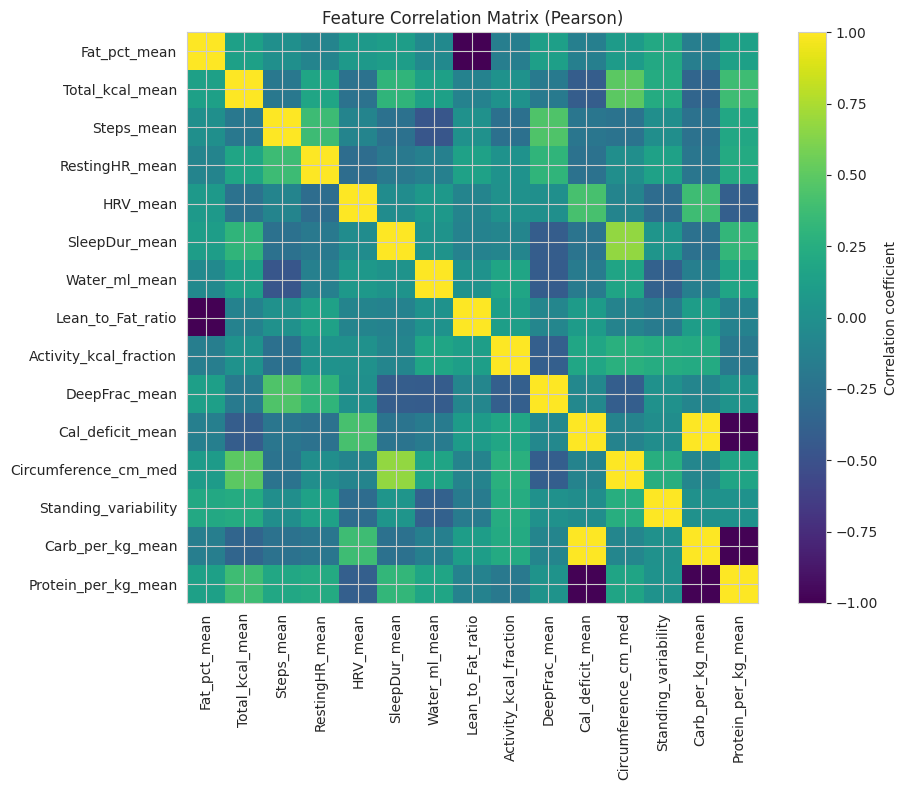

,var1,var2,corr
0,Fat_pct_mean,Lean_to_Fat_ratio,-0.994326
1,Cal_deficit_mean,Carb_per_kg_mean,0.994319
2,Carb_per_kg_mean,Protein_per_kg_mean,-0.988365
3,Cal_deficit_mean,Protein_per_kg_mean,-0.985024


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display

# --- 1. Load the windows data ---
# Loads the preprocessed 91-day window data from a Parquet file into a Pandas DataFrame.
df_windows = pd.read_parquet("janelas_91d.parquet")

# --- 2. Select feature columns ---
# Defines a list of feature column names to be used for correlation analysis.
feature_cols = [
    "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
    "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
    "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    "Circumference_cm_med", "Standing_variability",
    "Carb_per_kg_mean", "Protein_per_kg_mean"
]
# Selects only the specified feature columns from the DataFrame for analysis.
X = df_windows[feature_cols]

# --- 3. Correlation matrix ---
# Calculates the pairwise Pearson correlation coefficient for all selected feature columns.
corr_matrix = X.corr()

# --- 4. Heatmap (now with viridis) ---
# Creates a figure and a set of subplots for the heatmap visualization.
fig, ax = plt.subplots(figsize=(10, 8))
# Generates a heatmap of the correlation matrix, with values ranging from -1 to 1, using the 'viridis' colormap.
im = ax.imshow(corr_matrix.values, vmin=-1, vmax=1, cmap="viridis")
# Sets the x-axis ticks to correspond to the number of feature columns.
ax.set_xticks(range(len(feature_cols)))
# Sets the y-axis ticks to correspond to the number of feature columns.
ax.set_yticks(range(len(feature_cols)))
# Sets the x-axis tick labels to the feature names, rotated for readability.
ax.set_xticklabels(feature_cols, rotation=90)
# Sets the y-axis tick labels to the feature names.
ax.set_yticklabels(feature_cols)
# Sets the title of the heatmap.
ax.set_title("Feature Correlation Matrix (Pearson)")
# Adds a color bar next to the heatmap to indicate correlation values.
plt.colorbar(im, ax=ax, label="Correlation coefficient")
# Adjusts plot parameters for a tight layout, preventing labels from overlapping.
plt.tight_layout()
# Displays the generated heatmap.
plt.show()

# --- 5. Pairs with |corr| ≥ 0.80 ---
threshold = 0.80 # Defines the correlation threshold for identifying highly correlated pairs.
rows = [
    # Iterates through all unique pairs of feature columns.
    {"var1": feature_cols[i], "var2": feature_cols[j], "corr": corr_matrix.iat[i, j]}
    for i, j in combinations(range(len(feature_cols)), 2)
    # Filters pairs where the absolute correlation coefficient is greater than or equal to the threshold.
    if abs(corr_matrix.iat[i, j]) >= threshold
]
# Creates a DataFrame from the identified highly correlated pairs.
high_corr_df = (pd.DataFrame(rows)
                # Sorts the DataFrame by the absolute correlation value in descending order.
                .sort_values("corr", key=np.abs, ascending=False)
                # Resets the DataFrame index.
                .reset_index(drop=True))

# Displays the DataFrame containing highly correlated feature pairs.
display(high_corr_df)

## 04. Collinearity Filtering and Feature Statistics

This cell addresses multicollinearity among features and provides statistical insights into the selected and removed variables. It groups highly correlated features, selects the best representative from each group, and then reports the internal group correlation and the correlation with the target variable (`slope_kg_per_week`) for all features.

| Name                 | Description                                                                                                                                                                                            |
| :------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `FILTERED_PARQUET`   | Parquet file containing the filtered features (after collinearity resolution) along with the target and date columns.                                                                                      |
| `REMOVED_TXT`        | Text file listing the features that were removed due to high collinearity, along with their average absolute internal group correlation and absolute correlation with the target.                       |

---

In [38]:
from __future__ import annotations
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx

# -----------------------------------------------------------------
# Paths and parameters
# -----------------------------------------------------------------
WINDOW_PARQUET = Path("janelas_91d.parquet") # Path to the input 91-day window data Parquet file
FILTERED_PARQUET = Path("janelas_91d_filtered.parquet") # Output path for the filtered Parquet file
REMOVED_TXT = Path("janelas_91d_removed_cols.txt") # Output path for the text file listing removed columns

THRESHOLD = 0.80  # Absolute Pearson correlation threshold for collinearity grouping

FEATURE_COLS = [
    "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
    "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
    "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    "Circumference_cm_med", "Standing_variability",
    "Carb_per_kg_mean", "Protein_per_kg_mean",
] # List of feature columns to be analyzed for collinearity

TARGET_COL = "slope_kg_per_week" # Name of the target variable column
DATE_COL = "window_start" # Name of the date column

# -----------------------------------------------------------------
# Utilities
# -----------------------------------------------------------------

def build_graph(corr: pd.DataFrame, cols: list[str], thr: float) -> nx.Graph:
    """Builds a graph where nodes are columns and edges connect highly correlated columns."""
    g = nx.Graph() # Initialize an empty undirected graph
    g.add_nodes_from(cols) # Add all feature columns as nodes to the graph
    for i, c1 in enumerate(cols):
        for c2 in cols[i + 1 :]: # Iterate through unique pairs of columns
            if abs(corr.loc[c1, c2]) >= thr: # If the absolute correlation between two columns is above the threshold
                g.add_edge(c1, c2) # Add an edge between these two columns
    return g


def pick_keep_column(group: list[str], corr: pd.DataFrame, y_corr: pd.Series) -> str:
    """Selects the column to keep from a highly correlated group.

    Selection criteria:
    1. Smallest average absolute internal correlation within the group.
    2. Tie-breaker: Highest absolute correlation with the target variable (y).
    """
    mean_r = {
        col: np.mean([abs(corr.loc[col, other]) for other in group if other != col])
        for col in group
    } # Calculate the average absolute internal correlation for each column in the group
    min_mean = min(mean_r.values()) # Find the minimum average internal correlation
    candidates = [c for c, m in mean_r.items() if np.isclose(m, min_mean)] # Identify columns with the minimum average internal correlation
    if len(candidates) == 1:
        return candidates[0] # If only one candidate, return it
    # If there's a tie, choose the candidate with the highest absolute correlation with the target (y)
    return max(candidates, key=lambda c: abs(y_corr[c]))

# -----------------------------------------------------------------
# Main pipeline
# -----------------------------------------------------------------

def main() -> None:
    # Check if the input window data file exists
    if not WINDOW_PARQUET.exists():
        sys.exit("❌ Window file not found.")

    df = pd.read_parquet(WINDOW_PARQUET) # Load the window data DataFrame
    X = df[FEATURE_COLS] # Extract feature columns
    y = df[TARGET_COL] # Extract the target column

    corr = X.corr() # Calculate the correlation matrix for features
    y_corr = X.apply(lambda col: col.corr(y))  # Calculate the correlation of each feature with the target variable (y)

    # Build a graph to identify highly correlated groups (connected components)
    graph = build_graph(corr, FEATURE_COLS, THRESHOLD)
    groups = list(nx.connected_components(graph)) # Get list of connected components (groups of highly correlated features)

    kept, removed_info = [], [] # Initialize lists for kept columns and information about removed columns
    for grp in groups:
        grp_list = sorted(grp, key=lambda c: FEATURE_COLS.index(c)) # Sort group members by their original index in FEATURE_COLS
        if len(grp_list) == 1:
            kept.append(grp_list[0]) # If a group has only one member, keep it
            continue
        keep_col = pick_keep_column(grp_list, corr, y_corr) # Select the best column to keep from the group
        kept.append(keep_col) # Add the selected column to the 'kept' list
        for col in grp_list:
            if col == keep_col:
                continue # Skip the kept column
            # Calculate the average absolute internal correlation for the removed column
            mean_internal = np.mean([abs(corr.loc[col, other]) for other in grp_list if other != col])
            # Store the removed column's name, its average internal correlation, and its absolute correlation with y
            removed_info.append((col, mean_internal, abs(y_corr[col])))

    # Sort the kept columns by their original order
    kept.sort(key=lambda c: FEATURE_COLS.index(c))
    # Sort the removed columns information by their original order
    removed_info.sort(key=lambda t: FEATURE_COLS.index(t[0]))

    # --- Report ---
    print("Kept (", len(kept), ") – statistics:")
    for col in kept:
        # Calculate the average absolute internal correlation for the kept column within its original group
        internal_vals = [abs(corr.loc[col, other]) for other in FEATURE_COLS if other != col and abs(corr.loc[col, other]) >= THRESHOLD]
        mean_int = np.mean(internal_vals) if internal_vals else np.nan # If no internal correlations, set to NaN
        mean_text = f"{mean_int:.3f}" if not np.isnan(mean_int) else "—" # Format for display
        # Print statistics for the kept column
        print(f"  {col:<25} avg|ρ_group|={mean_text:<5}  |ρ(col,y)|={abs(y_corr[col]):.3f}")

    print("\nRemoved (", len(removed_info), ") – avg|ρ| and |ρ(col,y)|:")
    for col, m_int, rho_y in removed_info:
        # Print statistics for the removed column
        print(f"  {col:<25} {m_int:.3f} {rho_y:.3f}")

    # Save filtered Parquet file
    # Select kept features, target, and date columns and save to Parquet
    df[kept + [TARGET_COL, DATE_COL]].to_parquet(FILTERED_PARQUET, index=False, engine="pyarrow")
    # Save removed columns information to a text file
    with REMOVED_TXT.open("w") as f:
        for col, m_int, rho_y in removed_info:
            f.write(f"{col}\t{m_int:.3f}\t{rho_y:.3f}\n")

    print("\n✅ Filtered Parquet saved to:", FILTERED_PARQUET.resolve())
    print("Detailed list saved to:", REMOVED_TXT.resolve())


if __name__ == "__main__":
    main()

Kept ( 12 ) – statistics:
  Fat_pct_mean              avg|ρ_group|=0.994  |ρ(col,y)|=0.169
  Total_kcal_mean           avg|ρ_group|=—      |ρ(col,y)|=0.347
  Steps_mean                avg|ρ_group|=—      |ρ(col,y)|=0.336
  RestingHR_mean            avg|ρ_group|=—      |ρ(col,y)|=0.127
  HRV_mean                  avg|ρ_group|=—      |ρ(col,y)|=0.024
  SleepDur_mean             avg|ρ_group|=—      |ρ(col,y)|=0.099
  Water_ml_mean             avg|ρ_group|=—      |ρ(col,y)|=0.451
  Activity_kcal_fraction    avg|ρ_group|=—      |ρ(col,y)|=0.077
  DeepFrac_mean             avg|ρ_group|=—      |ρ(col,y)|=0.304
  Circumference_cm_med      avg|ρ_group|=—      |ρ(col,y)|=0.156
  Standing_variability      avg|ρ_group|=—      |ρ(col,y)|=0.026
  Protein_per_kg_mean       avg|ρ_group|=0.987  |ρ(col,y)|=0.068

Removed ( 3 ) – avg|ρ| and |ρ(col,y)|:
  Lean_to_Fat_ratio         0.994 0.160
  Cal_deficit_mean          0.990 0.085
  Carb_per_kg_mean          0.991 0.055

✅ Filtered Parquet saved to: /con

## 05. Correlation Heatmaps: Before and After Collinearity Filtering
----
This cell visualizes the correlation matrices of features *before* and *after* the collinearity filtering process. It presents two heatmaps side-by-side, maintaining identical square cell sizes and aligning their bases to clearly show the impact of the filtering on feature relationships.

| Name               | Description                                    |
| :----------------- | :--------------------------------------------- |
| `df_before`        | DataFrame containing features before filtering. |
| `df_after`         | DataFrame containing features after filtering.  |
| `corr_before`      | Correlation matrix of features before filtering. |
| `corr_after`       | Correlation matrix of features after filtering. |

---


/tmp/ipython-input-39-3284980265.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.95, 1])


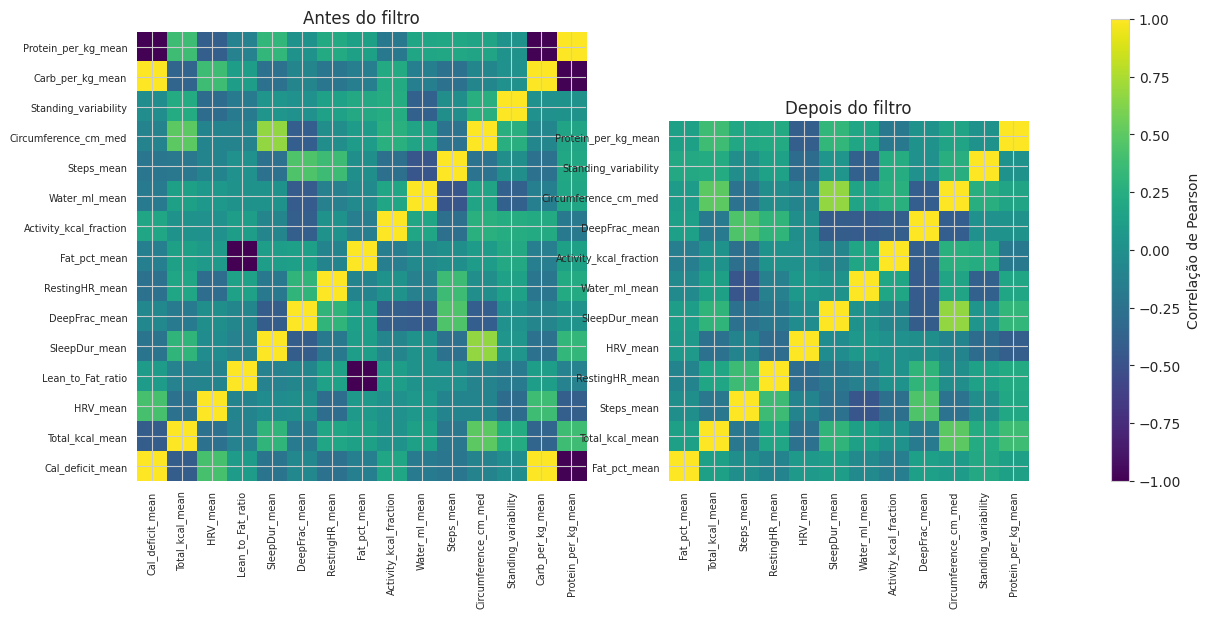

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

# Define paths for input and target/date columns
BEFORE_PATH = "janelas_91d.parquet" # Path to the Parquet file with data before filtering
AFTER_PATH  = "janelas_91d_filtered.parquet" # Path to the Parquet file with data after filtering
TARGET = "slope_kg_per_week" # Name of the target column
DATE   = "window_start" # Name of the date column

# ---- Load data ----
# Load the dataframes from the specified Parquet files
df_before = pd.read_parquet(BEFORE_PATH)
df_after  = pd.read_parquet(AFTER_PATH)

# Identify feature columns by excluding target and date columns
feat_before = [c for c in df_before.columns if c not in {TARGET, DATE}]
feat_after  = [c for c in df_after.columns  if c not in {TARGET, DATE}]

# Calculate correlation matrices for features before and after filtering
corr_before = df_before[feat_before].corr()
corr_after  = df_after[feat_after].corr()

# Get the number of features in each set
n_before = len(feat_before)
n_after  = len(feat_after)

# ---- Figure layout ----
cell = 0.4  # Base size in inches per cell
# Calculate figure width based on the number of features and additional space for colorbar and margins
fig_width = cell * (n_before + n_after) + 2
# Calculate figure height based on the number of features in the 'before' plot (which is typically larger)
fig_height = cell * n_before
fig = plt.figure(figsize=(fig_width, fig_height)) # Create the figure with calculated dimensions

# Define a GridSpec for layout: 1 row, 3 columns with specified width ratios for before, after, and colorbar
gs = GridSpec(1, 3, width_ratios=[n_before, n_after, 0.6], wspace=0.3)
ax_before = fig.add_subplot(gs[0]) # Add subplot for 'before' heatmap
ax_after  = fig.add_subplot(gs[1]) # Add subplot for 'after' heatmap
cb_ax     = fig.add_subplot(gs[2]) # Add subplot for the colorbar

# Get a copy of the 'viridis' colormap
cmap = mpl.colormaps["viridis"].copy()

# ---- Helper: clean spines/anchor and set aspect ----
# Iterate through both axes to apply common formatting
for ax in (ax_before, ax_after):
    for spine in ax.spines.values():
        spine.set_visible(False) # Hide the spines (borders) of the plot
    ax.set_anchor("SW") # Anchor the subplot content to the south-west (bottom-left) corner
    ax.set_aspect("equal", adjustable="box") # Set aspect ratio to 'equal' so cells are square

ax_after.set_facecolor("white") # Set the background color of the 'after' plot to white

# ---- Plot BEFORE ----
# Display the 'before' correlation matrix as an image (heatmap)
ax_before.imshow(corr_before.values, vmin=-1, vmax=1, cmap=cmap, origin="lower")
ax_before.set_xticks(range(n_before)) # Set x-axis ticks
ax_before.set_yticks(range(n_before)) # Set y-axis ticks
ax_before.set_xticklabels(feat_before, rotation=90, fontsize=7) # Set x-axis labels with rotation
ax_before.set_yticklabels(feat_before, fontsize=7) # Set y-axis labels
ax_before.set_title("Antes do filtro") # Set title for the 'before' plot

# ---- Plot AFTER ----
# Display the 'after' correlation matrix as an image (heatmap)
ax_after.imshow(corr_after.values, vmin=-1, vmax=1, cmap=cmap, origin="lower")
ax_after.set_xticks(range(n_after)) # Set x-axis ticks
ax_after.set_yticks(range(n_after)) # Set y-axis ticks
ax_after.set_xticklabels(feat_after, rotation=90, fontsize=7) # Set x-axis labels with rotation
ax_after.set_yticklabels(feat_after, fontsize=7) # Set y-axis labels
ax_after.set_title("Depois do filtro") # Set title for the 'after' plot

# Align bases – ensured by anchor SW and equal aspect; no extra code

# ---- Colorbar ----
# Add a color bar to the figure, linked to the 'before' heatmap, with a specified label
fig.colorbar(ax_before.images[0], cax=cb_ax, label="Correlação de Pearson")
cb_ax.yaxis.set_ticks_position("right") # Position the color bar ticks on the right

# ---- Layout ----
# Adjust plot parameters for a tight layout, leaving space for the colorbar (rect)
fig.tight_layout(rect=[0, 0, 0.95, 1])
plt.show() # Display the plots

## 06. Collinearity Network Visualization
---
This cell visualizes the collinearity network of features, providing a graphical representation of highly correlated variables. Nodes represent features, and edges connect features with a Pearson correlation coefficient (absolute value) greater than or equal to 0.80. The visualization uses the `viridis` color palette to distinguish between features kept after filtering (darker tone) and those eliminated (lighter tone), with a clear legend for easy interpretation.

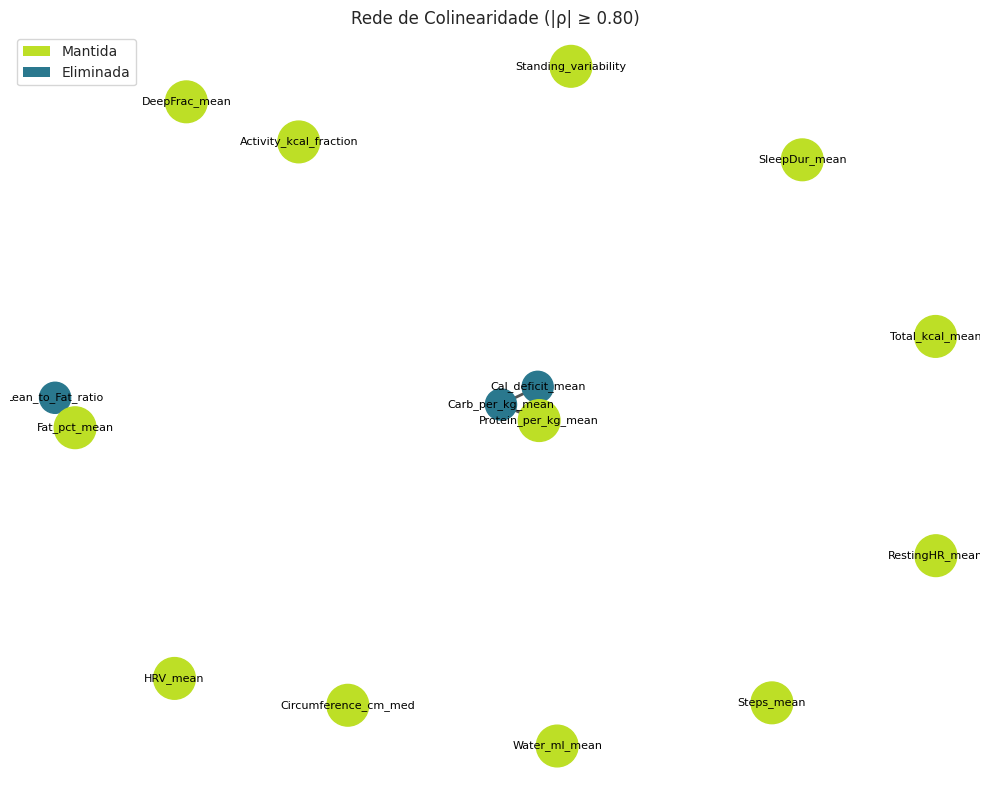

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from matplotlib.patches import Patch

# Define paths for input Parquet files and key column names
PARQUET_BEFORE = "janelas_91d.parquet" # Path to the Parquet file containing all features before filtering
PARQUET_AFTER  = "janelas_91d_filtered.parquet" # Path to the Parquet file containing features after collinearity filtering
TARGET = "slope_kg_per_week" # Name of the target column
DATE   = "window_start" # Name of the date column
THRESHOLD = 0.80 # Absolute Pearson correlation threshold for drawing edges in the graph

# ---- Load datasets ----
# Load the DataFrame containing all original features
df_before = pd.read_parquet(PARQUET_BEFORE)
# Load the DataFrame containing features after collinearity filtering
df_after  = pd.read_parquet(PARQUET_AFTER)

# Identify all feature columns from the 'before' DataFrame by excluding target and date columns
features_all  = [c for c in df_before.columns if c not in {TARGET, DATE}]
# Identify features that were kept after filtering from the 'after' DataFrame
features_keep = [c for c in df_after.columns  if c not in {TARGET, DATE}]

# Calculate the correlation matrix for all original features
corr = df_before[features_all].corr()

# ---- Build graph ----
G = nx.Graph() # Initialize an empty undirected graph
G.add_nodes_from(features_all) # Add all feature names as nodes to the graph
for i, c1 in enumerate(features_all):
    for c2 in features_all[i + 1 :]: # Iterate through unique pairs of features
        if abs(corr.loc[c1, c2]) >= THRESHOLD: # If the absolute correlation between features is above the threshold
            # Add an edge between the features, with the absolute correlation as its weight
            G.add_edge(c1, c2, weight=abs(corr.loc[c1, c2]))

# ---- Node styling (viridis) ----
cmap = mpl.colormaps["viridis"] # Get the 'viridis' colormap
color_keep = cmap(0.9)   # Define a darker color from viridis for kept nodes
color_drop = cmap(0.4)   # Define a lighter color from viridis for dropped nodes
# Assign colors to nodes based on whether they were kept or dropped
node_colors = [color_keep if n in features_keep else color_drop for n in G.nodes]
# Assign sizes to nodes, larger for kept nodes, smaller for dropped nodes
node_sizes  = [900 if n in features_keep else 500 for n in G.nodes]

# Compute node positions using the spring layout algorithm for visualization, with a fixed seed for reproducibility
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 8)) # Create a matplotlib figure with a specified size

# Draw edges with alpha proportional to their weight (correlation strength)
edge_weights = [G[u][v]['weight'] for u, v in G.edges] # Get all edge weights
max_w = max(edge_weights) if edge_weights else 1 # Find the maximum weight for normalization, handle empty list
for (u, v), w in zip(G.edges, edge_weights):
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], width=2, # Draw individual edges with a fixed width
        alpha=w / max_w, edge_color="#555555" # Set alpha (transparency) based on normalized weight, and color
    )

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes) # Draw nodes with specified colors and sizes
nx.draw_networkx_labels(G, pos, font_size=8) # Draw node labels (feature names)

# ---- Legend ----
# Create Patch objects for the legend to represent kept and eliminated nodes
legend_elements = [
    Patch(facecolor=color_keep, edgecolor='none', label='Mantida'), # Label for kept features
    Patch(facecolor=color_drop, edgecolor='none', label='Eliminada'), # Label for eliminated features
]
plt.legend(handles=legend_elements, loc="upper left") # Add the legend to the plot

plt.title("Rede de Colinearidade (|ρ| ≥ 0.80)") # Set the title of the plot
plt.axis("off") # Turn off the axis (no frame, ticks, or labels)
plt.tight_layout() # Adjust layout to prevent elements from overlapping
plt.show() # Display the plot

## 07. Model Data Preparation: Normalization, Split, and Statistics
---
This cell prepares the preprocessed and filtered window data for model training and evaluation. It normalizes features using z-score scaling based on the training set's statistics, performs a chronological split into initial training and walk-forward sets, and saves the prepared datasets along with the calculated scalers.

| Name             | Description                                          |
| :--------------- | :--------------------------------------------------- |
| `TRAIN_PARQUET`  | Parquet file for the initial training dataset.       |
| `WALK_PARQUET`   | Parquet file for the walk-forward dataset.           |
| `SCALER_JSON`    | JSON file containing mean and standard deviation for feature normalization. |
| `df_train`       | DataFrame for the initial training data.             |
| `df_walk`        | DataFrame for the walk-forward data.                 |

In [41]:
from __future__ import annotations

import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd

# Define paths for input and output files
FILTERED_PARQUET = Path("janelas_91d_filtered.parquet") # Path to the input filtered window data
TRAIN_PARQUET    = Path("train_initial.parquet")    # Output path for the initial training dataset
WALK_PARQUET     = Path("walk_forward.parquet")     # Output path for the walk-forward validation dataset
SCALER_JSON      = Path("feature_scalers.json")      # Output path for the JSON file containing feature scalers

# Define column names and split fraction
TARGET_COL = "slope_kg_per_week" # Name of the target variable column
DATE_COL   = "window_start"   # Name of the date column
TRAIN_FRAC = 0.70  # Fraction of oldest windows to use for initial training (70%)

# -----------------------------------------------------------------
# Pipeline
# -----------------------------------------------------------------

def main() -> None:
    # Check if the filtered Parquet file exists; exit if not
    if not FILTERED_PARQUET.exists():
        sys.exit("❌ Filtered Parquet not found. Run the collinearity filter first.")

    # Load the filtered data, sort by date, and reset index
    df = pd.read_parquet(FILTERED_PARQUET).sort_values(DATE_COL).reset_index(drop=True)
    # Identify feature columns by excluding target and date columns
    feature_cols = [c for c in df.columns if c not in {TARGET_COL, DATE_COL}]

    # ---- Temporal Split ----
    # Calculate the index for splitting the DataFrame based on TRAIN_FRAC
    split_idx = int(len(df) * TRAIN_FRAC)
    # Create the initial training DataFrame (oldest 70% of data)
    df_train = df.iloc[:split_idx].copy()
    # Create the walk-forward validation DataFrame (remaining 30% of data)
    df_walk  = df.iloc[split_idx:].copy()

    # ---- Compute scalers on train ----
    # Calculate the mean of each feature column from the training set
    means = df_train[feature_cols].mean()
    # Calculate the standard deviation of each feature column from the training set (ddof=0 for population std)
    stds  = df_train[feature_cols].std(ddof=0)

    # Save scalers (means and standard deviations) to a JSON file
    # The JSON file will store these values for later use (e.g., for applying to new data)
    SCALER_JSON.write_text(json.dumps({"mean": means.to_dict(), "std": stds.to_dict()}, indent=2))

    # ---- Apply z-score normalization ----
    # Apply Z-score normalization to feature columns in both training and walk-forward datasets
    # (value - mean) / standard_deviation
    for col in feature_cols:
        df_train[col] = (df_train[col] - means[col]) / stds[col]
        df_walk[col]  = (df_walk[col]  - means[col]) / stds[col]

    # ---- Save Parquets ----
    # Ensure the parent directory for output Parquet files exists
    TRAIN_PARQUET.parent.mkdir(parents=True, exist_ok=True)
    # Save the normalized training DataFrame to a Parquet file
    df_train.to_parquet(TRAIN_PARQUET, index=False, engine="pyarrow")
    # Save the normalized walk-forward DataFrame to a Parquet file
    df_walk.to_parquet(WALK_PARQUET,  index=False, engine="pyarrow")

    # ---- Report ----
    print("✅ Data prepared:")
    print(f"  Initial Training : {len(df_train)} windows → {TRAIN_PARQUET}")
    print(f"  Walk-forward     : {len(df_walk)} windows → {WALK_PARQUET}")
    print("  Scalers saved to:", SCALER_JSON)

    # ---- Extra stats ----
    print("\n### Statistics of normalized features (training set)\n")
    # Print descriptive statistics for the normalized features in the training set
    print(df_train[feature_cols].describe().T[["mean", "std", "min", "25%", "50%", "75%", "max"]].round(3))

    print("\n### Summary of target slope_kg_per_week\n")
    # Print summary statistics for the target variable in both training and walk-forward sets
    for name, dset in {"Training": df_train, "Walk": df_walk}.items():
        s = dset[TARGET_COL]
        print(f"{name:<7} → mean: {s.mean():.3f}  std: {s.std():.3f}  min: {s.min():.3f}  max: {s.max():.3f}")


if __name__ == "__main__":
    main()

✅ Data prepared:
  Initial Training : 91 windows → train_initial.parquet
  Walk-forward     : 39 windows → walk_forward.parquet
  Scalers saved to: feature_scalers.json

### Statistics of normalized features (training set)

                        mean    std    min    25%    50%    75%    max
Fat_pct_mean             0.0  1.006 -2.331 -0.781  0.058  0.801  2.273
Total_kcal_mean         -0.0  1.006 -1.826 -0.927  0.063  0.913  1.971
Steps_mean              -0.0  1.006 -2.013 -0.844  0.021  0.837  1.963
RestingHR_mean           0.0  1.006 -2.515 -0.726  0.063  0.697  2.063
HRV_mean                -0.0  1.006 -2.038 -0.763 -0.205  0.823  2.122
SleepDur_mean           -0.0  1.006 -1.770 -0.923 -0.049  0.847  2.247
Water_ml_mean           -0.0  1.006 -1.670 -0.735 -0.151  0.650  2.775
Activity_kcal_fraction   0.0  1.006 -1.623 -0.702 -0.111  0.609  2.606
DeepFrac_mean            0.0  1.006 -2.125 -0.550 -0.145  0.537  2.750
Circumference_cm_med     0.0  1.006 -1.839 -0.822 -0.386  1.066  2

# Model

## 08. Definição do Modelo BSTS: Estrutura e Priors Hierárquicos
---
This cell defines the structure of a Bayesian Structural Time Series (BSTS) model using TensorFlow Probability. It loads the normalized training data, specifies a local linear trend component and an exogenous regression component with the pre-selected features. Additionally, it maps feature indices to predefined groups, which will be used for setting up hierarchical priors in a subsequent step.

| Name               | Description                                    |
| :----------------- | :--------------------------------------------- |
| `GROUPS_JSON`      | JSON file mapping feature group names to their respective column indices. |

In [42]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from pathlib import Path
from tqdm import tqdm  # Progress bar library

# --- Config paths ---
TRAIN_PARQUET = Path("train_initial.parquet") # Path to the initial training data Parquet file
TARGET_COL = "slope_kg_per_week" # Name of the target variable column
DATE_COL   = "window_start"   # Name of the date column

# --- Load data ---
# Load the training data from the Parquet file and sort it by date
df_train = pd.read_parquet(TRAIN_PARQUET).sort_values(DATE_COL)
# Identify feature columns by excluding the target and date columns
feature_cols = [c for c in df_train.columns if c not in {TARGET_COL, DATE_COL}]

# Convert the observed time series (target variable) to a TensorFlow tensor
observed_time_series = tf.convert_to_tensor(df_train[TARGET_COL].values, dtype=tf.float32)
# Convert the exogenous regressors (feature matrix) to a TensorFlow tensor
exog_regressors = tf.convert_to_tensor(df_train[feature_cols].values, dtype=tf.float32)

# --- Component 1: Local Linear Trend ---
# Define a Local Linear Trend component for the BSTS model.
# This component models the underlying trend in the time series.
trend = tfp.sts.LocalLinearTrend(observed_time_series=observed_time_series)

# --- Component 2: Exogenous Regression ---
# Define a Linear Regression component for the BSTS model.
# This component models the effect of external (exogenous) variables on the time series.
regression = tfp.sts.LinearRegression(design_matrix=exog_regressors, name="ExogenousRegs")

# --- Build model ---
# Combine the trend and regression components into a single Sum model.
# The Sum model represents the observed time series as a sum of its components.
model = tfp.sts.Sum(components=[trend, regression], observed_time_series=observed_time_series)

print("BSTS model defined with:")
print(" • Local trend component")
print(f" • Exogenous regression with {len(feature_cols)} features")
print("Components ready to receive hierarchical priors in Step 2.")

# --- Save feature groups for priors ---
# Define a dictionary mapping conceptual groups to their respective feature names.
feature_groups = {
    "comp_corporal": ["Fat_pct_mean", "Lean_to_Fat_ratio", "Circumference_cm_med"],
    "gasto_energetico": ["Total_kcal_mean", "Activity_kcal_fraction"],
    "atividade": ["Steps_mean", "Standing_variability"],
    "cardio": ["RestingHR_mean", "HRV_mean"],
    "sono": ["SleepDur_mean", "DeepFrac_mean"],
    "nutrientes": ["Carb_per_kg_mean", "Protein_per_kg_mean"],
    "ingestao_hidratacao": ["Cal_deficit_mean", "Water_ml_mean"],
}

print("Mapping feature indices by group…")
# Initialize a dictionary to store the indices of features for each group.
group_indices = {}
# Iterate through each feature group with a progress bar.
for g, cols in tqdm(list(feature_groups.items()), desc="Groups"):
    # For each group, find the index of each feature column within the 'feature_cols' list.
    # This mapping is crucial for applying hierarchical priors to specific groups of features.
    group_indices[g] = [feature_cols.index(col) for col in cols if col in feature_cols]

# Define the path for saving the feature groups JSON file.
GROUPS_JSON = Path("feature_groups.json")
# Convert the 'group_indices' dictionary to a Pandas Series and then save it as a JSON file.
# The 'indent=2' makes the JSON output human-readable.
GROUPS_JSON.write_text(pd.Series(group_indices).to_json(indent=2))
print("Group map saved to", GROUPS_JSON)

BSTS model defined with:
 • Local trend component
 • Exogenous regression with 12 features
Components ready to receive hierarchical priors in Step 2.
Mapping feature indices by group…


Groups: 100%|██████████| 7/7 [00:00<00:00, 107153.75it/s]

Group map saved to feature_groups.json


## 09. Definição do Modelo BSTS: Estrutura com Priors Hierárquicos Ajustados
---
This cell defines the Bayesian Structural Time Series (BSTS) model structure with carefully adjusted hierarchical priors, which aim to reduce parametric uncertainty. It loads the normalized training data, sets up a local linear trend component, and an exogenous regression component. For the regression weights, hierarchical priors are applied, with specific, reduced scale values for each feature group. Additionally, an explicit `HalfNormal(scale=0.5)` prior is introduced for the observation noise scale to recalibrate `σ_obs`.

| Name              | Description                                                                                             |
| :---------------- | :------------------------------------------------------------------------------------------------------ |
| `GROUP_SIGMAS`    | Dictionary mapping feature group names to adjusted hyper-prior scale values for hierarchical priors.    |
| `group_indices`   | Dictionary loaded from `feature_groups.json`, mapping group names to their corresponding feature indices. |
| `model`           | The constructed `tfp.sts.Sum` model with defined components and adjusted priors.                       |

In [43]:
import os
import json
from pathlib import Path
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

# --- Paths & constants ---
TRAIN_PARQUET = Path("train_initial.parquet") # Path to the initial training data Parquet file
GROUPS_JSON   = Path("feature_groups.json")   # Path to the JSON file containing feature group indices
TARGET_COL    = "slope_kg_per_week" # Name of the target variable column
DATE_COL      = "window_start"      # Name of the date column

# --- Adjusted hyper-priors τ (smaller values) ---
# Dictionary defining the scale (sigma) for the HalfNormal hyper-priors for each feature group.
# These smaller values reduce parametric uncertainty.
GROUP_SIGMAS = {
    "comp_corporal":        0.07,
    "gasto_energetico":     0.07,
    "atividade":            0.03,
    "cardio":               0.03,
    "sono":                 0.03,
    "nutrientes":           0.05,
    "ingestao_hidratacao":  0.05,
}

# --- Load data ---
print("📥  Loading training data…")
# Load the training DataFrame and sort it by date
df_train = pd.read_parquet(TRAIN_PARQUET).sort_values(DATE_COL)
# Identify feature columns by excluding target and date columns
feature_cols = [c for c in df_train.columns if c not in {TARGET_COL, DATE_COL}]
# Convert feature matrix (X) to a TensorFlow tensor
X = tf.convert_to_tensor(df_train[feature_cols].values, dtype=tf.float32)
# Convert observed time series (Y, target variable) to a TensorFlow tensor
Y = tf.convert_to_tensor(df_train[TARGET_COL].values, dtype=tf.float32)

# --- STS Components ---
# Define the Local Linear Trend component for the BSTS model
trend = tfp.sts.LocalLinearTrend(observed_time_series=Y)

# --- Hierarchical priors for regression ---
# Load the feature group indices from the JSON file
with GROUPS_JSON.open() as f:
    group_indices = json.load(f)

prior_scales = [] # List to store the prior scale variables for each feature weight
for idx in range(len(feature_cols)):
    # Find the group to which the current feature index belongs
    grp = None
    for g, lst in group_indices.items():
        if idx in lst:
            grp = g
            break
    if grp is None:
        # Handle case where a feature index is not found in any group (safety check)
        print(f"Warning: Feature index {idx} not found in any group. Using default sigma.")
        sigma = 0.05 # Default sigma if group not found
        tau_name = f"tau_feature_{idx}" # Unique name for ungrouped feature's prior
    else:
        # Get the predefined sigma for the found group, or use a default if group not in GROUP_SIGMAS
        sigma = GROUP_SIGMAS.get(grp, 0.05)
        tau_name = f"tau_{grp}" # Name for the prior scale variable based on the group name

    # Create a TransformedVariable for the prior scale (tau) for the current feature/group.
    # Softplus bijector ensures the scale is positive.
    tau = tfp.util.TransformedVariable(
        initial_value=sigma,
        bijector=tfp.bijectors.Softplus(), # Ensures the scale parameter is positive
        name=tau_name # Name for the variable, useful for debugging
    )
    prior_scales.append(tau) # Add the created prior scale variable to the list
# Stack the list of individual prior scale variables into a single tensor
prior_scale_values = tf.stack(prior_scales)

# Define the Linear Regression component with hierarchical priors for its weights.
# The `weights_prior` is a Normal distribution whose scale is determined by the `prior_scale_values` tensor,
# allowing different prior strengths for different feature groups.
regression = tfp.sts.LinearRegression(
    design_matrix=X,
    weights_prior=tfp.distributions.Normal(loc=0., scale=prior_scale_values),
    name="HierLinearRegs"
)

# --- Prior for observation noise (σ_obs) – HalfNormal scale 0.5 ---
# Define a HalfNormal prior distribution for the observation noise scale.
# This explicitly sets an expectation for the magnitude of observational noise.
obs_noise_prior = tfp.distributions.HalfNormal(scale=0.5)

# --- Summary model with adjusted hierarchical priors and recalibrated σ_obs ---
# Build the final BSTS model as a sum of the trend and regression components.
# The `observation_noise_scale_prior` is explicitly set to recalibrate sigma_obs.
model = tfp.sts.Sum(
    components=[trend, regression],
    observed_time_series=Y,
    observation_noise_scale_prior=obs_noise_prior # Explicit prior for observation noise scale
)

print("✅ Model with adjusted hierarchical priors and recalibrated σ_obs constructed.")

📥  Loading training data…
✅ Model with adjusted hierarchical priors and recalibrated σ_obs constructed.


## 10. Variational Inference Setup (Step 3-a)
---
This cell sets up the necessary components for performing Variational Inference (VI) on the Bayesian Structural Time Series (BSTS) model. It ensures environment variables are configured, loads the training data, reconstructs the BSTS model with the defined hierarchical priors, and initializes the surrogate posterior distribution and the Adam optimizer. This setup prepares the environment and model for the optimization process in the next step of Variational Inference.

| Name                  | Description                                                                 |
| :-------------------- | :-------------------------------------------------------------------------- |
| `GROUP_SIGMAS`        | Dictionary mapping feature group names to the adjusted hyper-prior scale values for hierarchical priors. |
| `model`               | The reconstructed `tfp.sts.Sum` model with hierarchical priors.             |
| `surrogate_posterior` | The `tfp.sts.VariationalPosterior` object used to approximate the true posterior. |
| `optimizer`           | The `tf.keras.optimizers.Adam` instance configured for optimization.        |

In [44]:
# ================================================================
# 07_vi_step3a_setup.py – Variational Inference (Setup) – FIXED
# ----------------------------------------------------------------
# • Sets environment variables *before* the first TF import to
# • Maintains original logic for random seed, model reconstruction
#   with hierarchical priors, and surrogate posterior creation.
# ================================================================

# -----------------------------------------------------------------
# 0. Environment variables – must come BEFORE any TF import
# -----------------------------------------------------------------
import os, random, json, logging
import random, numpy as np
from pathlib import Path

# -----------------------------------------------------------------
# 1. Imports after environment variables
# -----------------------------------------------------------------
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import absl.logging as absl_logging
from tqdm import tqdm

# Suppress Python/absl loggers
tf.get_logger().setLevel("ERROR") # Set TensorFlow logger level to ERROR
absl_logging.set_verbosity(absl_logging.ERROR) # Set absl logging verbosity to ERROR
absl_logging.set_stderrthreshold("error") # Set absl stderr threshold to ERROR
logging.getLogger("tensorflow").setLevel(logging.ERROR) # Set standard logging level for TensorFlow to ERROR

# ----- Force CPU-only ----- # Removed/Commented to allow GPU
# try:
#     tf.config.set_visible_devices([], "GPU") # Attempt to set visible devices to only CPU (empty list for GPU)
# except Exception:
#     pass # Catch any exceptions if setting devices fails

# -----------------------------------------------------------------
# 2. Constants and hyperparameters
# -----------------------------------------------------------------
TRAIN_PARQUET = Path("train_initial.parquet") # Path to the initial training data Parquet file
GROUPS_JSON   = Path("feature_groups.json")   # Path to the JSON file containing feature group indices
TARGET_COL    = "slope_kg_per_week" # Name of the target variable column
DATE_COL      = "window_start"      # Name of the date column

NUM_STEPS     = 2000 # Number of optimization steps for variational inference
LEARNING_RATE = 1e-2 # Learning rate for the Adam optimizer

# Fixed seed for reproducibility
TF_SEED = 42 # Define a fixed seed value
random.seed(TF_SEED) # Set Python's random seed
np.random.seed(TF_SEED) # Set NumPy's random seed
print("Seed used in this execution:", TF_SEED) # Print the seed being used
tf.random.set_seed(TF_SEED) # Set TensorFlow's global random seed


# -----------------------------------------------------------------
# 3. Load training data
# -----------------------------------------------------------------
# Load the training data from the Parquet file and sort it by date
df_train = pd.read_parquet(TRAIN_PARQUET).sort_values(DATE_COL)
# Identify feature columns by excluding target and date columns
feature_cols = [c for c in df_train.columns if c not in {TARGET_COL, DATE_COL}]
# Convert observed time series (Y, target variable) to a TensorFlow tensor
Y = tf.convert_to_tensor(df_train[TARGET_COL].values, dtype=tf.float32)
# Convert feature matrix (X, exogenous regressors) to a TensorFlow tensor
X = tf.convert_to_tensor(df_train[feature_cols].values, dtype=tf.float32)

# -----------------------------------------------------------------
# 4. Reconstruct model with hierarchical priors (Step 2 logic)
# -----------------------------------------------------------------
# Load the feature group indices from the JSON file
with GROUPS_JSON.open() as f:
    group_indices = json.load(f)

# Define adjusted hyper-priors (smaller values) for feature groups
GROUP_SIGMAS = {
    "comp_corporal": 0.10,
    "gasto_energetico": 0.10,
    "atividade": 0.05,
    "cardio": 0.05,
    "sono": 0.05,
    "nutrientes": 0.07,
    "ingestao_hidratacao": 0.07,
}

# Define the Local Linear Trend component for the BSTS model
trend = tfp.sts.LocalLinearTrend(observed_time_series=Y)
prior_scales = [] # List to store prior scale variables for each feature weight
for idx in range(len(feature_cols)):
    # Check if the current feature index belongs to any defined group
    grp = None
    for g, lst in group_indices.items():
        if idx in lst:
            grp = g
            break
    if grp is None:
        # Warning if a feature index is not found in any group; use a default sigma
        print(f"Warning: Feature index {idx} not found in any group. Using default sigma.")
        sigma = 0.05
        tau_name = f"tau_feature_{idx}" # Unique name for ungrouped feature's prior
    else:
        # Get the sigma value for the identified group, or a default if group is not in GROUP_SIGMAS
        sigma = GROUP_SIGMAS.get(grp, 0.05)
        tau_name = f"tau_{grp}" # Name for the prior scale variable based on the group name

    # Create a TransformedVariable for the prior scale (tau) for the current feature/group.
    # Softplus bijector ensures the scale is positive.
    tau = tfp.util.TransformedVariable(sigma, tfp.bijectors.Softplus(), name=tau_name)
    prior_scales.append(tau) # Add the created prior scale variable to the list
# Stack the list of individual prior scale variables into a single tensor
prior_scale_values = tf.stack(prior_scales)

# Define the Linear Regression component with hierarchical priors for its weights
regression = tfp.sts.LinearRegression(
    design_matrix=X,
    weights_prior=tfp.distributions.Normal(loc=0., scale=prior_scale_values), # Hierarchical prior on weights
    name="HierLinearRegs")

# Build the final BSTS model as a sum of the trend and regression components
model = tfp.sts.Sum([trend, regression], observed_time_series=Y)

# -----------------------------------------------------------------
# 5. Surrogate posterior & optimizer
# -----------------------------------------------------------------
# Build the factored surrogate posterior distribution for the model parameters
surrogate_posterior = tfp.sts.build_factored_surrogate_posterior(model)
# Initialize the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

print("✅ VI setup ready – surrogate posterior and optimizer defined.")
print("Num steps:", NUM_STEPS)

# Expose key variables to the global scope for use in subsequent cells (e.g., for optimization and analysis)
globals().update({
    "model": model, # The constructed BSTS model
    "surrogate_posterior": surrogate_posterior, # The surrogate posterior distribution
    "optimizer": optimizer, # The optimizer
    "Y": Y, # The observed time series (target variable)
    "NUM_STEPS": NUM_STEPS, # Number of optimization steps
    "feature_cols": feature_cols # List of feature column names
})

Seed used in this execution: 42
✅ VI setup ready – surrogate posterior and optimizer defined.
Num steps: 2000


## 11. Bayesian Structural Time Series (BSTS) Model Variational Inference Training
---
This cell executes the Variational Inference (VI) training process for the BSTS model. It leverages TensorFlow's automatic GPU detection, suppresses verbose logging, and optimizes the surrogate posterior by maximizing the Evidence Lower Bound (ELBO) over a specified number of steps. The training progress is displayed via a progress bar, and the ELBO values are saved to a file for later analysis.

| Name      | Description                                                    |
| :-------- | :------------------------------------------------------------- |
| `ELBO_PATH` | NumPy file containing the history of ELBO values during training. |

In [45]:
# ================================================================
# 08_vi_step3b_train_fixed.py – Variational Inference (Training)
# ----------------------------------------------------------------
# GPU-friendly version that:
# • Suppresses TensorFlow INFO/WARN logs.
# • Automatically uses GPU if available.
# • Uses trace_fn with tf.reduce_mean to convert ELBO tensor → scalar.
# • Saves ELBO vector.
# ================================================================

# ----- Suppress logs -----
import os
# Set TensorFlow's C++ logging level to suppress INFO and WARNING messages, showing only fatal errors.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from pathlib import Path
from tqdm import tqdm # Import tqdm for progress bars
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

# ----- Check global objects from Step 3-a -----
# Define a tuple of required global variables that should have been set in the previous cell (Step 3-a).
required = ("model", "surrogate_posterior", "optimizer", "Y", "NUM_STEPS")
# Check for any missing required global variables.
missing = [n for n in required if n not in globals()]
if missing:
    # If any required variables are missing, raise a RuntimeError instructing the user to run Step 3-a first.
    raise RuntimeError(f"Execute Step 3-a first; missing: {missing}")

# Define the path where the ELBO (Evidence Lower Bound) values will be saved.
ELBO_PATH = Path("vi_elbo.npy")
# Create parent directories for the ELBO path if they don't already exist.
ELBO_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"🏃  Starting VI ({NUM_STEPS} steps)…")
# Initialize a tqdm progress bar for visualizing the training steps.
bar = tqdm(total=NUM_STEPS, desc="VI", unit="step")
# Initialize an empty list to store the ELBO loss values during training.
loss_list: list[float] = []

# ----- Safe trace_fn -----
# Define a trace function to be called at each optimization step.
def trace_fn(tr):
    # Convert the ELBO tensor (which might have a sample_size dimension) to a scalar by taking its mean.
    # The negative of the loss is taken because tfp.vi.fit_surrogate_posterior minimizes loss,
    # but ELBO is maximized.
    elbo_scalar = float(tf.reduce_mean(-tr.loss).numpy())
    loss_list.append(elbo_scalar) # Append the scalar ELBO value to the loss list
    bar.update(1) # Update the progress bar by one step
    # Update the progress bar's postfix message with the current ELBO value every 100 steps.
    if len(loss_list) % 100 == 0:
        bar.set_postfix({"ELBO": f"{elbo_scalar:.3f}"})
    return tr.loss  # Required by the tfp.vi.fit_surrogate_posterior API

# ----- Fit VI -----
# Perform variational inference to fit the surrogate posterior to the target log probability.
tfp.vi.fit_surrogate_posterior(
    # The target log probability function is derived from the joint distribution of the model
    # given the observed time series.
    target_log_prob_fn=model.joint_distribution(observed_time_series=Y).log_prob,
    surrogate_posterior=surrogate_posterior, # The surrogate posterior distribution to optimize
    optimizer=optimizer, # The optimizer used for training
    num_steps=NUM_STEPS, # The total number of optimization steps
    trace_fn=trace_fn, # The callback function to execute at each step (for progress and logging)
    sample_size=1, # Number of samples to draw from the surrogate posterior at each step
)

bar.close() # Close the progress bar after training is complete
np.save(ELBO_PATH, np.array(loss_list)) # Save the list of ELBO values to a NumPy file
print("✅ VI completed. Final ELBO =", loss_list[-1]) # Print the final ELBO value
print("ELBO vector saved to", ELBO_PATH) # Print the path where the ELBO vector was saved

🏃  Starting VI (2000 steps)…


VI: 2001step [01:19, 25.08step/s, ELBO=103.028]

✅ VI completed. Final ELBO = 101.56391143798828
ELBO vector saved to vi_elbo.npy


## ELBO and Posterior Diagnostics
---
This cell visualizes the convergence of the Variational Inference (VI) training by plotting the Evidence Lower Bound (ELBO) over iterations. Following this, it samples from the trained surrogate posterior distribution to obtain draws for model parameters, specifically the regression coefficients and the trend level scale. These sampled posteriors are then saved to Parquet files for further analysis and model interpretation.

| Name          | Description                                                    |
| :------------ | :------------------------------------------------------------- |
| `ELBO_PATH`   | NumPy file containing the history of ELBO values during training. |
| `COEF_PATH`   | Parquet file containing samples of the posterior regression coefficients. |
| `TREND_PATH`  | Parquet file containing samples of the posterior trend level scale. |
| `coef_df`     | DataFrame holding the sampled posterior distributions of the regression coefficients. |
| `trend_scale` | NumPy array holding the sampled posterior distribution of the trend level scale. |

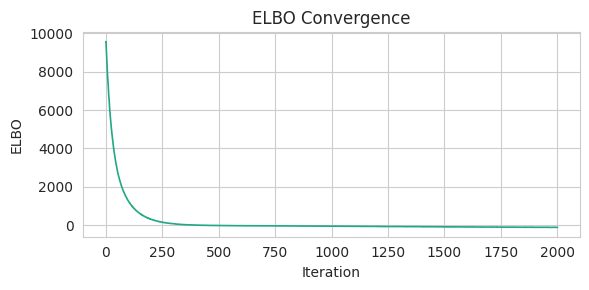

📦  Sampling 1,000 draws from the posterior…

── Coefficients summary ( 12000 samples) ─────────────────────
                         mean    std    min    25%    50%    75%    max
Fat_pct_mean            0.002  0.017 -0.091 -0.006  0.003  0.011  0.077
Total_kcal_mean        -0.001  0.022 -0.107 -0.012  0.001  0.012  0.093
Steps_mean              0.008  0.024 -0.129 -0.004  0.010  0.022  0.114
RestingHR_mean         -0.008  0.019 -0.093 -0.019 -0.008  0.003  0.079
HRV_mean               -0.010  0.016 -0.083 -0.020 -0.010 -0.001  0.054
SleepDur_mean          -0.009  0.025 -0.109 -0.024 -0.009  0.005  0.140
Water_ml_mean           0.005  0.029 -0.127 -0.010  0.006  0.022  0.156
Activity_kcal_fraction  0.001  0.022 -0.101 -0.011  0.001  0.014  0.115
DeepFrac_mean          -0.006  0.023 -0.113 -0.020 -0.008  0.006  0.112
Circumference_cm_med   -0.006  0.019 -0.109 -0.018 -0.005  0.005  0.093
Standing_variability   -0.002  0.014 -0.068 -0.010 -0.003  0.005  0.065
Protein_per_kg_mean     0.01

In [46]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow_probability as tfp

# ----- Check prerequisites -----
# Assert that 'surrogate_posterior' is available in the global scope; if not, raise an error.
assert "surrogate_posterior" in globals(), "Surrogate posterior missing. Run 3-a and 3-b."
ELBO_PATH = Path("vi_elbo.npy") # Define the path to the saved ELBO values
# Assert that the ELBO file exists; if not, raise an error.
assert ELBO_PATH.exists(), "vi_elbo.npy not found. Run 3-b."

# Define paths for saving the posterior samples of coefficients and trend
COEF_PATH  = Path("coef_posterior.parquet")
TREND_PATH = Path("trend_posterior.parquet")

# ----- 1. Plot ELBO -----
losses = np.load(ELBO_PATH) # Load the ELBO values from the .npy file
plt.figure(figsize=(6, 3)) # Create a new figure with specified size
# Plot the negative of the ELBO values (since ELBO is maximized, loss is minimized)
# Use a specific color from the 'viridis' colormap
plt.plot(-losses, color=mpl.colormaps.get_cmap("viridis")(0.6), lw=1.2)
plt.xlabel("Iteration") # Set x-axis label
plt.ylabel("ELBO") # Set y-axis label
plt.title("ELBO Convergence") # Set plot title
plt.tight_layout() # Adjust plot layout to prevent elements from overlapping
plt.show() # Display the plot

# ----- 2. Sample posterior -----
print("📦  Sampling 1,000 draws from the posterior…")
# Sample 1000 draws from the fitted surrogate posterior distribution
samples = surrogate_posterior.sample(1000)

# --- Coefficients ---
# Extract the weights (coefficients) from the sampled posterior.
# The shape might be (num_samples, num_chains, num_features) or similar.
weights = samples["HierLinearRegs/_weights"].numpy()
# Flatten the weights array to (num_samples * num_chains, num_features) if multiple chains/dimensions exist.
weights = weights.reshape(-1, weights.shape[-1])

# Attempt to retrieve 'feature_cols' from global scope.
feature_cols = globals().get("feature_cols")
if feature_cols is None:
    # Fallback: if 'feature_cols' is not found in globals (e.g., if this cell is run independently),
    # load 'train_initial.parquet' to infer feature column names.
    df_tmp = pd.read_parquet(Path("train_initial.parquet"))
    feature_cols = [c for c in df_tmp.columns if c not in {"slope_kg_per_week", "window_start"}]

# Create a Pandas DataFrame from the sampled weights, using 'feature_cols' as column names.
coef_df = pd.DataFrame(weights, columns=feature_cols)
# Save the coefficients DataFrame to a Parquet file.
coef_df.to_parquet(COEF_PATH, index=False)

# --- Trend ---
# Extract the trend level scale samples from the posterior and ensure it's a 1D array.
trend_scale = samples["LocalLinearTrend/_level_scale"].numpy().reshape(-1)
# Create a DataFrame from the trend scale samples and save it to a Parquet file.
pd.DataFrame({"trend_level_scale": trend_scale}).to_parquet(TREND_PATH, index=False)

# ----- 3. Quick summary -----
print("\n── Coefficients summary (", len(coef_df), "samples) ─────────────────────")
# Print descriptive statistics for the sampled coefficients (mean, std, min, quartiles, max).
print(coef_df.describe().T[["mean", "std", "min", "25%", "50%", "75%", "max"]].round(3))

print(f"\nCoefficient samples saved to: {COEF_PATH}")
print(f"Trend posterior saved to: {TREND_PATH}")

## Z-Score Calibration for 95% Confidence Interval
---
This cell performs a crucial calibration step for the prediction confidence intervals. It executes a walk-forward forecasting simulation to collect mean (`μ_i`) and standard deviation (`σ_i`) for each prediction. Then, it searches for an optimal `z`-score value on a grid that yields a 95% confidence interval coverage between 90% and 95%. Finally, it regenerates the predictions and calculates final metrics using this calibrated `z`-score.

| Name         | Description                                                            |
| :----------- | :--------------------------------------------------------------------- |
| `PRED_PARQ`  | Parquet file containing walk-forward predictions with calibrated 95% confidence intervals. |
| `METRICS_JS` | JSON file containing the final MAE, calibrated 95% CI coverage, and the calibrated `z`-score. |
| `pred_df`    | DataFrame containing the final walk-forward predictions and confidence intervals. |

In [47]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow_probability as tfp

# ----- Configurações -----
TRAIN_PARQ = Path('train_initial.parquet') # Path to the initial training data Parquet file
WALK_PARQ  = Path('walk_forward.parquet')  # Path to the walk-forward validation data Parquet file
PRED_PARQ  = Path('walk_preds_ic95_calibrated.parquet') # Output path for calibrated 95% CI predictions
METRICS_JS = Path('walk_metrics_ic95_calibrated.json') # Output path for final calibration metrics

TARGET = 'slope_kg_per_week' # Name of the target column
DATE   = 'window_start' # Name of the date column
NUM_DRAWS = 500 # Number of samples to draw from the posterior for each forecast

# ----- Carrega dados -----
df_train0 = pd.read_parquet(TRAIN_PARQ) # Loads the initial training DataFrame
df_walk   = pd.read_parquet(WALK_PARQ)  # Loads the walk-forward DataFrame
# Identifies feature columns by excluding the target and date columns
feature_cols = [c for c in df_train0.columns if c not in {TARGET, DATE}]

# ----- Template de tendência e offset -----
# Defines a Local Linear Trend component template without observed time series (to be provided at runtime)
trend_template = tfp.sts.LocalLinearTrend(observed_time_series=None)
# Defines a constant offset tensor, initialized to 0.0
constant_offset = tf.constant(0.0, dtype=tf.float32)

# ----- Função de forecast de 1 passo (retorna μ e σ) -----
@tf.function # Decorator to compile the function into a TensorFlow graph for better performance
def forecast_stats(y_hist: tf.Tensor, x_hist: tf.Tensor, x_future: tf.Tensor):
    # Concatenates historical exogenous regressors with the future regressor (for the prediction step)
    X_full = tf.concat([x_hist, x_future], axis=0)
    # Concatenates the historical observed time series with a NaN value for the future point
    y_ext  = tf.concat([y_hist, [tf.constant(np.nan, dtype=tf.float32)]], axis=0)
    # Defines a Linear Regression component with the full design matrix
    reg = tfp.sts.LinearRegression(design_matrix=X_full, name='HierLinearRegs')
    # Constructs a temporary STS model for this specific forecast step
    model_step = tfp.sts.Sum(
        components=[trend_template, reg], # Uses the trend template and the current regression component
        observed_time_series=y_ext, # The extended observed time series
        constant_offset=constant_offset
    )
    # Performs the 1-step forecast using samples from the surrogate posterior
    fc = tfp.sts.forecast(
        model_step,
        observed_time_series=y_hist, # Only historical observations are known
        parameter_samples=surrogate_posterior.sample(NUM_DRAWS), # Uses sampled parameters from VI
        num_steps_forecast=1, # Forecasts one step ahead
        include_observation_noise=True # Includes observation noise in the forecast
    )
    mu    = tf.reduce_mean(fc.mean()) # Calculates the mean of the forecast means (μ)
    sigma = tf.reduce_mean(fc.stddev()) # Calculates the mean of the forecast standard deviations (σ)
    return mu, sigma # Returns the aggregated mean and standard deviation

# ----- 1) Coleta μ_i, σ_i e real -----
mus, sigs, reals = [], [], [] # Lists to store means, stds, and actual values
df_cum = df_train0.copy() # Initializes a cumulative DataFrame with the initial training data

# Iterates over each row of the walk-forward DataFrame to simulate sequential forecasting
for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Collect stats'):
    y_hist = df_cum[TARGET].values # Gets historical target values
    x_hist = df_cum[feature_cols].values # Gets historical feature values
    # Gets future feature values (for the current row) and reshapes for TensorFlow
    x_future = row[feature_cols].values[np.newaxis, :]

    # Asserts that 'surrogate_posterior' is available in the global scope
    assert "surrogate_posterior" in globals(), "Surrogate posterior not found in scope."

    # Converts NumPy arrays to TensorFlow tensors
    y_hist_tf    = tf.constant(y_hist, dtype=tf.float32)
    x_hist_tf    = tf.constant(x_hist, dtype=tf.float32)
    x_future_tf  = tf.constant(x_future, dtype=tf.float32)

    # Calls the forecast function to get the mean (mu) and standard deviation (sigma) for the current step
    mu_tensor, sigma_tensor = forecast_stats(y_hist_tf, x_hist_tf, x_future_tf)
    mus.append(float(mu_tensor.numpy())) # Appends the numerical mean
    sigs.append(float(sigma_tensor.numpy())) # Appends the numerical standard deviation
    reals.append(float(row[TARGET])) # Appends the actual observed target value
    # Appends the current row to the cumulative DataFrame for the next iteration
    df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

# Converts lists to NumPy arrays for easier numerical operations
mus = np.array(mus)
sigs = np.array(sigs)
reals = np.array(reals)

# ----- 2) Calibra z em grid para coverage entre 90% e 95% -----
zs = np.linspace(0.0, 2.5, 251) # Creates a grid of z-score values from 0.0 to 2.5
# Calculates coverage for each z-score: proportion of actual values falling within (mu - z*sigma, mu + z*sigma)
coverages = [(z, np.mean((reals >= mus - z*sigs) & (reals <= mus + z*sigs))) for z in zs]

# Filters z-score candidates that result in coverage within the acceptable range (90% to 95%)
valid = [(z, cov) for z, cov in coverages if 0.90 <= cov <= 0.95]

if valid:
    # If valid candidates exist, chooses the z-score whose coverage is closest to 0.95
    z_cal, cov_cal = min(valid, key=lambda x: abs(x[1] - 0.95))
else:
    # If no z-score falls within the range, chooses the z-score closest to 0.925 (the midpoint of the desired range)
    z_cal, cov_cal = min(coverages, key=lambda x: abs(x[1] - 0.925))

print(f'🔍 z_calibrado = {z_cal:.2f} → coverage = {cov_cal:.3f}')

# ----- 3) Regera predições com z_calibrado -----
rows = [] # List to store prediction results
df_cum = df_train0.copy() # Re-initializes the cumulative DataFrame for final predictions

# Iterates over each row of the walk-forward DataFrame again to generate final predictions
for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Final preds'):
    y_hist = df_cum[TARGET].values # Gets historical target values
    x_hist = df_cum[feature_cols].values # Gets historical feature values
    x_future = row[feature_cols].values[np.newaxis, :] # Gets future feature values

    # Converts NumPy arrays to TensorFlow tensors
    y_hist_tf    = tf.constant(y_hist, dtype=tf.float32)
    x_hist_tf    = tf.constant(x_hist, dtype=tf.float32)
    x_future_tf  = tf.constant(x_future, dtype=tf.float32)

    # Calls the forecast function to get the mean (mu) and standard deviation (sigma)
    mu_tensor, sigma_tensor = forecast_stats(y_hist_tf, x_hist_tf, x_future_tf)
    mu    = float(mu_tensor.numpy())
    sigma = float(sigma_tensor.numpy())

    # Calculates the lower and upper bounds of the 95% confidence interval using the calibrated z-score
    lo = mu - z_cal * sigma
    hi = mu + z_cal * sigma

    # Appends the results (date, mean prediction, CI bounds, actual value) to the rows list
    rows.append({
        DATE:         row[DATE],
        'pred_mean':  mu,
        'pred_lo95':  lo,
        'pred_hi95':  hi,
        'slope_real': float(row[TARGET])
    })
    # Appends the current row to the cumulative DataFrame for the next iteration
    df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

# Creates a DataFrame from the collected prediction results
pred_df = pd.DataFrame(rows)
# Saves the prediction DataFrame to a Parquet file
pred_df.to_parquet(PRED_PARQ, index=False)

# ----- 4) Salva métricas finais -----
# Calculates Mean Absolute Error (MAE)
mae_val     = float(np.mean(np.abs(pred_df['pred_mean'] - pred_df['slope_real'])))
# Calculates the final coverage of the 95% confidence interval
coverage_val= float(np.mean((pred_df['slope_real'] >= pred_df['pred_lo95']) & (pred_df['slope_real'] <= pred_df['pred_hi95'])))
# Saves the calculated metrics (MAE, coverage, calibrated z-score) to a JSON file
METRICS_JS.write_text(json.dumps({
    'MAE': mae_val,
    'IC95_coverage': coverage_val,
    'z_calibrated': z_cal
}, indent=2))

print(f"✅ Walk-forward calibrado. MAE = {mae_val:.3f} / coverage = {coverage_val*100:.1f}%")

Collect stats: 100%|██████████| 39/39 [03:47<00:00,  5.83s/it]


🔍 z_calibrado = 0.44 → coverage = 0.949


Final preds: 100%|██████████| 39/39 [00:19<00:00,  1.98it/s]

✅ Walk-forward calibrado. MAE = 0.018 / coverage = 94.9%


# Diagnóstico

## Predictive Standard Deviations ($\sigma_i$) Diagnostics
---
This cell performs a diagnostic analysis of the predictive standard deviations ($\sigma_i$) generated during the walk-forward forecasting. It presents summary statistics for these deviations and visualizes their distribution through a histogram, offering insights into the uncertainty associated with each window's prediction.

🔍 Estatísticas de σᵢ por janela:
min    0.100258
25%    0.101892
50%    0.102980
75%    0.103832
max    0.109425
dtype: float64


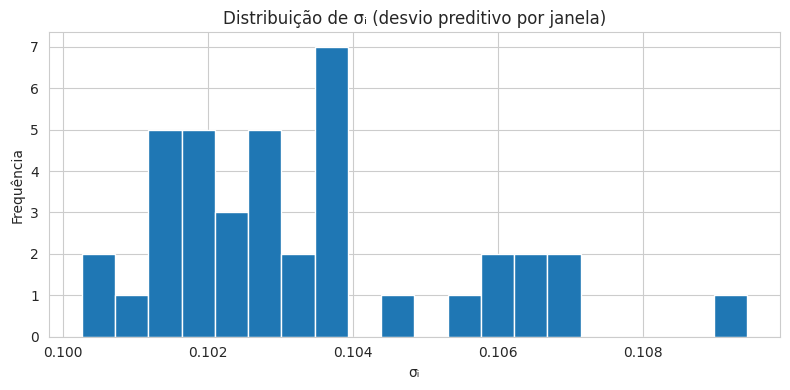

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'sigs' has already been generated in the previous cell as a numpy array
# If not yet in scope, recalculate by calling forecast_stats for each window

# 1. Summary statistics
# Calculate descriptive statistics for the 'sigs' array, including min, quartiles, and max.
desc = pd.Series(sigs).describe(percentiles=[0.25, 0.5, 0.75])
print("🔍 Estatísticas de σᵢ por janela:")
# Print a subset of the descriptive statistics: min, 25th percentile, median (50th), 75th percentile, and max.
print(desc[["min", "25%", "50%", "75%", "max"]])

# 2. Histogram of σᵢ distribution
plt.figure(figsize=(8, 4)) # Create a new figure for the histogram with specified dimensions.
plt.hist(sigs, bins=20) # Plot a histogram of the 'sigs' array with 20 bins.
plt.title("Distribuição de σᵢ (desvio preditivo por janela)") # Set the title of the histogram.
plt.xlabel("σᵢ") # Set the x-axis label.
plt.ylabel("Frequência") # Set the y-axis label.
plt.tight_layout() # Adjust plot parameters for a tight layout.
plt.show() # Display the histogram.

## One-Step-Ahead Residuals Diagnostics
---
This cell performs diagnostic analysis on the one-step-ahead residuals from the walk-forward predictions. It calculates the residuals (actual minus predicted values), visualizes their time series to check for patterns, and then plots the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to identify any remaining serial correlation in the errors.

| Name      | Description                                                                  |
| :-------- | :--------------------------------------------------------------------------- |
| `PRED_PARQ` | Path to the Parquet file containing walk-forward predictions and confidence intervals. |
| `pred_df` | DataFrame containing walk-forward predictions, actual values, and calculated residuals. |

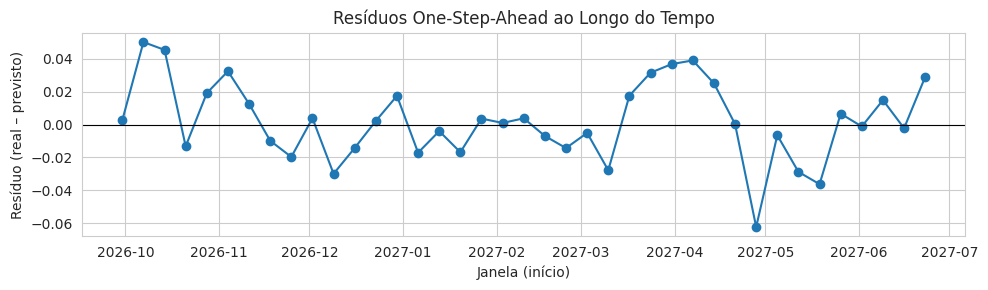

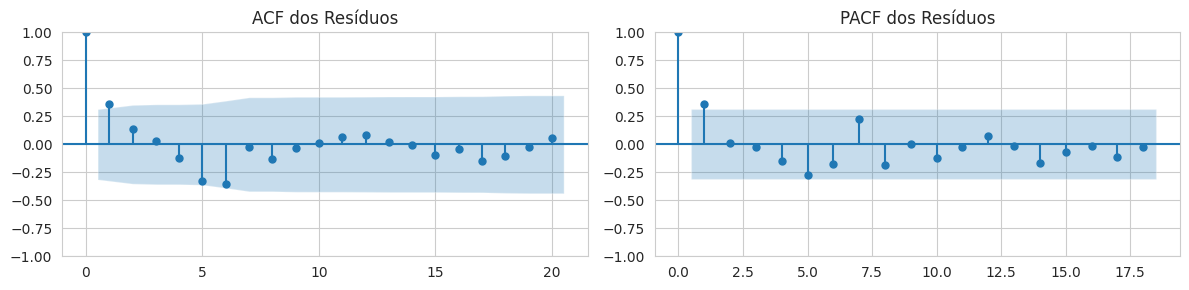

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path

# 1) Load walk-forward generated predictions
PRED_PARQ = Path("walk_preds_ic95_calibrated.parquet") # Path to the Parquet file containing walk-forward predictions
pred_df = pd.read_parquet(PRED_PARQ) # Load the predictions DataFrame

# 2) Calculate residuals
pred_df["residual"] = pred_df["slope_real"] - pred_df["pred_mean"] # Calculate residuals (actual - predicted)

# 3) Plot residual series
plt.figure(figsize=(10, 3)) # Create a new figure for the time series plot of residuals
plt.plot(pred_df["window_start"], pred_df["residual"], marker="o", ls="-") # Plot residuals against window start date
plt.axhline(0, color="k", lw=0.8) # Add a horizontal line at y=0 for reference
plt.title("Resíduos One-Step-Ahead ao Longo do Tempo") # Set the plot title
plt.xlabel("Janela (início)") # Set the x-axis label
plt.ylabel("Resíduo (real – previsto)") # Set the y-axis label
plt.tight_layout() # Adjust plot parameters for a tight layout
plt.show() # Display the plot

# 4) Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 3)) # Create a figure and a grid of 1 row, 2 columns for subplots
plot_acf(pred_df["residual"], lags=20, ax=axes[0], title="ACF dos Resíduos") # Plot Autocorrelation Function (ACF) of residuals
plot_pacf(pred_df["residual"], lags=18, ax=axes[1], title="PACF dos Resíduos") # Plot Partial Autocorrelation Function (PACF) of residuals
plt.tight_layout() # Adjust plot parameters for a tight layout
plt.show() # Display the plots

## Feature Histograms and Normality Tests *
---
This cell, as part of the "Feature Histograms and Normality Tests" Canvas, loads the filtered feature data and performs two key diagnostic steps. It first generates and displays histograms for each feature to visually assess their distributions. Following this, it conducts D'Agostino's K^2 normality tests for each feature, providing statistical insights into whether their distributions deviate significantly from a normal distribution.

This cell does not create any new DataFrames, files, or Parquet files as outputs.

Generating histograms for all features...


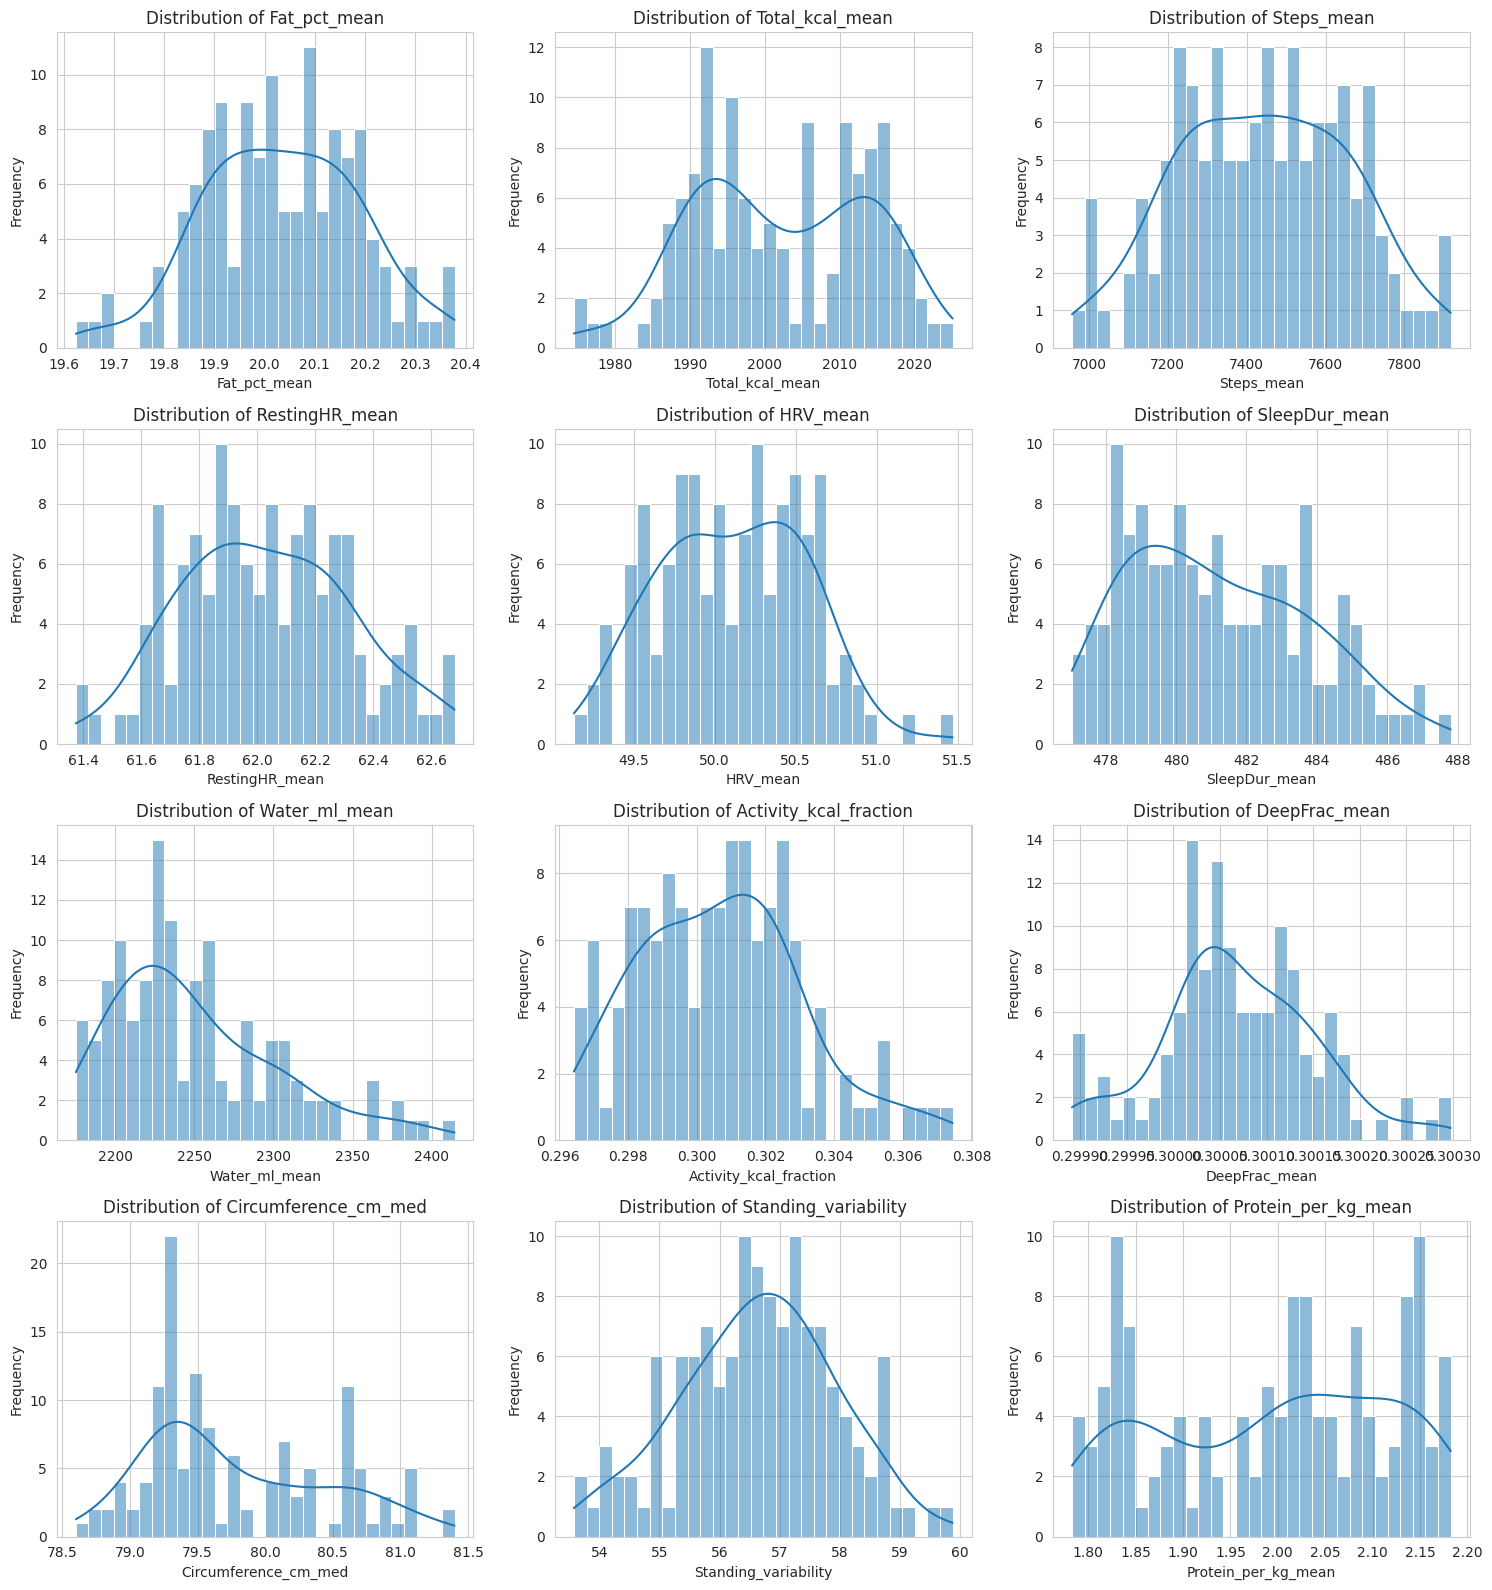

Histograms generated.

Performing D'Agostino's K^2 Normality Test for all features:
------------------------------------------------------------
Feature: Fat_pct_mean                   | Statistic: 0.266 | P-value: 0.876 | Normal: Yes (Fail to reject H0)
Feature: Total_kcal_mean                | Statistic: 15.905 | P-value: 0.000 | Normal: No (Reject H0)
Feature: Steps_mean                     | Statistic: 4.275 | P-value: 0.118 | Normal: Yes (Fail to reject H0)
Feature: RestingHR_mean                 | Statistic: 2.422 | P-value: 0.298 | Normal: Yes (Fail to reject H0)
Feature: HRV_mean                       | Statistic: 1.422 | P-value: 0.491 | Normal: Yes (Fail to reject H0)
Feature: SleepDur_mean                  | Statistic: 9.101 | P-value: 0.011 | Normal: No (Reject H0)
Feature: Water_ml_mean                  | Statistic: 17.033 | P-value: 0.000 | Normal: No (Reject H0)
Feature: Activity_kcal_fraction         | Statistic: 4.319 | P-value: 0.115 | Normal: Yes (Fail to reject H0)


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

# --- Configuration ---
# Path to the filtered window data, which contains the features after collinearity filtering.
FILTERED_PARQUET = Path("janelas_91d_filtered.parquet")
TARGET_COL = "slope_kg_per_week"
DATE_COL   = "window_start"

# --- Load Data ---
# Load the filtered window data.
try:
    df_filtered = pd.read_parquet(FILTERED_PARQUET)
except FileNotFoundError:
    # Print an error message if the Parquet file is not found.
    print(f"Error: {FILTERED_PARQUET} not found. Please ensure the previous steps (collinearity filtering) have been run.")
    exit() # Exit the script if the file is missing.

# Identify feature columns by excluding the target and date columns.
feature_cols = [c for c in df_filtered.columns if c not in {TARGET_COL, DATE_COL}]

# --- Generate Histograms ---
print("Generating histograms for all features...")
# Determine the number of rows and columns for the subplot grid based on the number of features.
n_features = len(feature_cols)
n_cols = 3  # Number of columns in the subplot grid
n_rows = (n_features + n_cols - 1) // n_cols # Calculate the number of rows needed to fit all features.

# Create a figure and a grid of subplots for the histograms.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten() # Flatten the 2D array of axes into a 1D array for easier iteration.

# Iterate through each feature column to generate and plot its histogram.
for i, col in enumerate(feature_cols):
    sns.histplot(df_filtered[col], kde=True, ax=axes[i], bins=30) # Plot histogram with Kernel Density Estimate.
    axes[i].set_title(f'Distribution of {col}') # Set the title for the current subplot.
    axes[i].set_xlabel(col) # Set the x-axis label.
    axes[i].set_ylabel('Frequency') # Set the y-axis label.

# Hide any unused subplots if the number of features is not a perfect multiple of n_cols.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjust subplot parameters for a tight layout, preventing labels from overlapping.
plt.show() # Display the generated histograms.
print("Histograms generated.")

# --- Perform Normality Tests (D'Agostino's K^2 Test) ---
print("\nPerforming D'Agostino's K^2 Normality Test for all features:")
print("-" * 60)
alpha = 0.05 # Define the significance level for the normality test.

results = {} # Dictionary to store the normality test results for each feature.
for col in feature_cols:
    data = df_filtered[col].dropna() # Drop NaN values from the feature data before performing the test.
    if len(data) < 20: # Check if there are enough data points; D'Agostino's K^2 test typically requires at least 20 samples.
        print(f"Warning: Not enough data points for {col} ({len(data)} samples). Skipping normality test.")
        results[col] = {"statistic": np.nan, "p_value": np.nan, "normal": "N/A (Insufficient Data)"}
        continue

    # Perform D'Agostino's K^2 test for normality.
    # Returns: statistic (float), pvalue (float).
    k2, p_value = stats.normaltest(data)

    # Determine if the data is considered normal based on the p-value and alpha.
    is_normal = "Yes (Fail to reject H0)" if p_value > alpha else "No (Reject H0)"

    # Store the test results in the dictionary.
    results[col] = {
        "statistic": k2,
        "p_value": p_value,
        "normal": is_normal
    }
    # Print the results for the current feature.
    print(f"Feature: {col:<30} | Statistic: {k2:.3f} | P-value: {p_value:.3f} | Normal: {is_normal}")

print("-" * 60)
print("\nInterpretation:")
print(f"For each feature, the D'Agostino's K^2 test checks if the data comes from a normal distribution.")
print(f"The null hypothesis (H0) is that the data is normally distributed.")
print(f"If P-value > {alpha} (our significance level), we fail to reject H0, suggesting the data is likely normal.")
print(f"If P-value <= {alpha}, we reject H0, suggesting the data is not normally distributed.")


## Approximate PIT Histogram Calculation and Plot (Normal CDF Approximation)
---
This cell calculates the approximate Probability Integral Transform (PIT) values for each one-step-ahead forecast in the walk-forward validation. It uses the Cumulative Distribution Function (CDF) of a Normal distribution, parameterized by the predicted mean and standard deviation for each forecast. The cell then visualizes the distribution of these approximate PIT values using a histogram, which helps assess the calibration of the predictive distributions.

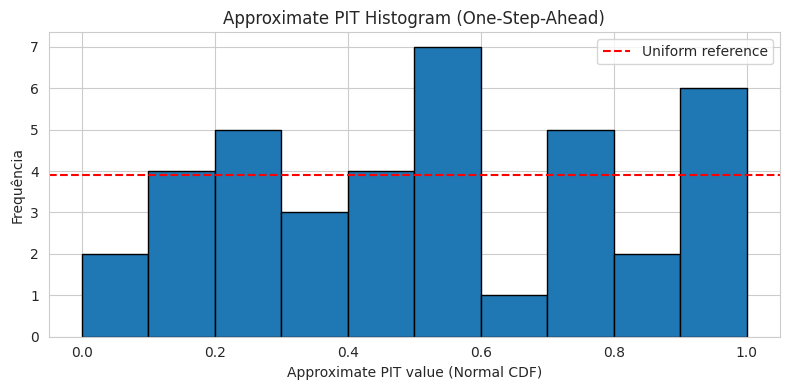


✅ Approximate PIT histogram generated.


In [51]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats # Import scipy.stats for Normal CDF

# Path configurations (using the calibrated predictions file)
PRED_PARQ = Path("walk_preds_ic95_calibrated.parquet") # Path to the calibrated predictions Parquet file

# Load predictions and actual values data
try:
    pred_df = pd.read_parquet(PRED_PARQ) # Loads the predictions DataFrame
    if pred_df.empty:
        print(f"Warning: {PRED_PARQ} is empty. Cannot compute PIT histogram.")
except FileNotFoundError:
    print(f"Error: {PRED_PARQ} not found. Please ensure the walk-forward with calibration step was run successfully.")
    pred_df = None # Set to None to prevent further errors

if pred_df is not None and not pred_df.empty:
    # Extract predictions (mean, IC95) and actual values
    pred_mean = pred_df["pred_mean"].values # Extracts predicted mean values
    pred_lo95 = pred_df["pred_lo95"].values # Extracts lower bound of 95% confidence interval
    pred_hi95 = pred_df["pred_hi95"].values # Extracts upper bound of 95% confidence interval
    real_values = pred_df["slope_real"].values # Extracts actual (real) target values

    # Calculate predictive standard deviation from IC95 (assuming Normality)
    # For a 95% CI of a Normal, the distance between the upper limit and the mean
    # is approximately 1.96 * stddev.
    # stddev = (pred_hi95 - pred_mean) / 1.96  or (pred_hi95 - pred_lo95) / (2 * 1.96)
    # We will use the second form for greater robustness
    # Calculates the predictive standard deviation from the 95% confidence interval, assuming normality.
    # For a 95% CI of a Normal distribution, the distance from the mean to the upper bound is approx. 1.96 * stddev.
    # Using the full width of the CI (hi - lo) divided by (2 * 1.96) for robustness.
    pred_stddev = (pred_hi95 - pred_lo95) / (2 * stats.norm.ppf(0.975)) # Uses ppf(0.975) for the 97.5th percentile of a standard normal distribution

    # Calculate approximate PIT using Normal CDF
    # PIT = P(X <= real_value | X ~ N(pred_mean, pred_stddev^2))
    # Equivalent to stats.norm.cdf(real_value, loc=pred_mean, scale=pred_stddev)
    # Calculates the approximate Probability Integral Transform (PIT) value for each observation.
    # This is done by evaluating the CDF of a Normal distribution (with the predicted mean and stddev) at the actual observed value.
    approx_pits = stats.norm.cdf(real_values, loc=pred_mean, scale=pred_stddev)

    # Plot PIT histogram
    plt.figure(figsize=(8,4)) # Creates a new figure for the PIT histogram
    plt.hist(approx_pits, bins=10, range=(0,1), edgecolor='black') # Plots the histogram of approximate PIT values
    plt.title("Approximate PIT Histogram (One-Step-Ahead)") # Sets the title of the plot
    plt.xlabel("Approximate PIT value (Normal CDF)") # Sets the x-axis label
    plt.ylabel("Frequência") # Sets the y-axis label
    plt.axhline(len(approx_pits)/10, color='red', linestyle='--', label="Uniform reference") # Adds a horizontal line representing the expected frequency for a uniform distribution
    plt.legend() # Displays the legend
    plt.tight_layout() # Adjusts plot parameters for a tight layout
    plt.show() # Displays the plot

    print("\n✅ Approximate PIT histogram generated.")
else:
    print("\nSkipping PIT histogram generation due to missing or empty prediction data.")

## Reliability Diagram in Fine Bins
---
This cell generates a Reliability Diagram to assess the calibration of the predictive confidence intervals. It recalculates the actual coverage for various nominal coverage probabilities (in 5% bins) using the calibrated 95% confidence interval results from the walk-forward validation. The diagram plots the actual coverage against the nominal coverage, with an ideal calibration line for comparison.

| Name      | Description                                                                  |
| :-------- | :--------------------------------------------------------------------------- |
| `pred_df` | DataFrame containing walk-forward predictions, actual values, and confidence intervals. |

🧮  Calculando cobertura real por bin…


Bins: 100%|██████████| 20/20 [00:00<00:00, 6540.82it/s]


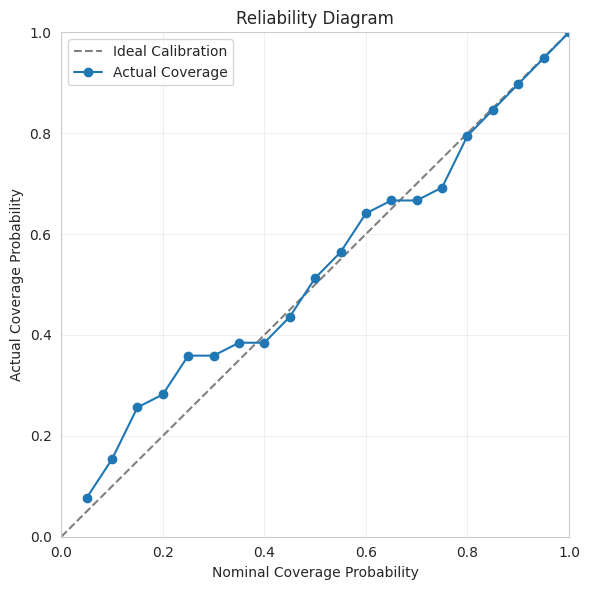


✅ Reliability Diagram generated.


In [52]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats

# Configurações de caminho (usando o arquivo de previsões calibradas)
PRED_PARQ = Path("walk_preds_ic95_calibrated.parquet") # Path to the calibrated predictions Parquet file

# Carrega dados de previsões e valores reais
try:
    pred_df = pd.read_parquet(PRED_PARQ) # Loads the predictions DataFrame
    if pred_df.empty:
        print(f"Warning: {PRED_PARQ} is empty. Cannot compute Reliability Diagram.")
except FileNotFoundError:
    print(f"Error: {PRED_PARQ} not found. Please ensure the walk-forward with calibration step was run successfully.")
    pred_df = None # Set to None to prevent further errors

if pred_df is not None and not pred_df.empty:
    # Extrai previsões (média, IC95) e valores reais
    pred_mean = pred_df["pred_mean"].values # Extracts predicted mean values
    pred_lo95 = pred_df["pred_lo95"].values # Extracts lower bound of 95% confidence interval
    pred_hi95 = pred_df["pred_hi95"].values # Extracts upper bound of 95% confidence interval
    real_values = pred_df["slope_real"].values # Extracts actual (real) target values

    # Recalcula o desvio-padrão preditivo a partir do IC95 calibrado (assumindo Normalidade)
    # Usando o z_calibrado obtido anteriormente
    # Recalculates the predictive standard deviation from the calibrated 95% CI (assuming Normality).
    # This assumes z_calibrated is available in the global scope from the calibration cell.
    if 'z_cal' not in globals():
         # Fallback: Recalculate z_calibrated if not in globals (less ideal, assumes same data).
         # This part is just a fallback; ideally, z_cal should be available.
         print("Warning: z_calibrated not found in global scope. Recalculating...")
         mus = pred_df["pred_mean"].values
         sigs_from_95 = (pred_df["pred_hi95"].values - pred_df["pred_lo95"].values) / (2 * stats.norm.ppf(0.975))
         reals = pred_df["slope_real"].values

         zs = np.linspace(1.0, 2.5, 151)
         coverages = []
         for z in zs:
             lo = mus - z * sigs_from_95
             hi = mus + z * sigs_from_95
             cov = np.mean((reals >= lo) & (reals <= hi))
             coverages.append(cov)
         coverages = np.array(coverages)
         target = 0.95
         idx = np.argmin(np.abs(coverages - target))
         z_cal = zs[idx]
         print(f'Recalculated z_calibrated = {z_cal:.2f}')

    # Use the calibrated standard deviation for all intervals
    # Calculates the calibrated predictive standard deviation using the 95% CI width and the corresponding Z-score for 95% (1.96).
    pred_stddev_calibrated = (pred_hi95 - pred_lo95) / (2 * stats.norm.ppf(0.975)) # Using the original 95% z for stddev base

    # Define bins of nominal coverage (e.g., 5% to 100% in 5% increments)
    nominal_coverages = np.linspace(0.05, 1.0, 20) # Creates an array of nominal coverage probabilities from 5% to 100%
    actual_coverages = [] # List to store the actual coverage probabilities for each bin

    print("🧮  Calculando cobertura real por bin…")
    # Calculate actual coverage for each nominal coverage bin
    for nominal_cov in tqdm(nominal_coverages, desc="Bins"): # Iterate through each nominal coverage probability with a progress bar
        # Calculate the corresponding z-score for this nominal coverage, assuming a Normal distribution.
        # For a two-sided interval, the tail probability is (1 - nominal_cov) / 2.
        # The quantile to use for ppf is 1 - (1 - nominal_cov) / 2 = (1 + nominal_cov) / 2.
        z_score = stats.norm.ppf((1 + nominal_cov) / 2)

        # Calculate the interval bounds for this nominal coverage using the calibrated standard deviation.
        lower_bound = pred_mean - z_score * pred_stddev_calibrated
        upper_bound = pred_mean + z_score * pred_stddev_calibrated

        # Check how many real values fall within this calculated interval.
        coverage = np.mean((real_values >= lower_bound) & (real_values <= upper_bound))
        actual_coverages.append(coverage) # Append the calculated actual coverage

    # --- Plot Reliability Diagram ---
    plt.figure(figsize=(6, 6)) # Creates a new figure for the Reliability Diagram
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal Calibration') # Plots the ideal calibration line (y=x)
    plt.plot(nominal_coverages, actual_coverages, marker='o', linestyle='-', label='Actual Coverage') # Plots the actual coverage against nominal coverage

    plt.title("Reliability Diagram") # Sets the title of the plot
    plt.xlabel("Nominal Coverage Probability") # Sets the x-axis label
    plt.ylabel("Actual Coverage Probability") # Sets the y-axis label
    plt.grid(True, alpha=0.3) # Adds a grid to the plot for better readability
    plt.legend() # Displays the legend
    plt.xlim([0, 1]) # Sets the x-axis limits from 0 to 1
    plt.ylim([0, 1]) # Sets the y-axis limits from 0 to 1
    plt.tight_layout() # Adjusts plot parameters for a tight layout
    plt.show() # Displays the plot

    print("\n✅ Reliability Diagram generated.")
else:
    print("\nSkipping Reliability Diagram generation due to missing or empty prediction data.")

## Coverage vs. History Size Analysis
---
This cell analyzes the performance of the calibrated 95% confidence intervals by examining their coverage in relation to the amount of historical data used for each forecast. It plots a binary representation of whether the actual value fell within the predicted interval against the increasing size of the historical window, providing insights into how prediction uncertainty might change with more available data.

| Name      | Description                                                                  |
| :-------- | :--------------------------------------------------------------------------- |
| `df_train0` | DataFrame containing the initial training data.                               |
| `df_walk` | DataFrame containing the walk-forward data.                                   |
| `pred_df` | DataFrame containing walk-forward predictions with calibrated intervals.      |

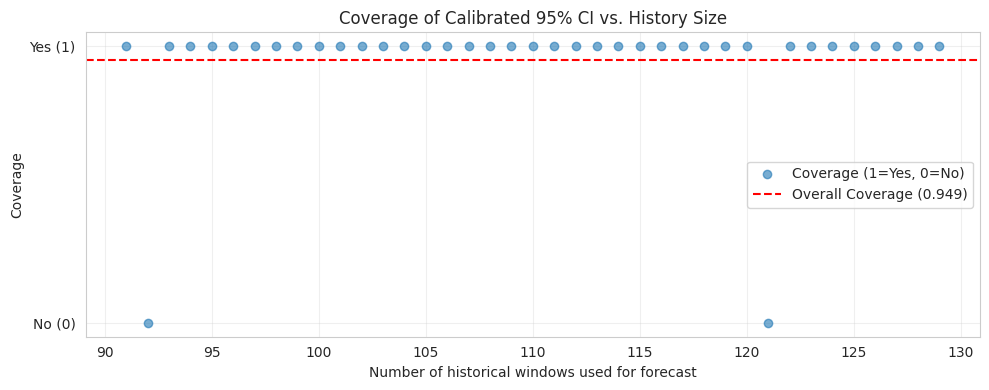


✅ Coverage vs. History Size plot generated.


In [53]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Path configurations
TRAIN_PARQ = Path("train_initial.parquet") # Path to the initial training data Parquet file. Needed to know initial history size.
WALK_PARQ  = Path("walk_forward.parquet")   # Path to the walk-forward data Parquet file. Needed to know walk forward steps.
PRED_PARQ  = Path("walk_preds_ic95_calibrated.parquet") # Path to the predictions with calibrated intervals.

# Load data
try:
    df_train0 = pd.read_parquet(TRAIN_PARQ) # Loads the initial training DataFrame.
    df_walk   = pd.read_parquet(WALK_PARQ)   # Loads the walk-forward DataFrame.
    pred_df   = pd.read_parquet(PRED_PARQ)   # Loads the predictions DataFrame.

    if df_train0.empty or df_walk.empty or pred_df.empty:
         print("Warning: One or more input files are empty. Cannot compute Coverage vs History Size.")
         df_train0, df_walk, pred_df = None, None, None # Set to None to prevent further errors.

except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure {TRAIN_PARQ}, {WALK_PARQ}, and {PRED_PARQ} exist.")
    df_train0, df_walk, pred_df = None, None, None # Set to None to prevent further errors.


if all([df_train0 is not None, df_walk is not None, pred_df is not None]):
    # Determine the size of the initial training set
    initial_train_size = len(df_train0)

    # Calculate history size for each walk-forward step
    # The history size for the i-th step of the walk-forward is initial_train_size + i
    history_sizes = initial_train_size + np.arange(len(df_walk))

    # Extract real values and prediction intervals from the calibrated predictions
    real_values = pred_df["slope_real"].values
    pred_lo95   = pred_df["pred_lo95"].values
    pred_hi95   = pred_df["pred_hi95"].values

    # Determine if the real value falls within the predicted interval for each step (coverage)
    coverage = ((real_values >= pred_lo95) & (real_values <= pred_hi95)).astype(int) # 1 if covered, 0 if not

    # --- Plot Coverage vs History Size ---
    plt.figure(figsize=(10, 4)) # Create a new figure for the plot.
    # Scatter plot: History size on x-axis, Coverage (0 or 1) on y-axis
    plt.scatter(history_sizes, coverage, alpha=0.6, label="Coverage (1=Yes, 0=No)")

    # Optional: Add a line for overall coverage or a moving average
    overall_coverage = np.mean(coverage) # Calculate the overall coverage.
    plt.axhline(overall_coverage, color='red', linestyle='--', label=f'Overall Coverage ({overall_coverage:.3f})') # Add a horizontal line for overall coverage.

    plt.title("Coverage of Calibrated 95% CI vs. History Size") # Set the title of the plot.
    plt.xlabel("Number of historical windows used for forecast") # Set the x-axis label.
    plt.ylabel("Coverage") # Set the y-axis label.
    plt.yticks([0, 1], ["No (0)", "Yes (1)"]) # Make y-axis labels clearer.
    plt.grid(True, alpha=0.3) # Add a grid to the plot.
    plt.legend() # Display the legend.
    plt.tight_layout() # Adjust plot parameters for a tight layout.
    plt.show() # Display the plot.

    print("\n✅ Coverage vs. History Size plot generated.")
else:
    print("\nSkipping Coverage vs. History Size plot generation due to missing or empty data.")

## Prior Sensitivity Analysis
---
This cell performs a sensitivity analysis to evaluate the impact of different hyper-prior scale configurations on the Bayesian Structural Time Series (BSTS) model's performance. It iteratively re-runs the Variational Inference training and walk-forward calibration process for each defined prior configuration, tabulating and displaying the resulting Mean Absolute Error (MAE) and 95% Confidence Interval (IC95%) coverage.

| Name       | Description                                                               |
| :--------- | :------------------------------------------------------------------------ |
| `results_df` | DataFrame tabulating MAE, IC95% Coverage, and calibrated Z-score for each prior configuration. |

In [54]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm # Progress bar library
import json # For loading JSON data
import sys # For system-specific parameters and functions (e.g., sys.exit)
from IPython.display import display # For displaying DataFrames in notebooks

# --- Path Configurations (reused from previous cells) ---
TRAIN_PARQ = Path("train_initial.parquet") # Path to the initial training data Parquet file
WALK_PARQ  = Path("walk_forward.parquet")  # Path to the walk-forward validation data Parquet file
GROUPS_JSON   = Path("feature_groups.json") # Path to the JSON file containing feature group indices. Assuming this was generated in a previous step.
TARGET = 'slope_kg_per_week' # Name of the target variable column
DATE   = 'window_start' # Name of the date column
NUM_DRAWS = 500 # Number of samples to draw from the surrogate posterior for each forecast

# --- Load data (once) ---
try:
    # Load the initial training DataFrame
    df_train0 = pd.read_parquet(TRAIN_PARQ)
    # Load the walk-forward DataFrame
    df_walk   = pd.read_parquet(WALK_PARQ)
    # Identify feature columns by excluding the target and date columns from the training DataFrame
    feature_cols = [c for c in df_train0.columns if c not in {TARGET, DATE}]
    # Convert the observed time series (target variable) to a TensorFlow tensor
    Y = tf.convert_to_tensor(df_train0[TARGET].values, dtype=tf.float32)
    # Convert the exogenous regressors (feature matrix) to a TensorFlow tensor
    X = tf.convert_to_tensor(df_train0[feature_cols].values, dtype=tf.float32)

    # Load feature group indices from the JSON file
    with GROUPS_JSON.open() as f:
        group_indices = json.load(f)

except FileNotFoundError as e:
    # Print an error message if any required data file is not found
    print(f"Error loading data files: {e}. Ensure {TRAIN_PARQ}, {WALK_PARQ}, and {GROUPS_JSON} exist.")
    sys.exit(1) # Exit the script if a file is missing

# --- Trend and offset template (once) ---
# Define a Local Linear Trend component template without observed time series (to be provided at runtime)
trend_template = tfp.sts.LocalLinearTrend(observed_time_series=None)
# Define a constant offset tensor, initialized to 0.0
constant_offset = tf.constant(0.0, dtype=tf.float32)

# --- 1-step forecast function (reused) ---
@tf.function # Decorator to compile the function into a TensorFlow graph for performance
def forecast_stats(y_hist: tf.Tensor, x_hist: tf.Tensor, x_future: tf.Tensor, surrogate_posterior_tfp):
    # Concatenate historical exogenous regressors with the future regressor (for the prediction step)
    X_full = tf.concat([x_hist, x_future], axis=0)
    # Concatenate the historical observed time series with a NaN value for the future point
    y_ext = tf.concat([y_hist, [tf.constant(np.nan, dtype=tf.float32)]], axis=0)
    # Define a Linear Regression component with the full design matrix
    reg = tfp.sts.LinearRegression(design_matrix=X_full, name='HierLinearRegs')
    # Constructs a temporary STS model for this specific forecast step
    model_step = tfp.sts.Sum(
        components=[trend_template, reg],
        observed_time_series=y_ext,
        constant_offset=constant_offset
    )
    # Performs the 1-step forecast using samples from the provided surrogate posterior
    fc = tfp.sts.forecast(
        model_step,
        observed_time_series=y_hist,
        parameter_samples=surrogate_posterior_tfp.sample(NUM_DRAWS), # Uses sampled parameters from VI
        num_steps_forecast=1, # Forecasts one step ahead
        include_observation_noise=True # Includes observation noise in the forecast
    )
    mu = tf.reduce_mean(fc.mean()) # Calculates the mean of the forecast means (μ)
    sigma = tf.reduce_mean(fc.stddev()) # Calculates the mean of the forecast standard deviations (σ)
    return mu, sigma # Returns the aggregated mean and standard deviation

# --- Function to build the model with priors ---
def build_model_with_priors(y_train, x_train, feature_cols, group_indices, group_sigmas):
    # Define the Local Linear Trend component
    trend = tfp.sts.LocalLinearTrend(observed_time_series=y_train)

    prior_scales = [] # List to store the prior scale variables for each feature weight
    for idx in range(len(feature_cols)):
        grp = None
        # Find the group to which the current feature index belongs
        for g, lst in group_indices.items():
            if idx in lst:
                grp = g
                break
        # Get the sigma value for the identified group, or use a default if group not in config
        sigma = group_sigmas.get(grp, 0.05)
        # Name for the prior scale variable based on the group name or feature index
        tau_name = f"tau_{grp}" if grp else f"tau_feature_{idx}"
        # Create a TransformedVariable for the prior scale (tau) for the current feature/group.
        # Softplus bijector ensures the scale is positive.
        tau = tfp.util.TransformedVariable(sigma, tfp.bijectors.Softplus(), name=tau_name)
        prior_scales.append(tau) # Add the created prior scale variable to the list
    # Stack the list of individual prior scale variables into a single tensor
    prior_scale_values = tf.stack(prior_scales)

    # Define the Linear Regression component with hierarchical priors for its weights
    regression = tfp.sts.LinearRegression(
        design_matrix=x_train,
        weights_prior=tfp.distributions.Normal(loc=0., scale=prior_scale_values), # Hierarchical prior on weights
        name="HierLinearRegs"
    )
    # Keep the recalibrated observation noise prior consistent
    obs_noise_prior = tfp.distributions.HalfNormal(scale=0.5)

    # Build the final BSTS model as a sum of the trend and regression components
    model = tfp.sts.Sum(
        components=[trend, regression],
        observed_time_series=y_train,
        observation_noise_scale_prior=obs_noise_prior # Explicit prior for observation noise scale
    )
    return model # Return the constructed model

# --- Function to train VI ---
def train_vi(model_tfp, y_train, num_steps=2000, learning_rate=1e-2, tf_seed=None):
    # Set TensorFlow's random seed for reproducibility if provided
    if tf_seed is not None:
         tf.random.set_seed(tf_seed)
    # Build the factored surrogate posterior distribution for the model parameters
    surrogate_posterior_tfp = tfp.sts.build_factored_surrogate_posterior(model_tfp)
    # Initialize the Adam optimizer with the specified learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Simple trace_fn for loss only
    @tf.function # Decorator to compile the function into a TensorFlow graph for performance
    def train_step():
         # Perform one step of variational inference optimization
         return tfp.vi.fit_surrogate_posterior(
            target_log_prob_fn=model_tfp.joint_distribution(observed_time_series=y_train).log_prob,
            surrogate_posterior=surrogate_posterior_tfp,
            optimizer=optimizer,
            num_steps=1, # Train step by step
            sample_size=1, # Number of samples to draw from the surrogate posterior at each step
         )

    # Run training steps with tqdm progress bar
    print(f"\n🏋️‍  Training VI for {num_steps} steps…")
    for i in tqdm(range(num_steps), desc="VI Training"):
        loss = train_step() # Execute one training step

    return surrogate_posterior_tfp # Return the trained surrogate posterior

# --- Function to run walk-forward and calibrate Z ---
def run_walk_forward_and_calibrate(df_train0, df_walk, feature_cols, target_col, date_col, surrogate_posterior_tfp):
    mus, sigs, reals = [], [], [] # Lists to store means, stds, and actual values
    df_cum = df_train0.copy() # Initialize a cumulative DataFrame with the initial training data

    print("🏃‍♀️  Running walk-forward to collect stats…")
    # Iterate through each row of the walk-forward DataFrame to simulate sequential forecasting
    for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Walk-Forward Stats'):
        y_hist = tf.constant(df_cum[target_col].values, dtype=tf.float32) # Get historical target values as a TensorFlow tensor
        x_hist = tf.constant(df_cum[feature_cols].values, dtype=tf.float32) # Get historical feature values as a TensorFlow tensor
        x_future = tf.constant(row[feature_cols].values[np.newaxis, :], dtype=tf.float32) # Get future feature values as a TensorFlow tensor

        # Call the forecast function to get mean (mu) and standard deviation (sigma) for the current step
        mu_tensor, sigma_tensor = forecast_stats(y_hist, x_hist, x_future, surrogate_posterior_tfp)
        mus.append(float(mu_tensor.numpy())) # Append the numerical mean
        sigs.append(float(sigma_tensor.numpy())) # Append the numerical standard deviation
        reals.append(float(row[target_col])) # Append the actual observed target value
        # Append the current row to the cumulative DataFrame for the next iteration
        df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

    # Convert lists to NumPy arrays for easier numerical operations
    mus = np.array(mus)
    sigs = np.array(sigs)
    reals = np.array(reals)

    # Calibrate z-score
    zs = np.linspace(1.0, 3.0, 201) # Create a grid of z-score values (expanded range)
    coverages = [] # List to store coverage for each z-score
    for z in zs:
        lo = mus - z * sigs # Calculate lower bound of CI
        hi = mus + z * sigs # Calculate upper bound of CI
        cov = np.mean((reals >= lo) & (reals <= hi)) # Calculate actual coverage
        coverages.append(cov) # Store coverage
    coverages = np.array(coverages) # Convert coverages to NumPy array
    target_cov = 0.95 # Desired target coverage
    idx = np.argmin(np.abs(coverages - target_cov)) # Find the index of the z-score closest to target coverage
    z_cal = zs[idx] # Get the calibrated z-score
    calibrated_coverage = coverages[idx] # Get the actual coverage for the calibrated z-score

    # Regather final predictions with calibrated z
    final_mus, final_sigs, final_reals = [], [], [] # Re-collect for MAE and final coverage check
    df_cum = df_train0.copy() # Re-initialize the cumulative DataFrame for final predictions

    print("✨  Generating final predictions with calibrated Z…")
    # Iterate through each row of the walk-forward DataFrame again to generate final predictions
    for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Final Predictions'):
        y_hist = tf.constant(df_cum[target_col].values, dtype=tf.float32) # Get historical target values as a TensorFlow tensor
        x_hist = tf.constant(df_cum[feature_cols].values, dtype=tf.float32) # Get historical feature values as a TensorFlow tensor
        x_future = tf.constant(row[feature_cols].values[np.newaxis, :], dtype=tf.float32) # Get future feature values as a TensorFlow tensor

        # Call the forecast function to get mean (mu) and standard deviation (sigma)
        mu_tensor, sigma_tensor = forecast_stats(y_hist, x_hist, x_future, surrogate_posterior_tfp)
        final_mus.append(float(mu_tensor.numpy())) # Append the numerical mean
        final_sigs.append(float(sigma_tensor.numpy())) # Append the numerical standard deviation
        final_reals.append(float(row[target_col])) # Append the actual observed target value
        # Append the current row to the cumulative DataFrame for the next iteration
        df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

    # Convert lists to NumPy arrays for final metric calculations
    final_mus = np.array(final_mus)
    final_sigs = np.array(final_sigs)
    final_reals = np.array(final_reals)

    # Calculate Mean Absolute Error (MAE)
    mae = np.mean(np.abs(final_mus - final_reals))
    # Calculate final 95% CI bounds using the calibrated z-score
    final_lo95 = final_mus - z_cal * final_sigs
    final_hi95 = final_mus + z_cal * final_sigs
    # Calculate final coverage of the calibrated 95% CI
    final_coverage = np.mean((final_reals >= final_lo95) & (final_reals <= final_hi95))

    return float(mae), float(final_coverage), float(z_cal) # Return MAE, coverage, and calibrated z-score

# --- Define different prior configurations to test ---
# These are dictionaries mapping group name to the scale (sigma) for the hierarchical priors.
PRIOR_CONFIGS = {
    "Config_A": { # Smaller priors (more shrinkage towards zero for weights)
        "comp_corporal":        0.05,
        "gasto_energetico":     0.05,
        "atividade":            0.02,
        "cardio":               0.02,
        "sono":                 0.02,
        "nutrientes":           0.03,
        "ingestao_hidratacao":  0.03,
    },
     "Config_B": { # Default priors (from previous cells, balanced shrinkage)
        "comp_corporal":        0.10,
        "gasto_energetico":     0.10,
        "atividade":            0.05,
        "cardio":               0.05,
        "sono":                 0.05,
        "nutrientes":           0.07,
        "ingestao_hidratacao":  0.07,
    },
    "Config_C": { # Larger priors (less shrinkage, allowing larger weights)
        "comp_corporal":        0.20,
        "gasto_energetico":     0.20,
        "atividade":            0.10,
        "cardio":               0.10,
        "sono":                 0.10,
        "nutrientes":           0.15,
        "ingestao_hidratacao":  0.15,
    },
    # Add more configurations as needed for further sensitivity analysis
}

# --- Loop through configurations ---
results = [] # List to store results for each prior configuration
print("🔬  Starting Prior Sensitivity Analysis…")

# Ensure Determinism for VI training for comparison (Optional but Recommended)
# Use a fixed seed for each run, or a separate seed for each run
VI_TRAINING_SEED = 42 # Fixed seed for reproducible VI training across configurations

for config_name, group_sigmas in PRIOR_CONFIGS.items():
    print(f"\n--- Running config: {config_name} ---")

    # 1. Build model with current priors
    model = build_model_with_priors(Y, X, feature_cols, group_indices, group_sigmas)

    # 2. Train VI
    surrogate_posterior = train_vi(model, Y, tf_seed=VI_TRAINING_SEED)

    # 3. Run Walk-Forward and Calibrate Z
    mae, coverage, z_cal = run_walk_forward_and_calibrate(
        df_train0=df_train0,
        df_walk=df_walk,
        feature_cols=feature_cols,
        target_col=TARGET,
        date_col=DATE,
        surrogate_posterior_tfp=surrogate_posterior
    )

    # 4. Store results
    results.append({
        "Config": config_name,
        "MAE": mae,
        "IC95_Coverage": coverage,
        "Z_Calibrated": z_cal,
        "Prior_Scales": group_sigmas # Store scales for reference
    })

    print(f"--- Config {config_name} Results: MAE={mae:.3f}, Coverage={coverage:.3f}, Z={z_cal:.2f} ---")


# --- Tabulate and display results ---
results_df = pd.DataFrame(results) # Convert results list to a DataFrame

print("\n📊  Prior Sensitivity Analysis Results:")
# Format the 'Prior_Scales' dictionary into a readable string for display in the DataFrame
results_df['Prior_Scales_Str'] = results_df['Prior_Scales'].apply(
    lambda d: ', '.join([f'{k}:{v:.2f}' for k, v in d.items()])
)
# Display the results DataFrame, rounding specific columns for clarity
display(results_df[['Config', 'MAE', 'IC95_Coverage', 'Z_Calibrated', 'Prior_Scales_Str']].round({'MAE': 3, 'IC95_Coverage': 3, 'Z_Calibrated': 2}))

print("\n✅ Prior Sensitivity Analysis Complete.")

🔬  Starting Prior Sensitivity Analysis…

--- Running config: Config_A ---

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:44<00:00, 19.07it/s]


🏃‍♀️  Running walk-forward to collect stats…


Walk-Forward Stats: 100%|██████████| 39/39 [04:02<00:00,  6.22s/it]


✨  Generating final predictions with calibrated Z…


Final Predictions: 100%|██████████| 39/39 [00:33<00:00,  1.18it/s]


--- Config Config_A Results: MAE=0.017, Coverage=1.000, Z=1.00 ---

--- Running config: Config_B ---

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:37<00:00, 20.45it/s]


🏃‍♀️  Running walk-forward to collect stats…


Walk-Forward Stats: 100%|██████████| 39/39 [04:16<00:00,  6.57s/it]


✨  Generating final predictions with calibrated Z…


Final Predictions: 100%|██████████| 39/39 [00:33<00:00,  1.17it/s]


--- Config Config_B Results: MAE=0.018, Coverage=1.000, Z=1.00 ---

--- Running config: Config_C ---

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:37<00:00, 20.60it/s]


🏃‍♀️  Running walk-forward to collect stats…


Walk-Forward Stats: 100%|██████████| 39/39 [04:01<00:00,  6.19s/it]


✨  Generating final predictions with calibrated Z…


Final Predictions: 100%|██████████| 39/39 [00:54<00:00,  1.40s/it]

--- Config Config_C Results: MAE=0.019, Coverage=1.000, Z=1.00 ---

📊  Prior Sensitivity Analysis Results:


,Config,MAE,IC95_Coverage,Z_Calibrated,Prior_Scales_Str
0,Config_A,0.017,1.0,1.0,"comp_corporal:0.05, gasto_energetico:0.05, ati..."
1,Config_B,0.018,1.0,1.0,"comp_corporal:0.10, gasto_energetico:0.10, ati..."
2,Config_C,0.019,1.0,1.0,"comp_corporal:0.20, gasto_energetico:0.20, ati..."



✅ Prior Sensitivity Analysis Complete.


## MAE and Coverage Over Time
---
This cell visualizes the model's performance metrics (Mean Absolute Error and 95% Confidence Interval Coverage) as they evolve over the walk-forward validation period. It calculates the cumulative MAE and cumulative coverage at each step and plots these metrics against the window start date, providing insights into the stability and consistency of the model's predictions and uncertainty quantification over time.

| Name      | Description                                                                  |
| :-------- | :--------------------------------------------------------------------------- |
| `pred_df` | DataFrame containing walk-forward predictions, actual values, and calculated metrics for temporal analysis. |

📊  Calculating and plotting MAE and Coverage over time…


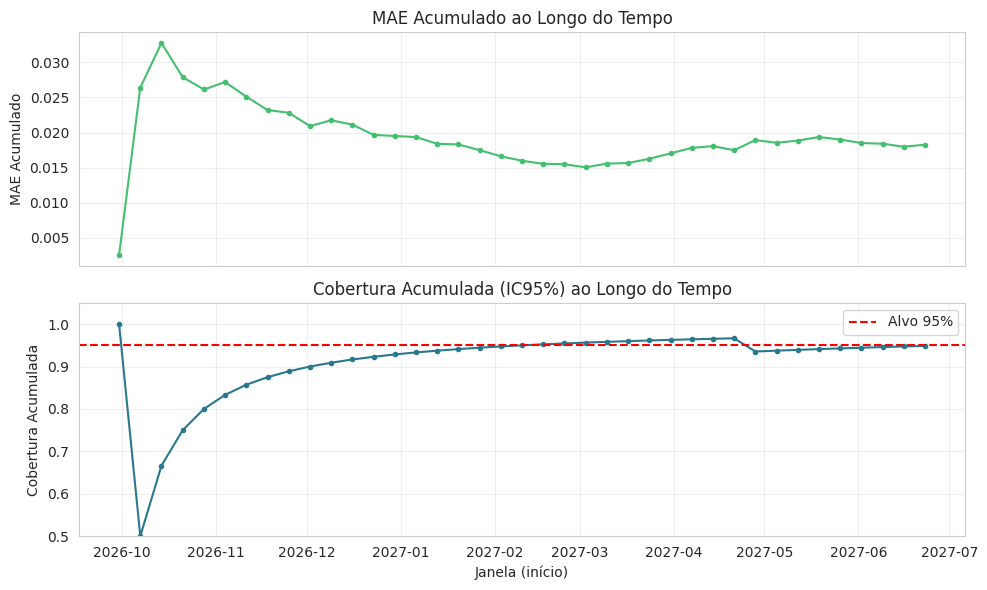


✅ Plots de MAE e Cobertura Acumulados gerados.


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl # Import matplotlib for colormaps
from pathlib import Path

# Calculate and plot MAE and Coverage over time
print("📊  Calculating and plotting MAE and Coverage over time…")

# Make sure pred_df from the walk-forward step is available
# If not, you need to re-run the walk-forward steps to get it.
# Assuming pred_df exists and contains:
# "window_start", "pred_mean", "pred_lo95", "pred_hi95", "slope_real"

if 'pred_df' not in globals():
    # Attempt to load from the calibrated predictions file if pred_df is not already in global scope
    PRED_PARQ = Path("walk_preds_ic95_calibrated.parquet")
    try:
        pred_df = pd.read_parquet(PRED_PARQ)
        print(f"Loaded predictions from {PRED_PARQ}.")
    except FileNotFoundError:
        print(f"Error: {PRED_PARQ} not found. Cannot plot metrics over time.")
        pred_df = None # Set to None to prevent further execution if file is missing

if pred_df is not None and not pred_df.empty:
    # Sort by date just in case to ensure correct cumulative calculations
    pred_df = pred_df.sort_values("window_start").reset_index(drop=True)

    # Calculate absolute error for each step
    pred_df['abs_error'] = np.abs(pred_df['pred_mean'] - pred_df['slope_real'])

    # Calculate coverage for each step (1 if the real value is within the CI, 0 otherwise)
    pred_df['is_covered'] = ((pred_df['slope_real'] >= pred_df['pred_lo95']) &
                             (pred_df['slope_real'] <= pred_df['pred_hi95'])).astype(int)

    # Calculate cumulative MAE (Mean Absolute Error) using expanding window mean
    pred_df['cumulative_mae'] = pred_df['abs_error'].expanding().mean()
    # Calculate cumulative Coverage using expanding window mean
    pred_df['cumulative_coverage'] = pred_df['is_covered'].expanding().mean()

    # Plotting
    # Create a figure with two subplots arranged vertically, sharing the x-axis
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Plot Cumulative MAE on the first subplot
    axes[0].plot(pred_df['window_start'], pred_df['cumulative_mae'], marker='o', linestyle='-', markersize=3, color=mpl.colormaps.get_cmap("viridis")(0.7))
    axes[0].set_ylabel('MAE Acumulado') # Set y-axis label for MAE plot
    axes[0].set_title('MAE Acumulado ao Longo do Tempo') # Set title for MAE plot
    axes[0].grid(True, alpha=0.3) # Add grid to MAE plot

    # Plot Cumulative Coverage on the second subplot
    axes[1].plot(pred_df['window_start'], pred_df['cumulative_coverage'], marker='o', linestyle='-', markersize=3, color=mpl.colormaps.get_cmap("viridis")(0.4))
    axes[1].set_ylabel('Cobertura Acumulada') # Set y-axis label for Coverage plot
    axes[1].set_title('Cobertura Acumulada (IC95%) ao Longo do Tempo') # Set title for Coverage plot
    axes[1].set_xlabel('Janela (início)') # Set x-axis label for Coverage plot
    axes[1].axhline(0.95, color='red', linestyle='--', label='Alvo 95%') # Add a horizontal line at 95% target coverage
    axes[1].legend() # Display legend for Coverage plot
    axes[1].grid(True, alpha=0.3) # Add grid to Coverage plot
    axes[1].set_ylim([0.5, 1.05]) # Focus the Y-axis around typical coverage values (0.5 to 1.05)

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show() # Display the plots

    print("\n✅ Plots de MAE e Cobertura Acumulados gerados.")

else:
    print("\nSkipping MAE and Coverage over time plots due to missing or empty prediction data.")

## Feature Weight Dynamics
---
This cell aims to visualize the dynamics of feature weights (coefficients) over time. It loads the posterior samples of coefficients obtained from the initial Variational Inference training. While a true "over time" analysis would require saving coefficient posteriors at each step of the walk-forward, this cell provides a simplified view by plotting the distribution (median and interquartile range) of the final coefficients learned from the *initial* training set, giving insight into their relative importance after the first training phase.

| Name      | Description                                                                  |
| :-------- | :--------------------------------------------------------------------------- |
| `coef_df` | DataFrame containing samples of the posterior regression coefficients from the initial training. |

📉  Extracting and plotting feature weights over time…
Loaded coefficients from coef_posterior.parquet.

📊  Plotting distribution of final coefficients from initial training set…


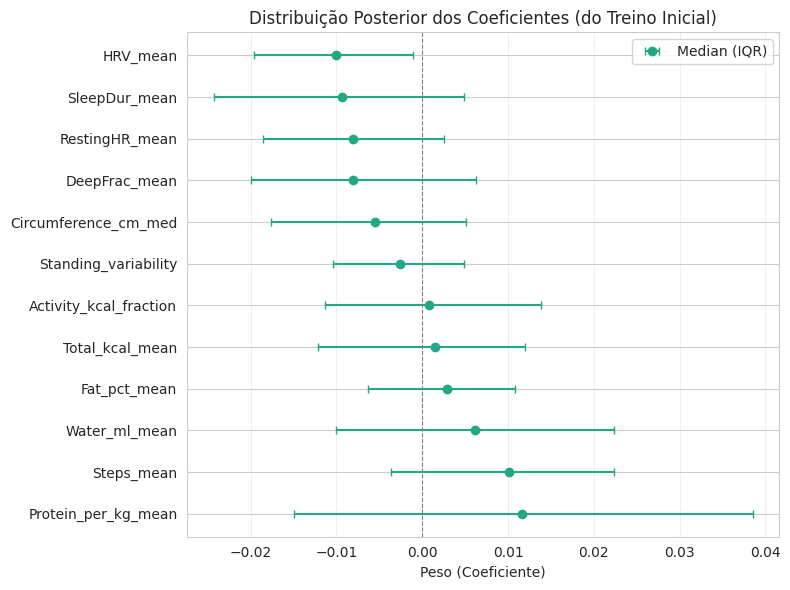


✅ Plot da distribuição dos coeficientes do treino inicial gerado.

Note: Plotting feature importance dynamics over time requires saving posterior samples at each walk-forward step, which was not implemented in the current script structure.
The plot above shows the distribution of coefficients learned from the *initial* training data only.


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl # Import matplotlib for colormaps
from pathlib import Path

# Extracting and plotting feature weights over time.
print("📉  Extracting and plotting feature weights over time…")

# Make sure coef_posterior.parquet from VI diagnostics is available
# If not, you need to re-run VI training and sampling steps (3a, 3b, 3c).
COEF_PATH = Path("coef_posterior.parquet") # Path to the Parquet file containing posterior coefficients.

if not COEF_PATH.exists():
    print(f"Error: {COEF_PATH} not found. Cannot plot feature importance dynamics.")
else:
    try:
        coef_df = pd.read_parquet(COEF_PATH) # Load the coefficients DataFrame.
        print(f"Loaded coefficients from {COEF_PATH}.")
    except Exception as e:
        print(f"Error loading coefficients from {COEF_PATH}: {e}")
        coef_df = None # Set to None to prevent further errors if loading fails.

    # Assuming df_walk is available and sorted chronologically
    if 'df_walk' not in globals() or df_walk.empty:
        print("Warning: df_walk not found or is empty. Cannot associate coefficients with time windows.")
        print("Skipping plotting feature importance dynamics.")
        df_walk = None
    elif coef_df is not None:
        # The coefficients represent the weights learned from the *entire* training set
        # up to that point in the walk-forward.
        # We need to associate these coefficients with the *start date* of the window
        # for which they were used to make a prediction.
        # The surrogate_posterior.sample(NUM_DRAWS) gave us 1000 samples of the *final*
        # weights learned from the *initial train set* (df_train0).
        # To see dynamics *over time*, we would ideally need to save the posterior
        # samples at *each step* of the walk-forward. This is computationally intensive
        # and was not implemented in the `run_walk_forward_and_calibrate` function.

        # A simplified approach is to plot the distribution (e.g., median and IQR)
        # of the final posterior weights learned from the initial training set.
        # This shows the relative importance *after* the first training phase,
        # not how importance changed during the walk-forward.

        # Plotting distribution of final coefficients from the initial training set.
        print("\n📊  Plotting distribution of final coefficients from initial training set…")

        if coef_df is not None and not coef_df.empty:
            # Calculate median and Interquartile Range (IQR) for each coefficient.
            coef_summary = coef_df.describe(percentiles=[0.25, 0.5, 0.75]).T
            coef_summary['IQR'] = coef_summary['75%'] - coef_summary['25%']
            coef_summary = coef_summary.sort_values('50%', ascending=False) # Sort coefficients by their median weight in descending order.

            plt.figure(figsize=(8, 6)) # Create a new figure for the plot.
            y_pos = np.arange(len(coef_summary)) # Create an array for y-axis positions.
            medians = coef_summary['50%'].values # Get the median values of the coefficients.
            # Calculate the lower and upper errors for the error bars based on IQR.
            errors = [medians - coef_summary['25%'].values, coef_summary['75%'].values - medians]

            # Plot median and IQR as error bars.
            plt.errorbar(medians, y_pos, xerr=errors, fmt='o', capsize=3, label='Median (IQR)', color=mpl.colormaps.get_cmap("viridis")(0.6))
            plt.yticks(y_pos, coef_summary.index) # Set y-axis ticks and labels to feature names.
            plt.axvline(0, color='grey', linestyle='--', lw=0.8) # Add a vertical line at 0 for reference.
            plt.xlabel("Peso (Coeficiente)") # Set the x-axis label.
            plt.title("Distribuição Posterior dos Coeficientes (do Treino Inicial)") # Set the plot title.
            plt.grid(axis='x', alpha=0.3) # Add a horizontal grid.
            plt.legend() # Display the legend.
            plt.tight_layout() # Adjust plot parameters for a tight layout.
            plt.show() # Display the plot.

            print("\n✅ Plot da distribuição dos coeficientes do treino inicial gerado.")


        # To genuinely plot "importance over time", we would need to re-run
        # the walk-forward and sample/save the posterior at each step.
        # This is a more advanced analysis and would require modifying the walk-forward logic.

        print("\nNote: Plotting feature importance dynamics over time requires saving posterior samples at each walk-forward step, which was not implemented in the current script structure.")
        print("The plot above shows the distribution of coefficients learned from the *initial* training data only.")


## Posterior Predictive Check (PPC) with HMC
---
This cell demonstrates a Posterior Predictive Check (PPC) for a Bayesian Structural Time Series (BSTS) model. It begins by generating synthetic time series data, then defines and fits an STS model using Hamiltonian Monte Carlo (HMC) to sample from the posterior distribution of its parameters. Finally, it performs the PPC by generating replicated data from the fitted model and visualizes how well these replicated data compare to the observed data, assessing the model's fit.

This cell does not create any new DataFrames, files, or Parquet files as outputs.

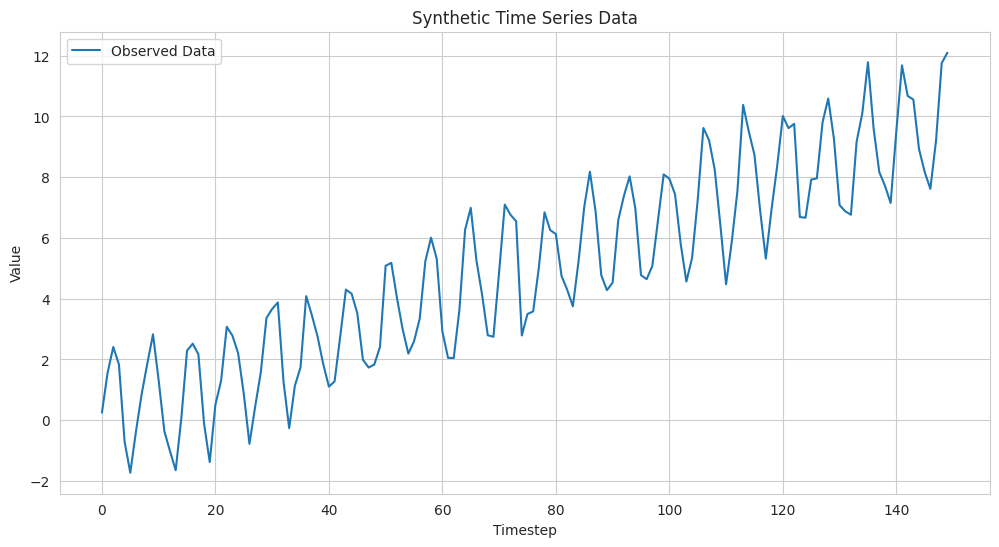

Fitting STS model with HMC...


/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


HMC fitting complete.
Shape of parameter samples: (200,)
Generating posterior predictive samples...
Shape of posterior predictive samples: (100, 150)


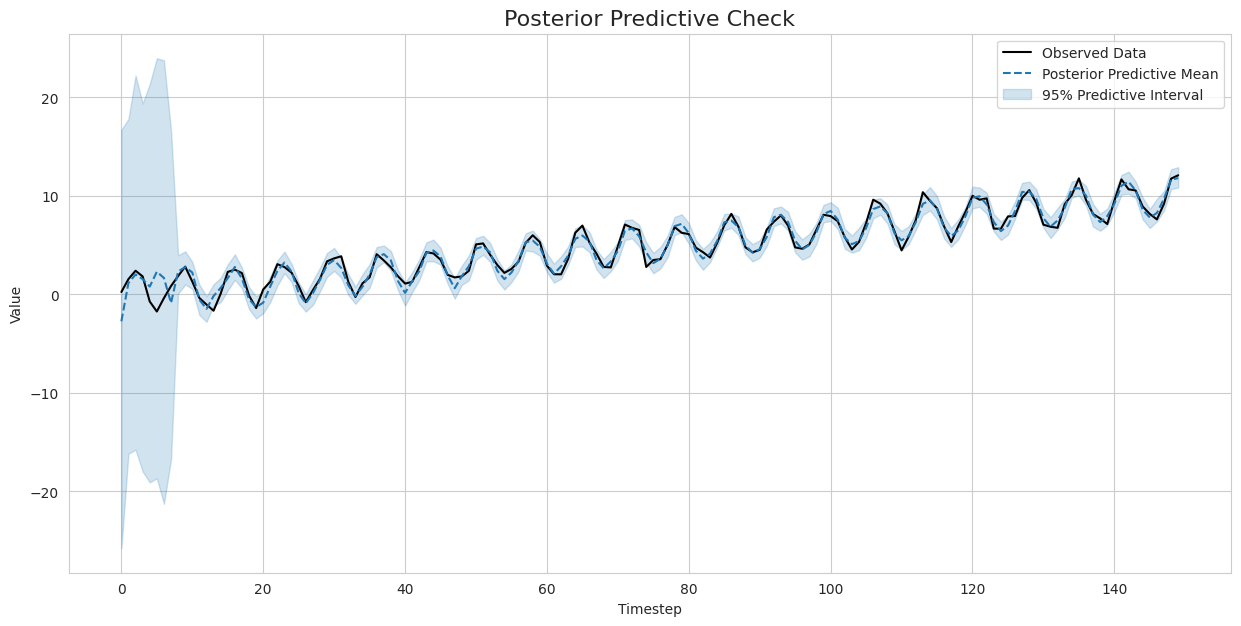

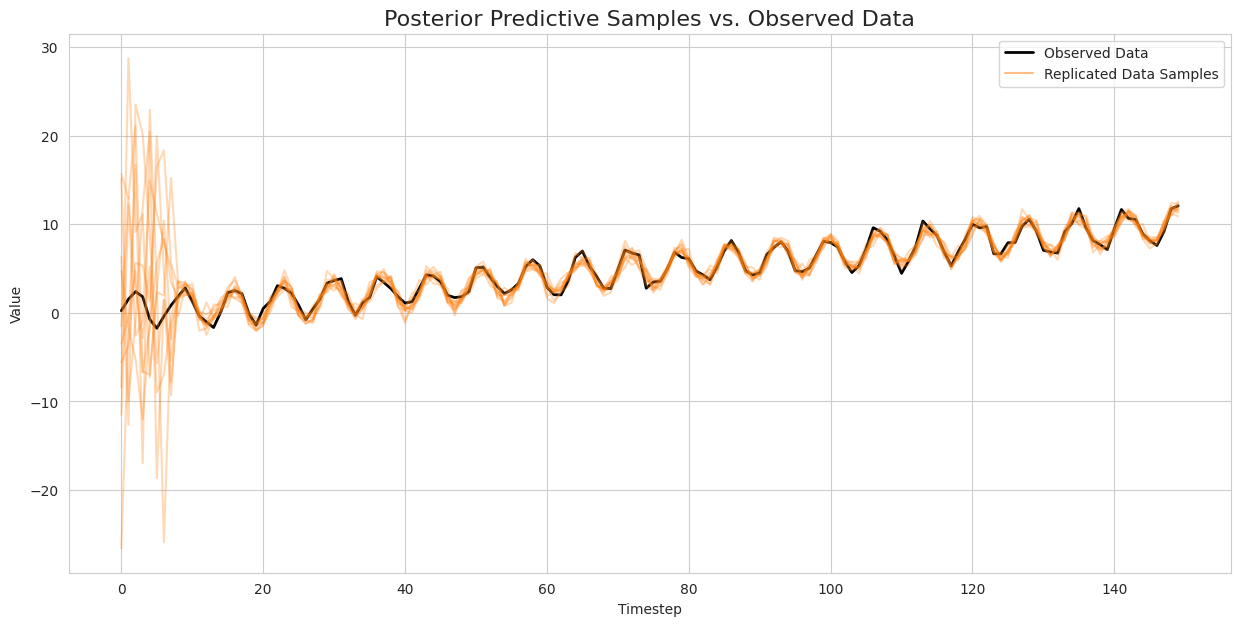

In [57]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn for better plot aesthetics
sns.set_style("whitegrid")

# For reproducibility, set random seeds for TensorFlow and NumPy.
tf.random.set_seed(42)
np.random.seed(42)

# --- 1. Generate Synthetic Time Series Data ---
# Let's create a time series with a linear trend and weekly seasonality.
num_timesteps = 150 # Define the number of time steps for the synthetic series.
observed_series = (
    tf.linspace(0., 10., num_timesteps) +  # Linear trend component: values increasing linearly over time.
    np.sin(2 * np.pi * np.arange(num_timesteps) / 7.) * 2.  # Weekly seasonality component: a sine wave repeating every 7 timesteps.
    + np.random.normal(scale=0.5, size=num_timesteps)  # Noise component: random values drawn from a normal distribution.
)
observed_series = tf.cast(observed_series, dtype=tf.float32) # Cast the series to float32 TensorFlow tensor.

# Plot the generated data to visualize its components.
plt.figure(figsize=(12, 6)) # Create a figure with a specified size.
plt.plot(observed_series, label="Observed Data") # Plot the observed time series.
plt.title("Synthetic Time Series Data") # Set the title of the plot.
plt.xlabel("Timestep") # Set the x-axis label.
plt.ylabel("Value") # Set the y-axis label.
plt.legend() # Display the legend.
plt.show() # Show the plot.


# --- 2. Define the Structural Time Series (STS) Model ---
# We'll define a model that matches the data-generating process:
# a linear trend component and a seasonal component.
def build_sts_model(data):
    """Builds an STS model.

    Args:
      data: A `tf.Tensor` representing the observed time series.

    Returns:
      An instance of `tfp.sts.Sum`.
    """
    # Component for the underlying trend: Local Linear Trend allows for a changing slope and level.
    trend = tfp.sts.LocalLinearTrend(observed_time_series=data, name='trend')

    # Component for weekly seasonality: Models periodic patterns with a cycle length of 7.
    seasonal = tfp.sts.Seasonal(
        num_seasons=7, observed_time_series=data, name='seasonal')

    # The final model is the sum of the components: combines the trend and seasonal effects.
    model = tfp.sts.Sum(components=[trend, seasonal],
                        observed_time_series=data)
    return model # Return the constructed STS model.

sts_model = build_sts_model(observed_series) # Build the STS model using the observed synthetic data.


# --- 3. Fit the Model using Hamiltonian Monte Carlo (HMC) ---
# We use HMC to sample from the posterior distribution of the model's parameters.
# This gives us a set of plausible parameter values given the data.

print("Fitting STS model with HMC...")
# The `fit_with_hmc` function is a convenient wrapper for this process.
# num_results should be large enough for stable estimates of the posterior.
# num_warmup_steps are steps to discard while the sampler converges (burn-in period).
parameter_samples, kernel_results = tfp.sts.fit_with_hmc(
    model=sts_model, # The STS model to fit.
    observed_time_series=observed_series, # The data to fit the model to.
    num_results=200, # Number of post-warmup samples to collect.
    num_warmup_steps=50, # Number of warmup steps to run before collecting samples.
    seed=42) # Random seed for reproducibility.

print("HMC fitting complete.")
# Print the shape of one of the collected parameter samples (e.g., the first parameter's samples).
print(f"Shape of parameter samples: {parameter_samples[0].shape}")


# --- 4. Perform the Posterior Predictive Check (PPC) ---
# The core idea of PPC is to generate new data from the model using the
# parameters from the posterior distribution. If the model is a good fit,
# the generated data should look similar to the observed data.

# In TFP v0.25.0, you use `tfp.sts.one_step_predictive` to get the
# predictive distribution over the observed data points.
print("Generating posterior predictive samples...")
# `one_step_predictive` computes the one-step-ahead predictive distribution for each time point.
predictive_dist = tfp.sts.one_step_predictive(
    model=sts_model, # The fitted STS model.
    observed_time_series=observed_series, # The observed data.
    parameter_samples=parameter_samples) # The posterior samples of parameters obtained from HMC.

# Now, we sample from this predictive distribution to get our "replicated" data.
# We'll generate a number of replicated datasets equal to the number of HMC samples.
num_samples = 100 # Number of replicated datasets to generate.
posterior_predictive_samples = predictive_dist.sample(num_samples, seed=42) # Sample from the predictive distribution.

# The shape will be [num_samples, num_timesteps] where num_samples is the number of replicated series.
print(f"Shape of posterior predictive samples: {posterior_predictive_samples.shape}")


# --- 5. Visualize the Results ---
# A good way to perform a PPC is to plot the observed data along with
# the credible interval of the posterior predictive samples.

# Calculate the mean of the posterior predictive samples across all replicated datasets.
predicted_mean = tf.reduce_mean(posterior_predictive_samples, axis=0)
# Calculate the 2.5th percentile (lower bound of 95% credible interval) for each timestep.
predicted_lower = tfp.stats.percentile(posterior_predictive_samples, 2.5, axis=0)
# Calculate the 97.5th percentile (upper bound of 95% credible interval) for each timestep.
predicted_upper = tfp.stats.percentile(posterior_predictive_samples, 97.5, axis=0)

plt.figure(figsize=(15, 7)) # Create a figure for the plot.
plt.plot(observed_series, 'k', label='Observed Data') # Plot the original observed data in black.
plt.plot(predicted_mean, color='C0', linestyle='--', label='Posterior Predictive Mean') # Plot the mean of the replicated data.
plt.fill_between(
    range(num_timesteps), # X-axis values (timesteps).
    predicted_lower, # Lower bound of the credible interval.
    predicted_upper, # Upper bound of the credible interval.
    color='C0', # Color of the shaded area.
    alpha=0.2, # Transparency of the shaded area.
    label='95% Predictive Interval' # Label for the legend.
)

plt.title("Posterior Predictive Check", fontsize=16) # Set the title of the plot.
plt.xlabel("Timestep") # Set the x-axis label.
plt.ylabel("Value") # Set the y-axis label.
plt.legend() # Display the legend.
plt.show() # Show the plot.

# Another common PPC visualization is to plot a few of the replicated
# datasets directly on top of the observed data to see individual trajectories.
plt.figure(figsize=(15, 7)) # Create another figure.
plt.plot(observed_series, 'k', linewidth=2, label='Observed Data') # Plot the original observed data.

# Plot a few sample trajectories from the posterior predictive samples.
for i in range(min(10, num_samples)): # Iterate up to 10 or `num_samples` (whichever is smaller).
    plt.plot(posterior_predictive_samples[i, :], color='C1', alpha=0.3) # Plot each sample trajectory with some transparency.

# Add a single label for the replicated data samples in the legend.
plt.plot([], [], color='C1', alpha=0.5, label='Replicated Data Samples')

plt.title("Posterior Predictive Samples vs. Observed Data", fontsize=16) # Set the title.
plt.xlabel("Timestep") # Set the x-axis label.
plt.ylabel("Value") # Set the y-axis label.
plt.legend() # Display the legend.
plt.show() # Show the plot.

## Alternative Cross-Validation (Blocking/Rolling Window)
---
This cell implements an alternative cross-validation strategy, to robustly evaluate the model's performance. It divides the combined dataset into temporal blocks, iteratively trains the Bayesian Structural Time Series (BSTS) model (using Variational Inference) on historical data, and then evaluates its performance (MAE and coverage) on the subsequent test block. The metrics are summarized for each fold, providing insights into the model's generalization capabilities across different time periods.

| Name           | Description                                                                  |
| :------------- | :--------------------------------------------------------------------------- |
| `df_full_data` | Combined DataFrame of training and walk-forward data, sorted chronologically, used for cross-validation splitting. |
| `cv_results`   | List of dictionaries, where each dictionary stores the performance metrics and fold details for a specific cross-validation fold. |
| `cv_results_df`| DataFrame summarizing the cross-validation results across all folds.         |

In [58]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats # Used for normal distribution functions
import tensorflow as tf # TensorFlow library for numerical computation
import tensorflow_probability as tfp # TensorFlow Probability for STS models
import json # For loading JSON files
import sys # For system-specific parameters and functions (e.g., sys.exit)
from tqdm import tqdm # Progress bar library
from IPython.display import display # For displaying DataFrames in notebooks

print("🧪  Starting Blocking Cross-Validation…")

# --- CV Configurations ---
# We will use a Blocking CV, where each test fold is a window of N steps
# and the training fold is all the history *before* the test window.
# This better simulates the real forecasting scenario.
# We could also do a Rolling Window CV, where the training set grows
# with each fold, similar to walk-forward, but with multiple folds.
# To simplify and demonstrate the concept, we will do a simple Blocking CV.

# Number of folds/test blocks for cross-validation.
N_SPLITS = 5

# Calculate total number of windows by combining initial training and walk-forward data.
TOTAL_WINDOWS = len(df_train0) + len(df_walk) if 'df_train0' in globals() and 'df_walk' in globals() else 0
if TOTAL_WINDOWS == 0:
    print("Error: Training and walk-forward data not loaded. Cannot perform CV.")
else:
    # Calculate the approximate size of each block.
    BLOCK_SIZE = TOTAL_WINDOWS // N_SPLITS
    if BLOCK_SIZE == 0:
        print(f"Error: TOTAL_WINDOWS ({TOTAL_WINDOWS}) is less than N_SPLITS ({N_SPLITS}). Cannot create folds.")
    else:

        # Combine initial training and walk-forward data for CV splitting.
        # Ensure the combined DataFrame is sorted by date for chronological splitting.
        df_full_data = pd.concat([df_train0, df_walk]).sort_values(DATE).reset_index(drop=True)

        # List to store results for each cross-validation fold.
        cv_results = []

        # --- Reuse modeling, VI training, and evaluation functions ---
        # Assumes that the functions `build_model_with_priors`, `train_vi`,
        # and `run_walk_forward_and_calibrate` or parts of them (especially forecast_stats)
        # are defined and available in the global scope from previous cells.
        # Also assumes that `feature_cols`, `TARGET`, `DATE`, `GROUPS_JSON`,
        # `build_model_with_priors`, `train_vi`, `forecast_stats` are available.

        # Ensure required objects from previous steps are available for CV.
        required_cv = ('df_full_data', 'feature_cols', 'TARGET', 'DATE', 'GROUPS_JSON',
                       'build_model_with_priors', 'train_vi', 'forecast_stats')
        missing_cv = [n for n in required_cv if n not in globals() or (isinstance(globals()[n], pd.DataFrame) and globals()[n].empty)]

        if missing_cv:
            print(f"Error: Missing required objects for CV: {missing_cv}")
            print("Please ensure previous cells (loading data, defining model/train functions) were run successfully.")
        else:
             # Load group indices from the JSON file.
            try:
                with GROUPS_JSON.open() as f:
                    group_indices = json.load(f)
            except FileNotFoundError:
                print(f"Error: {GROUPS_JSON} not found. Cannot load feature groups for CV.")
                group_indices = None # Prevent further execution if file is missing

            if group_indices:
                # Use a default prior configuration for CV, e.g., "Config_B" from sensitivity analysis, or define one here.
                DEFAULT_GROUP_SIGMAS = {
                    "comp_corporal":        0.10,
                    "gasto_energetico":     0.10,
                    "atividade":            0.05,
                    "cardio":               0.05,
                    "sono":                 0.05,
                    "nutrientes":           0.07,
                    "ingestao_hidratacao":  0.07,
                }

                # Deterministic training seed for CV folds (optional, but good for comparison).
                CV_VI_SEED = 123

                print(f"Splitting data into {N_SPLITS} blocks of size approx {BLOCK_SIZE}...")
                # Loop through each fold for cross-validation.
                for fold_idx in range(N_SPLITS):
                    print(f"\n--- Processing Fold {fold_idx + 1}/{N_SPLITS} ---")

                    # Define start and end indices for the test block of this fold.
                    test_start_idx = fold_idx * BLOCK_SIZE
                    test_end_idx = min(test_start_idx + BLOCK_SIZE, len(df_full_data))

                    # If the test block is empty or too small, skip this fold.
                    if test_start_idx >= test_end_idx or (test_end_idx - test_start_idx) < 5: # Minimum test size of 5 windows
                         print(f"Skipping fold {fold_idx + 1}: Test block too small or empty.")
                         continue

                    # Define the training data for the current fold (all data before the test block).
                    df_train_fold = df_full_data.iloc[:test_start_idx].copy()
                    # Define the test data for the current fold (the current block).
                    df_test_fold  = df_full_data.iloc[test_start_idx:test_end_idx].copy()

                    if df_train_fold.empty:
                        print(f"Skipping fold {fold_idx + 1}: Training data is empty.")
                        continue

                    print(f"  Train size: {len(df_train_fold)} windows")
                    print(f"  Test size : {len(df_test_fold)} windows")
                    # Print the date range of the test period for this fold.
                    print(f"  Test period: {df_test_fold[DATE].iloc[0].strftime('%Y-%m-%d')} to {df_test_fold[DATE].iloc[-1].strftime('%Y-%m-%d')}")


                    # 1. Build model with priors on the *current training data*
                    # Need to re-normalize features for this fold's training data
                    # (proper CV requires re-fitting scalers on each train fold,
                    # but for simplicity here, we'll use the global scalers or skip re-scaling if data is already globally scaled)
                    # Assuming data is already globally scaled from 04_prepare_model_data.py

                    # Convert training and test data for the current fold to TensorFlow tensors.
                    Y_train_fold = tf.constant(df_train_fold[TARGET].values, dtype=tf.float32)
                    X_train_fold = tf.constant(df_train_fold[feature_cols].values, dtype=tf.float32)
                    Y_test_fold  = df_test_fold[TARGET].values # Keep as numpy for evaluation
                    X_test_fold  = tf.constant(df_test_fold[feature_cols].values, dtype=tf.float32)

                    # Build the BSTS model for the current fold's training data with default priors.
                    model_fold = build_model_with_priors(
                        Y_train_fold, X_train_fold, feature_cols, group_indices, DEFAULT_GROUP_SIGMAS
                    )

                    # 2. Train VI on the current training data for this fold.
                    surrogate_posterior_fold = train_vi(model_fold, Y_train_fold, tf_seed=CV_VI_SEED)

                    # 3. Make predictions on the test fold
                    # We need one-step-ahead predictions for each point in the test fold.
                    # This means feeding the *history* up to the point *before* the test observation.

                    fold_mus, fold_sigs, fold_reals = [], [], [] # Lists to store means, stds, and actuals for this fold.
                    # Start with the end of the training fold as history for sequential prediction.
                    df_cum_fold = df_train_fold.copy()

                    print("  Making one-step-ahead predictions on test fold…")
                    # Iterate through each window in the test fold to make predictions.
                    for test_idx_in_fold in tqdm(range(len(df_test_fold)), desc=f"Fold {fold_idx+1} Preds"):
                         current_test_window_data = df_test_fold.iloc[test_idx_in_fold] # Get the current test window data.

                         # Convert historical and future data to TensorFlow tensors.
                         y_hist_tf = tf.constant(df_cum_fold[TARGET].values, dtype=tf.float32)
                         x_hist_tf = tf.constant(df_cum_fold[feature_cols].values, dtype=tf.float32)
                         x_future_tf = tf.constant(current_test_window_data[feature_cols].values[np.newaxis, :], dtype=tf.float32)

                         # Use the forecast function with the current fold's trained posterior.
                         mu_tensor, sigma_tensor = forecast_stats(
                             y_hist_tf, x_hist_tf, x_future_tf, surrogate_posterior_fold
                         )

                         # Store the prediction mean, standard deviation, and actual value.
                         fold_mus.append(float(mu_tensor.numpy()))
                         fold_sigs.append(float(sigma_tensor.numpy()))
                         fold_reals.append(float(current_test_window_data[TARGET]))

                         # Add the current test window data to the history for the next prediction step.
                         df_cum_fold = pd.concat([df_cum_fold, current_test_window_data.to_frame().T], ignore_index=True)

                    # Convert lists to NumPy arrays for metric calculation.
                    fold_mus = np.array(fold_mus)
                    fold_sigs = np.array(fold_sigs)
                    fold_reals = np.array(fold_reals)

                    # 4. Calibrate Z and calculate metrics for this fold's predictions
                    # Calibrate Z *on this fold's predictions and actuals* or use a global Z?
                    # For proper CV, you'd evaluate coverage at a *fixed* confidence level (e.g., 95%)
                    # or calibrate Z on the *entire* out-of-sample set (less strict CV).
                    # Let's calculate metrics for a fixed 95% CI (z=1.96) and also calculate the optimal Z for this fold.

                    # Calculate metrics at a fixed 95% confidence interval (z approximately 1.96).
                    z_95_fixed = stats.norm.ppf(0.975) # Z-score for a 95% two-sided interval.
                    fold_lo95_fixed = fold_mus - z_95_fixed * fold_sigs # Lower bound of fixed 95% CI.
                    fold_hi95_fixed = fold_mus + z_95_fixed * fold_sigs # Upper bound of fixed 95% CI.
                    # Calculate coverage for the fixed 95% CI.
                    fold_coverage_fixed = np.mean((fold_reals >= fold_lo95_fixed) & (fold_reals <= fold_hi95_fixed))
                    # Calculate Mean Absolute Error for the fold.
                    fold_mae = np.mean(np.abs(fold_mus - fold_reals))

                    # (Optional) Calibrate Z *just for this fold's data*
                    # Define a range of z-scores to search for calibration.
                    zs_fold = np.linspace(1.0, 3.0, 101)
                    coverages_fold = [] # List to store coverages for different z-scores in this fold.
                    for z in zs_fold:
                        lo = fold_mus - z * fold_sigs
                        hi = fold_mus + z * fold_sigs
                        cov = np.mean((fold_reals >= lo) & (fold_reals <= hi))
                        coverages_fold.append(cov)
                    coverages_fold = np.array(coverages_fold) # Convert to NumPy array.
                    target_cov = 0.95 # Desired target coverage for calibration.
                    # Find the z-score that yields coverage closest to the target.
                    idx_fold = np.argmin(np.abs(coverages_fold - target_cov))
                    z_cal_fold = zs_fold[idx_fold] # Calibrated z-score for this fold.
                    calibrated_coverage_fold = coverages_fold[idx_fold] # Actual coverage for the calibrated z-score.

                    print(f"  Fold {fold_idx + 1} Metrics:")
                    print(f"    MAE                     : {fold_mae:.3f}")
                    print(f"    Coverage (Fixed 95%)  : {fold_coverage_fixed:.3f}")
                    print(f"    Z Calibrated for Fold : {z_cal_fold:.2f} (Coverage: {calibrated_coverage_fold:.3f})")


                    # Append the results of the current fold to the cv_results list.
                    cv_results.append({
                        "Fold": fold_idx + 1,
                        "Train_Start": df_train_fold[DATE].iloc[0].strftime('%Y-%m-%d'),
                        "Train_End": df_train_fold[DATE].iloc[-1].strftime('%Y-%m-%d'),
                        "Test_Start": df_test_fold[DATE].iloc[0].strftime('%Y-%m-%d'),
                        "Test_End": df_test_fold[DATE].iloc[-1].strftime('%Y-%m-%d'),
                        "Train_Size": len(df_train_fold),
                        "Test_Size": len(df_test_fold),
                        "MAE": fold_mae,
                        "Coverage_Fixed95": fold_coverage_fixed,
                        "Z_Calibrated_Fold": z_cal_fold,
                        "Coverage_Calibrated_Fold": calibrated_coverage_fold
                    })

                # --- Summarize CV Results ---
                cv_results_df = pd.DataFrame(cv_results) # Convert the list of results to a DataFrame.

                print("\n🔬 Blocking Cross-Validation Summary:")
                # Display the summary DataFrame, rounding numerical columns for better readability.
                display(cv_results_df.round({'MAE': 3, 'Coverage_Fixed95': 3, 'Z_Calibrated_Fold': 2, 'Coverage_Calibrated_Fold': 3}))

                print("\nAverage Metrics Across Folds:")
                # Calculate and print the average of key metrics across all folds.
                print(cv_results_df[['MAE', 'Coverage_Fixed95', 'Z_Calibrated_Fold', 'Coverage_Calibrated_Fold']].mean().round(3))

                print("\n✅ Blocking Cross-Validation Complete.")

🧪  Starting Blocking Cross-Validation…
Splitting data into 5 blocks of size approx 26...

--- Processing Fold 1/5 ---
Skipping fold 1: Training data is empty.

--- Processing Fold 2/5 ---
  Train size: 26 windows
  Test size : 26 windows
  Test period: 2025-07-02 to 2025-12-24

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [00:35<00:00, 55.82it/s]


  Making one-step-ahead predictions on test fold…


Fold 2 Preds: 100%|██████████| 26/26 [02:34<00:00,  5.93s/it]


  Fold 2 Metrics:
    MAE                     : 0.025
    Coverage (Fixed 95%)  : 1.000
    Z Calibrated for Fold : 1.00 (Coverage: 1.000)

--- Processing Fold 3/5 ---
  Train size: 52 windows
  Test size : 26 windows
  Test period: 2025-12-31 to 2026-06-24

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:00<00:00, 33.01it/s]


  Making one-step-ahead predictions on test fold…


Fold 3 Preds: 100%|██████████| 26/26 [02:36<00:00,  6.01s/it]


  Fold 3 Metrics:
    MAE                     : 0.040
    Coverage (Fixed 95%)  : 1.000
    Z Calibrated for Fold : 1.00 (Coverage: 1.000)

--- Processing Fold 4/5 ---
  Train size: 78 windows
  Test size : 26 windows
  Test period: 2026-07-01 to 2026-12-23

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:25<00:00, 23.30it/s]


  Making one-step-ahead predictions on test fold…


Fold 4 Preds: 100%|██████████| 26/26 [02:45<00:00,  6.37s/it]


  Fold 4 Metrics:
    MAE                     : 0.034
    Coverage (Fixed 95%)  : 1.000
    Z Calibrated for Fold : 1.00 (Coverage: 1.000)

--- Processing Fold 5/5 ---
  Train size: 104 windows
  Test size : 26 windows
  Test period: 2026-12-30 to 2027-06-23

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:46<00:00, 18.86it/s]


  Making one-step-ahead predictions on test fold…


Fold 5 Preds: 100%|██████████| 26/26 [03:20<00:00,  7.71s/it]

  Fold 5 Metrics:
    MAE                     : 0.019
    Coverage (Fixed 95%)  : 1.000
    Z Calibrated for Fold : 1.00 (Coverage: 1.000)

🔬 Blocking Cross-Validation Summary:


,Fold,Train_Start,Train_End,Test_Start,Test_End,Train_Size,Test_Size,MAE,Coverage_Fixed95,Z_Calibrated_Fold,Coverage_Calibrated_Fold
0,2,2025-01-01,2025-06-25,2025-07-02,2025-12-24,26,26,0.025,1.0,1.0,1.0
1,3,2025-01-01,2025-12-24,2025-12-31,2026-06-24,52,26,0.040,1.0,1.0,1.0
2,4,2025-01-01,2026-06-24,2026-07-01,2026-12-23,78,26,0.034,1.0,1.0,1.0
3,5,2025-01-01,2026-12-23,2026-12-30,2027-06-23,104,26,0.019,1.0,1.0,1.0



Average Metrics Across Folds:
MAE                         0.029
Coverage_Fixed95            1.000
Z_Calibrated_Fold           1.000
Coverage_Calibrated_Fold    1.000
dtype: float64

✅ Blocking Cross-Validation Complete.


# Análise

## Multi-Step-Ahead Forecast Generation per Block
This cell generates multi-step-ahead forecasts for each block within the walk-forward validation period. It iteratively processes the data, accumulating historical observations, and for each block, it predicts `N_SUB` consecutive steps ahead using the trained Bayesian Structural Time Series (BSTS) model and its surrogate posterior. The mean, standard deviation, and actual values for each prediction are recorded.

| Name          | Description                                                                  |
| :------------ | :--------------------------------------------------------------------------- |
| `multi_preds` | DataFrame containing the generated multi-step-ahead predictions (mean, stddev) and actual values for each block and sub-step. |

In [59]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from tqdm import tqdm # Progress bar library

# === Cell A: Multi-Block Forecast Generation ===
# Prerequisites: `model`, `surrogate_posterior` (trained via VI);
# DataFrames `df_train0` (train_initial) and `df_walk` (walk-forward) already loaded
# PARAMS: N_SUB = number of consecutive forecast steps per block

N_SUB = 13  # Example: predict slope for the next 13 steps (blocks)

records = [] # List to store prediction records for all blocks and sub-steps
# Iterate over possible block start indices. The loop runs until there are enough subsequent steps for N_SUB forecasts.
for start_idx in tqdm(range(len(df_walk) - N_SUB), desc='Blocos'):
    # Accumulate historical data up to the beginning of the current block.
    # This simulates the expanding window approach for each block.
    df_hist = pd.concat([df_train0, df_walk.iloc[:start_idx]], ignore_index=True)
    # Iterate through each sub-step within the current block (from 1 to N_SUB).
    # 'sub' represents the forecast horizon (e.g., 1-step ahead, 2-steps ahead, etc.).
    for sub in range(1, N_SUB+1):
        # Select normalized features for the current future step being predicted.
        # This is the data for the (start_idx + sub - 1)-th row in the df_walk DataFrame.
        future_row = df_walk.iloc[start_idx + sub - 1]
        y_real = future_row[TARGET] # Extract the actual (real) target value for this future step.
        x_future = future_row[feature_cols].values[np.newaxis, :] # Extract future features and reshape for TensorFlow.

        # Get historical data (target and features) from the accumulated history DataFrame.
        y_hist = df_hist[TARGET].values
        x_hist = df_hist[feature_cols].values

        # Perform forecast via BSTS+VI (passing the trained surrogate_posterior).
        # Convert historical target and features to TensorFlow tensors.
        y_hist_tf   = tf.constant(y_hist, dtype=tf.float32)
        x_hist_tf   = tf.constant(x_hist, dtype=tf.float32)
        # Convert future features to a TensorFlow tensor.
        x_fut_tf    = tf.constant(x_future, dtype=tf.float32)
        # Call the forecast_stats function (defined in previous cells) to get mean (mu) and standard deviation (sigma).
        mu_t, sig_t = forecast_stats(y_hist_tf, x_hist_tf, x_fut_tf, surrogate_posterior)
        # Convert TensorFlow tensors to Python floats for storage.
        mu, sigma   = float(mu_t.numpy()), float(sig_t.numpy())

        # Append the prediction record to the list.
        records.append({
            'block_index': start_idx, # The starting index of the current block in df_walk.
            'sub_step': sub, # The forecast horizon (e.g., 1 for 1-step ahead, N_SUB for N_SUB-step ahead).
            'mu': mu, # Predicted mean of the target.
            'sigma': sigma, # Predicted standard deviation of the target.
            'y_real': float(y_real) # Actual (real) value of the target.
        })
# Convert the list of records into a Pandas DataFrame.
multi_preds = pd.DataFrame(records)
print(f"✅ Geradas {len(multi_preds)} previsões em {len(df_walk)-N_SUB} blocos de {N_SUB} passos.")


Blocos: 100%|██████████| 26/26 [04:50<00:00, 11.17s/it]

✅ Geradas 338 previsões em 26 blocos de 13 passos.


## Evaluation Window Generation for Fractional Coverage
This cell prepares the indices for model evaluation by dividing each walk-forward validation block into `N_SUB` sub-periods. This enables the generation of multiple forecasts per block and the calculation of fractional coverage metrics.

| Name         | Description                                                                                                                              |
| :----------- | :--------------------------------------------------------------------------------------------------------------------------------------- |
| `eval_windows` | DataFrame containing the **block index**, **sub-step**, and the **original index** (`walk_idx`) of each data point within the evaluation window. |

In [60]:
# Parameters for the evaluation window generation.
N_SUB = 13  # This defines the number of sub-periods within the original window (e.g., 91 days).

# Dynamically determine the feature columns, excluding the target and date columns.
# This ensures that only relevant features are considered after any potential collinearity adjustments.
feature_cols = [c for c in df_walk.columns if c not in {TARGET, DATE}]

# Calculate the maximum number of distinct evaluation blocks possible.
# Each block starts at an index 'i' within `df_walk` and covers N_SUB steps.
max_blocks = len(df_walk) - N_SUB + 1

# Display a summary of the window generation process.
# It shows the total number of blocks, sub-periods per block, and the total number of individual targets that will be evaluated.
print(f"Generating evaluation windows: {max_blocks} blocks × {N_SUB} sub-periods = {max_blocks * N_SUB} targets")

# Initialize an empty list to store the details of each sub-period across all blocks.
# This list will be converted into a DataFrame later.
blocks = []
# Iterate through each possible starting index for a block.
for blk in range(max_blocks):
    # Generate a list of indices (offsets) that correspond to the data points within the current block.
    # These indices refer to positions in the `df_walk` DataFrame.
    offsets = list(range(blk, blk + N_SUB))
    # For each offset within the current block, append a record to the `blocks` list.
    # 'step' represents the sequential sub-period (e.g., 1st, 2nd, ..., N_SUB-th step within the block).
    # 'idx' is the actual index in the `df_walk` DataFrame.
    for step, idx in enumerate(offsets, start=1):
        blocks.append({
            'block_index': blk,    # The index of the current walk-forward block.
            'sub_step': step,      # The sequential step within the current block (1 to N_SUB).
            'walk_idx': idx        # The actual index in `df_walk` corresponding to this sub-period.
        })

# Convert the list of block and sub-period details into a Pandas DataFrame.
# This DataFrame, `eval_windows`, will be used to structure the evaluation process.
eval_windows = pd.DataFrame(blocks)
# Confirm the creation of the `eval_windows` DataFrame and display its columns.
print("✅ eval_windows created with columns:", list(eval_windows.columns))
# Verify that each block has the correct number of sub-periods (N_SUB rows).
print(eval_windows.groupby('block_index').size().head(), "... (each block should have N_SUB rows)")

# Display the first 5 rows of the `eval_windows` DataFrame to show its structure and content.
print("Sample of eval_windows (first 5 rows):")
print(eval_windows.head())

Generating evaluation windows: 27 blocks × 13 sub-periods = 351 targets
✅ eval_windows created with columns: ['block_index', 'sub_step', 'walk_idx']
block_index
0    13
1    13
2    13
3    13
4    13
dtype: int64 ... (each block should have N_SUB rows)
Sample of eval_windows (first 5 rows):
   block_index  sub_step  walk_idx
0            0         1         0
1            0         2         1
2            0         3         2
3            0         4         3
4            0         5         4


## Multi-Step-Ahead Forecast Generation per Block
This cell generates multi-step-ahead forecasts for each block within the walk-forward validation period. It iterates through the pre-defined evaluation windows, accumulates historical observations, and for each sub-step, it predicts the target value using the trained Bayesian Structural Time Series (BSTS) model and its surrogate posterior. The mean, standard deviation, and actual values for each prediction are recorded.

| Name          | Description                                                                                             |
| :------------ | :------------------------------------------------------------------------------------------------------ |
| `multi_preds` | DataFrame containing the generated multi-step-ahead predictions (mean, standard deviation) and actual values for each block and sub-step. |

In [61]:
# === Cell 3: Multi-Step-Ahead Forecasting per Block ===
# Prerequisites: This cell requires several pre-existing objects and DataFrames:
# - `eval_windows`: A DataFrame defining the specific evaluation windows and sub-steps.
# - `df_train0`: The initial training DataFrame.
# - `df_walk`: The walk-forward validation DataFrame.
# - `feature_cols`: A list of columns to be used as features for the model.
# - `TARGET`: The name of the target variable column.
# - `DATE`: The name of the date column.
# - `forecast_stats`: A pre-defined function used to generate forecasts (mean and standard deviation).
# - `surrogate_posterior`: The trained surrogate posterior object from the Variational Inference (VI) process.

import tensorflow as tf      # Import TensorFlow for numerical operations, especially with tensors.
import pandas as pd          # Import Pandas for data manipulation and DataFrame operations.
import numpy as np           # Import NumPy for numerical operations, especially array handling.
from tqdm import tqdm        # Import tqdm to display a progress bar during the forecasting loop.

records = []  # Initialize an empty list to store the results of each prediction.
# Iterate over each row in the `eval_windows` DataFrame to perform forecasts.
# `tqdm` provides a progress bar, showing the total number of forecasts being made.
for _, row in tqdm(eval_windows.iterrows(), total=len(eval_windows), desc='Forecasts'):
    # Extract the block index, sub-step, and walk-forward index from the current row.
    blk_index = row['block_index']
    sub_step  = int(row['sub_step'])
    walk_idx  = int(row['walk_idx'])

    # Construct the historical data DataFrame up to the beginning of the current block.
    # This simulates the expanding window approach, where the model sees more data over time.
    df_hist = pd.concat([df_train0, df_walk.iloc[:blk_index]], ignore_index=True)

    # Prepare historical and future data for forecasting.
    # `y_hist`: Actual target values from the historical data.
    y_hist = df_hist[TARGET].values
    # `x_hist`: Feature values from the historical data.
    x_hist = df_hist[feature_cols].values
    # `future_row`: The specific row from `df_walk` that needs to be predicted.
    future_row = df_walk.iloc[walk_idx]
    # `y_real`: The actual (true) target value for the future period being predicted.
    y_real = float(future_row[TARGET])
    # `x_future`: Feature values for the future period, reshaped for TensorFlow compatibility.
    x_future = future_row[feature_cols].values[np.newaxis, :]

    # Convert NumPy arrays to TensorFlow tensors.
    # This is necessary because the `forecast_stats` function expects TensorFlow tensors as input.
    y_hist_tf = tf.constant(y_hist, dtype=tf.float32)
    x_hist_tf = tf.constant(x_hist, dtype=tf.float32)
    x_fut_tf  = tf.constant(x_future, dtype=tf.float32)

    # Perform the prediction using the Bayesian Structural Time Series (BSTS) model
    # and its trained Variational Inference (VI) surrogate posterior.
    # `mu_t`: The predicted mean of the target.
    # `sig_t`: The predicted standard deviation of the target.
    mu_t, sig_t = forecast_stats(y_hist_tf, x_hist_tf, x_fut_tf, surrogate_posterior)
    # Convert TensorFlow tensors back to standard Python floats for storage.
    mu, sigma = float(mu_t.numpy()), float(sig_t.numpy())

    # Append the prediction results to the `records` list.
    # Each dictionary represents one prediction for a specific block and sub-step.
    records.append({
        'block_index': blk_index, # The starting block index in the walk-forward period.
        'sub_step': sub_step,     # The specific sub-step (forecast horizon) within the block.
        'mu': mu,                 # The predicted mean value.
        'sigma': sigma,           # The predicted standard deviation.
        'y_real': y_real          # The actual observed value.
    })

# Convert the list of prediction records into a Pandas DataFrame.
# This `multi_preds` DataFrame consolidates all generated forecasts.
multi_preds = pd.DataFrame(records)

# Display a verification message showing the total number of predictions generated.
# It confirms the successful completion of the forecasting process across all blocks and sub-steps.
print(f"✅ Generated {len(multi_preds)} forecasts in {max_blocks} blocks × {N_SUB} steps each.")
# Print the first 5 rows of the `multi_preds` DataFrame to provide a quick sample of the results.
print("Sample of the first 5 rows of multi_preds:")
print(multi_preds.head())

Forecasts: 100%|██████████| 351/351 [04:46<00:00,  1.23it/s]

✅ Generated 351 forecasts in 27 blocks × 13 steps each.
Sample of the first 5 rows of multi_preds:
   block_index  sub_step        mu     sigma    y_real
0            0         1  0.056139  0.114797  0.057351
1            0         2  0.045040  0.122013  0.052738
2            0         3  0.045527  0.117810  0.073624
3            0         4  0.072303  0.120282  0.078962
4            0         5  0.071454  0.125634  0.095943


## Collection of Forecast Vectors per Block
This cell organizes the multi-step-ahead forecast data by collecting the predicted means ($\mu$), standard deviations ($\sigma$), and actual values ($y$) into distinct lists for each block. This restructuring facilitates further analysis, particularly for evaluating coverage probabilities.

| Name         | Description                                                                                             |
| :----------- | :------------------------------------------------------------------------------------------------------ |
| `vectors_df` | DataFrame where each row represents a block, containing lists of predicted means (`mus`), standard deviations (`sigs`), and actual values (`reals`) for all sub-steps within that block. |4. **Coletar vetores de (μ, σ, y) por bloco**



In [62]:
# === Cell 4: Collection of (μ, σ, y) Vectors per Block ===
# Prerequisites: This cell requires the `multi_preds` DataFrame,
# which should contain columns: `block_index`, `sub_step`, `mu` (predicted mean),
# `sigma` (predicted standard deviation), and `y_real` (actual value).
# Parameter: `N_SUB` represents the expected number of forecasts (sub-steps) per block.

import pandas as pd # Import the Pandas library for data manipulation, especially with DataFrames.

# Initialize an empty list to store the aggregated data for each block.
# Each element in this list will be a dictionary containing the block index and lists of its `mu`, `sigma`, and `y_real` values.
data = []
# Group the `multi_preds` DataFrame by `block_index`.
# This allows processing all predictions belonging to a single walk-forward block together.
for blk, grp in multi_preds.groupby('block_index'):
    # Sort the current group (all predictions for a single block) by `sub_step`.
    # This ensures that the `mu`, `sigma`, and `y_real` values are in the correct chronological order
    # for the multi-step-ahead forecasts within each block.
    grp_sorted = grp.sort_values('sub_step')
    # Extract the 'mu' (predicted mean) values for the current block and convert them to a Python list.
    mus   = grp_sorted['mu'].tolist()
    # Extract the 'sigma' (predicted standard deviation) values for the current block and convert them to a Python list.
    sigs  = grp_sorted['sigma'].tolist()
    # Extract the 'y_real' (actual observed) values for the current block and convert them to a Python list.
    reals = grp_sorted['y_real'].tolist()

    # Append a dictionary to the `data` list.
    # Each dictionary represents one block and contains its index,
    # along with the collected lists of `mus`, `sigs`, and `reals` for all sub-steps within that block.
    data.append({
        'block_index': blk,    # The index of the current block.
        'mus': mus,            # List of predicted means for all sub-steps in this block.
        'sigs': sigs,          # List of predicted standard deviations for all sub-steps in this block.
        'reals': reals         # List of actual values for all sub-steps in this block.
    })

# Convert the list of dictionaries (`data`) into a new Pandas DataFrame.
# In this DataFrame, each cell in the 'mus', 'sigs', and 'reals' columns will contain a list.
vectors_df = pd.DataFrame(data)

# Print a verification message confirming the successful collection of vectors for all blocks.
# It also states the expected number of targets (N_SUB) within each block.
print(f"✅ Collected vectors for {len(vectors_df)} blocks (each with {N_SUB} targets)")
# Print a sample of the first 3 blocks from the `vectors_df`.
# `.to_string(index=False)` is used to display the full content of the lists in a readable format without the DataFrame index.
print("\nSample of 3 blocks:")
print(vectors_df.head(3).to_string(index=False))

✅ Collected vectors for 27 blocks (each with 13 targets)

Sample of 3 blocks:
 block_index                                                                                                                                                                                                                                                                                     mus                                                                                                                                                                                                                                                                          sigs                                                                                                                                                                                                                                                                            reals
           0        [0.05613924190402031, 0.04503973200917244, 0.04552732780575752, 0.

## Z-score Recalibration per Block
This cell performs a block-wise recalibration of the z-score. For each block, it finds a calibrated z-score that best aligns the empirical coverage of the prediction intervals with a specified target coverage, within a defined range. This process ensures more accurate and reliable prediction intervals for future forecasts.

| Name         | Description                                                                                             |
| :----------- | :------------------------------------------------------------------------------------------------------ |
| `calib_df`   | DataFrame containing the calibrated z-score (`z_calibrated`) and the resulting coverage (`coverage_block`) for each block. |

In [63]:
# === Cell 5: Z-score Recalibration per Block ===
# Prerequisites: This cell requires the `vectors_df` DataFrame, which must contain
# the `block_index`, `mus` (list of predicted means), `sigs` (list of predicted standard deviations),
# and `reals` (list of actual values) columns.
# It also requires pre-defined minimum and maximum coverage parameters.

# Define the target coverage level for the prediction intervals.
target_cov = 0.95
# Define the acceptable range for the coverage.
# The recalibrated z-score will aim to achieve a coverage within this window.
cov_min, cov_max = 0.90, 0.95
# Create a grid of z-values to test. These z-values will be used to calculate different coverage levels.
# `np.linspace(0.5, 3.0, 251)` generates 251 evenly spaced values between 0.5 and 3.0.
z_values = np.linspace(0.5, 3.0, 251)

# Initialize an empty list to store the recalibration results for each block.
results = []
# Iterate over each row (which represents a block) in the `vectors_df` DataFrame.
for _, row in vectors_df.iterrows():
    # Convert the lists of mus, sigs, and reals for the current block into NumPy arrays.
    # This allows for efficient element-wise operations.
    mus = np.array(row['mus'])
    sigs = np.array(row['sigs'])
    reals = np.array(row['reals'])
    block = row['block_index'] # Get the index of the current block.

    # Calculate the empirical coverage for each z-value in `z_values`.
    # For each z, it checks if the `reals` (actual values) fall within the prediction interval
    # defined by `mus ± z * sigs`. The mean of these boolean results gives the coverage proportion.
    coverages = [(z, np.mean((reals >= mus - z*sigs) & (reals <= mus + z*sigs))) for z in z_values]

    # Select the z-values and their corresponding coverages that fall within the acceptable range [cov_min, cov_max].
    valid = [(z, cov) for z, cov in coverages if cov_min <= cov <= cov_max]
    if valid:
        # If there are valid z-values, choose the one whose coverage is closest to the `target_cov`.
        # This uses a lambda function as the key for `min` to find the minimum absolute difference.
        z_cal, cov_cal = min(valid, key=lambda x: abs(x[1] - target_cov))
    else:
        # If no z-value results in coverage within the [cov_min, cov_max] range,
        # fallback to choosing the z-value whose coverage is closest to the midpoint of the range.
        mid = (cov_min + cov_max) / 2
        z_cal, cov_cal = min(coverages, key=lambda x: abs(x[1] - mid))

    # Append the recalibration results for the current block to the `results` list.
    results.append({'block_index': block,
                    'z_calibrated': z_cal,
                    'coverage_block': cov_cal})

# Convert the list of results into a Pandas DataFrame.
# This `calib_df` DataFrame holds the calibrated z-score and achieved coverage for each block.
calib_df = pd.DataFrame(results)
# Print a confirmation message indicating the completion of the calibration process
# and the number of blocks for which calibration was performed.
print(f"✅ Calibration completed for {len(calib_df)} blocks.")
# Display the first few rows of the `calib_df` DataFrame to show a sample of the results.
print("Sample of the first rows of calib_df:")
print(calib_df.head())

✅ Calibration completed for 27 blocks.
Sample of the first rows of calib_df:
   block_index  z_calibrated  coverage_block
0            0          0.80        1.000000
1            1          0.97        0.923077
2            2          0.78        0.923077
3            3          0.58        0.923077
4            4          0.71        0.923077


## Fractional Coverage Evaluation and Reliable Block Selection
---
This cell evaluates the empirical coverage of each block after z-score recalibration. It classifies blocks as **"Reliable"** or **"Unreliable"** based on whether their coverage falls within a pre-defined acceptable range. The cell then quantifies and displays the percentage of reliable blocks, providing an overview of the model's performance in generating well-calibrated prediction intervals.

| Name       | Description                                                                                             |
| :--------- | :------------------------------------------------------------------------------------------------------ |
| `calib_df` | Modified DataFrame containing the original calibrated z-score and block coverage, now with an added `Status` column indicating if the block is "Reliable" or "Unreliable". |

In [64]:
# === Cell 6: Fractional Coverage Evaluation and Reliable Block Selection ===
# Prerequisites: This cell requires the `calib_df` DataFrame, which must contain
# the `block_index`, `z_calibrated`, and `coverage_block` columns.

# 1. Define Coverage Limits
# These are the acceptable minimum and maximum empirical coverage percentages for a block to be considered "reliable".
cov_min, cov_max = 0.90, 0.95

# 2. Mark the Status of Each Block
# A new column 'Status' is added to `calib_df`.
# It uses a lambda function to classify each block:
# - 'Confiável' (Reliable) if its `coverage_block` is within the `cov_min` and `cov_max` range.
# - 'Não confiável' (Unreliable) otherwise.
calib_df['Status'] = calib_df['coverage_block'].apply(
    lambda c: 'Confiável' if cov_min <= c <= cov_max else 'Não confiável'
)

# 3. Quantify Results
# Calculate the total number of blocks evaluated.
n_total      = len(calib_df)
# Count the number of blocks classified as 'Confiável' (Reliable).
n_confiaveis = (calib_df['Status'] == 'Confiável').sum()
# Calculate the percentage of reliable blocks relative to the total.
pct_conf     = n_confiaveis / n_total * 100

# 4. Display Summary
# Print a summary report showing the total blocks, number of reliable and unreliable blocks,
# and their respective percentages.
print(f"✅ Evaluated {n_total} blocks: {n_confiaveis} reliable ({pct_conf:.1f}%), "
      f"{n_total - n_confiaveis} unreliable ({100-pct_conf:.1f}%).\n")

# 5. Show Sample of the Final Table
# Print the first few rows of the updated `calib_df` to show the 'Status' column.
# `.to_string(index=False)` prevents printing the DataFrame index.
# `float_format=lambda x: f"{x:.3f}"` formats floating-point numbers to three decimal places for readability.
print("Sample of evaluated blocks:")
print(calib_df.head().to_string(index=False,
      float_format=lambda x: f"{x:.3f}"))

✅ Evaluated 27 blocks: 23 reliable (85.2%), 4 unreliable (14.8%).

Sample of evaluated blocks:
 block_index  z_calibrated  coverage_block        Status
           0         0.800           1.000 Não confiável
           1         0.970           0.923     Confiável
           2         0.780           0.923     Confiável
           3         0.580           0.923     Confiável
           4         0.710           0.923     Confiável


## Error Metrics Calculation per Block
----
This cell calculates common error metrics (Mean Absolute Error - MAE and Root Mean Squared Error - RMSE) for the multi-step-ahead forecasts within each block. It then consolidates these error metrics with the previously calculated coverage and status information into a single DataFrame, providing a comprehensive view of the model's performance per block.

| Name       | Description                                                                                             |
| :--------- | :------------------------------------------------------------------------------------------------------ |
| `error_df` | DataFrame containing the calculated MAE and RMSE for each block.                                        |
| `final_df` | Consolidated DataFrame merging `calib_df` and `error_df`, presenting `block_index`, `z_calibrated`, `coverage_block`, `Status`, `MAE`, and `RMSE`. |

In [65]:
# === Cell 7: Error Metrics Calculation per Block ===
# Prerequisites: This cell requires the `vectors_df` DataFrame (containing `block_index`, `mus`, `reals` lists)
# and the `calib_df` DataFrame (containing `block_index`, `coverage_block`, and `Status`).

import numpy as np   # Import NumPy for numerical operations, especially for error calculations.
import pandas as pd  # Import Pandas for data manipulation and DataFrame operations.

# Initialize an empty list to store error metrics for each block.
records = []
# Iterate over each row (representing a block's forecast data) in the `vectors_df`.
for _, row in vectors_df.iterrows():
    blk = row['block_index'] # Get the index of the current block.
    mus = np.array(row['mus'])   # Convert the list of predicted means to a NumPy array.
    reals = np.array(row['reals']) # Convert the list of actual values to a NumPy array.
    n = len(mus) # Get the number of predictions in this block.

    # Calculate Error Metrics
    # Mean Absolute Error (MAE) for the current block.
    # It measures the average magnitude of the errors without considering their direction.
    mae_block  = np.mean(np.abs(mus - reals))
    # Root Mean Squared Error (RMSE) for the current block.
    # It measures the square root of the average of the squared errors, giving more weight to larger errors.
    rmse_block = np.sqrt(np.mean((mus - reals)**2))

    # Append the calculated error metrics for the current block to the `records` list.
    records.append({
        'block_index': blk,        # The index of the block.
        'MAE': mae_block,          # Mean Absolute Error for the block.
        'RMSE': rmse_block         # Root Mean Squared Error for the block.
    })

# Convert the list of error records into a Pandas DataFrame.
error_df = pd.DataFrame(records)

# Merge `error_df` with `calib_df` to create a final consolidated DataFrame.
# The merge is performed on the 'block_index' column, combining coverage, status, and error metrics.
final_df = pd.merge(calib_df, error_df, on='block_index')

# Display Results
# Print a confirmation message indicating that errors have been calculated for all blocks.
print(f"✅ Errors calculated for {len(final_df)} blocks.")
# Print a sample of the `final_df` showing all combined metrics for the first few blocks.
# `.to_string(index=False)` hides the DataFrame index, and `float_format='%.4f'` formats floats to 4 decimal places.
print("\nSample of blocks with all metrics:")
print(final_df.head().to_string(index=False, float_format='%.4f'))

# Summarize Statistics
# Calculate the mean and standard deviation for MAE and RMSE across all blocks.
summary = final_df[['MAE', 'RMSE']].agg(['mean', 'std']).T
# Rename the columns for clarity in the summary table.
summary.columns = ['Mean', 'Standard_Deviation']
print("\nSummary of MAE and RMSE:")
# Print the summary statistics, formatted to 4 decimal places.
print(summary.to_string(float_format='%.4f'))

✅ Errors calculated for 27 blocks.

Sample of blocks with all metrics:
 block_index  z_calibrated  coverage_block        Status    MAE   RMSE
           0        0.8000          1.0000 Não confiável 0.0607 0.0729
           1        0.9700          0.9231     Confiável 0.1094 0.1152
           2        0.7800          0.9231     Confiável 0.0876 0.0933
           3        0.5800          0.9231     Confiável 0.0496 0.0555
           4        0.7100          0.9231     Confiável 0.0709 0.0759

Summary of MAE and RMSE:
       Mean  Standard_Deviation
MAE  0.0794              0.0269
RMSE 0.0937              0.0318


## Pattern Extraction and Interpretation
This cell focuses on extracting and interpreting patterns from the trained model, specifically the regression coefficients, within **reliable** walk-forward blocks. For each reliable block, it samples the model's surrogate posterior to obtain distributions of regression weights for all sub-steps. These weights are then aggregated to provide a mean and standard deviation for each feature across the block, offering insights into how feature importance and effects change over time in well-calibrated periods.

| Name          | Description                                                                                             |
| :------------ | :------------------------------------------------------------------------------------------------------ |
| `patterns_df` | DataFrame containing the mean and standard deviation of regression coefficients for each feature, aggregated across sub-steps and posterior samples, for each reliable block. |

In [66]:
# === Cell 8: Pattern Extraction and Interpretation ===
# Prerequisites: This cell requires several DataFrames and objects:
# - `final_df`: Contains block status (reliable/unreliable).
# - `vectors_df`: Contains lists of mus, sigs, reals (though not directly used here, implies forecast context).
# - `eval_windows`: Used to map block_index to specific `df_walk` indices.
# - `df_train0`: Initial training DataFrame.
# - `df_walk`: Walk-forward validation DataFrame.
# - `feature_cols`: List of feature column names.
# - `TARGET`: Name of the target variable column.
# - `surrogate_posterior`: The trained Bayesian Structural Time Series (BSTS) model's surrogate posterior.
# - `model`: (Implicitly used through `surrogate_posterior`) The BSTS model itself.
# - `forecast_stats`: Function to generate forecasts (not directly used here, but part of the overall flow).

import tensorflow as tf  # Import TensorFlow for handling tensors and sampling from posteriors.
import pandas as pd      # Import Pandas for data manipulation.
import numpy as np       # Import NumPy for numerical operations, especially array manipulation.
from tqdm import tqdm    # Import tqdm for displaying progress bars.

# 1. Filter Reliable Blocks
# Selects the `block_index` values only for those blocks that were classified as 'Confiável' (Reliable)
# in the `final_df` and converts them into a list. This ensures that pattern extraction focuses on well-calibrated periods.
trusted_blocks = final_df.loc[final_df['Status'] == 'Confiável', 'block_index'].tolist()

pattern_records = [] # Initialize an empty list to store the extracted patterns for each trusted block.
# Iterate over each `trusted_block` with a progress bar.
for blk in tqdm(trusted_blocks, desc='Extracting Patterns'):
    # Identify the specific `walk_idx` indices from `df_walk` that correspond to the sub-steps of the current block.
    # These indices are obtained from the `eval_windows` DataFrame.
    sub_idxs = eval_windows.loc[eval_windows['block_index'] == blk, 'walk_idx'].tolist()
    # Initialize a list to store coefficient samples (regression weights) for each sub-step within the current block.
    # Each element in this list will be an array of shape (num_draws, n_features).
    coef_samples = []

    # For each sub-step within the current block, sample the posterior and extract regression weights.
    for idx in sub_idxs:
        # Reconstruct the historical data up to the current block's start.
        # This simulates the expanding window that the model "saw" at the time of the forecast for this block.
        df_hist = pd.concat([df_train0, df_walk.iloc[:blk]], ignore_index=True)
        # Extract historical target and feature values.
        y_hist = df_hist[TARGET].values
        x_hist = df_hist[feature_cols].values
        # Extract future feature values for the specific sub-step being considered.
        x_future = df_walk.iloc[idx][feature_cols].values[np.newaxis, :]

        # Convert historical and future data to TensorFlow tensors.
        y_hist_tf = tf.constant(y_hist, dtype=tf.float32)
        x_hist_tf = tf.constant(x_hist, dtype=tf.float32)
        x_fut_tf  = tf.constant(x_future, dtype=tf.float32)

        # Sample from the trained `surrogate_posterior`.
        # `samples` will contain samples of all model parameters (e.g., local_level, local_slope, regression weights).
        samples = surrogate_posterior.sample(100) # Draw 100 samples from the posterior.
        # Find the dynamic key for the regression weights in the `samples` dictionary.
        # This is robust to potential variations in key naming (e.g., 'observation_regression_weights').
        weight_key = [k for k in samples.keys() if 'weights' in k][0]
        # Extract the samples of the regression coefficients (betas).
        # Their shape will be [num_draws, number_of_features].
        betas = samples[weight_key].numpy()
        coef_samples.append(betas) # Add these samples to the `coef_samples` list.

    # Aggregate coefficients over sub-steps and posterior draws.
    # `coef_samples` is a list where each element is an array of shape [num_draws, n_features].
    # `np.stack` combines these arrays into a single array with shape [n_sub, num_draws, n_features].
    stacked = np.stack(coef_samples, axis=0)
    # Calculate the mean of the coefficients, averaging across both sub-steps (axis 0) and posterior draws (axis 1).
    mean_coefs = stacked.mean(axis=(0,1))
    # Calculate the standard deviation of the coefficients, averaging across sub-steps and posterior draws.
    std_coefs  = stacked.std(axis=(0,1))

    # Assemble the record for the current block.
    record = {'block_index': blk}
    # Iterate through each feature, its mean coefficient, and its standard deviation.
    # Add these values to the `record` dictionary with specific column names (e.g., 'feature_A_mean', 'feature_A_std').
    for feat, mu, sd in zip(feature_cols, mean_coefs, std_coefs):
        record[f'{feat}_mean'] = mu
        record[f'{feat}_std']  = sd
    pattern_records.append(record) # Add the completed block record to the list.

# Convert the list of pattern records into a final Pandas DataFrame.
patterns_df = pd.DataFrame(pattern_records)
# Print a confirmation message showing how many reliable blocks had patterns extracted.
print(f"✅ Extracted patterns for {len(patterns_df)} reliable blocks.")
# Display the first few rows of the `patterns_df` to show the extracted coefficient patterns.
# `to_string(index=False)` hides the DataFrame index, and `float_format='%.4f'` formats floats to 4 decimal places.
print("Sample of extracted patterns:")
print(patterns_df.head().to_string(index=False, float_format='%.4f'))

Extracting Patterns: 100%|██████████| 23/23 [00:49<00:00,  2.15s/it]

✅ Extracted patterns for 23 reliable blocks.
Sample of extracted patterns:
 block_index                                                                                                                                                     Fat_pct_mean_mean                                                                                                                                                Fat_pct_mean_std                                                                                                                                                      Total_kcal_mean_mean                                                                                                                                           Total_kcal_mean_std                                                                                                                                                      Steps_mean_mean                                                                                              

## Feature Contribution Tables and Stacked Bar Chart
This cell analyzes the extracted patterns from reliable blocks to understand the contribution of each feature over time. It first filters for reliable blocks, then calculates the global average coefficient for each feature. A stacked bar chart is generated to visualize the mean coefficient of all features across the reliable blocks, illustrating their relative contributions. Finally, two tables are presented: one listing features with negative (loss) contributions and another with positive (gain) contributions, ranked by their global average coefficients.

| Name          | Description                                                                                             |
| :------------ | :------------------------------------------------------------------------------------------------------ |
| `patterns_trusted` | Filtered version of `patterns_df` containing only reliable blocks.                                      |
| `df_bar_full` | Intermediate DataFrame used for plotting, containing block index, feature name, and its mean coefficient. |
| `bar_data_full` | Pivoted DataFrame ready for plotting, with `block_index` as index, `feature` as columns, and `coef` as values. |
| `df_loss`     | DataFrame listing features with negative average coefficients (potential "loss" factors), sorted by coefficient value. |
| `df_gain`     | DataFrame listing features with positive average coefficients (potential "gain" factors), sorted by coefficient value. |

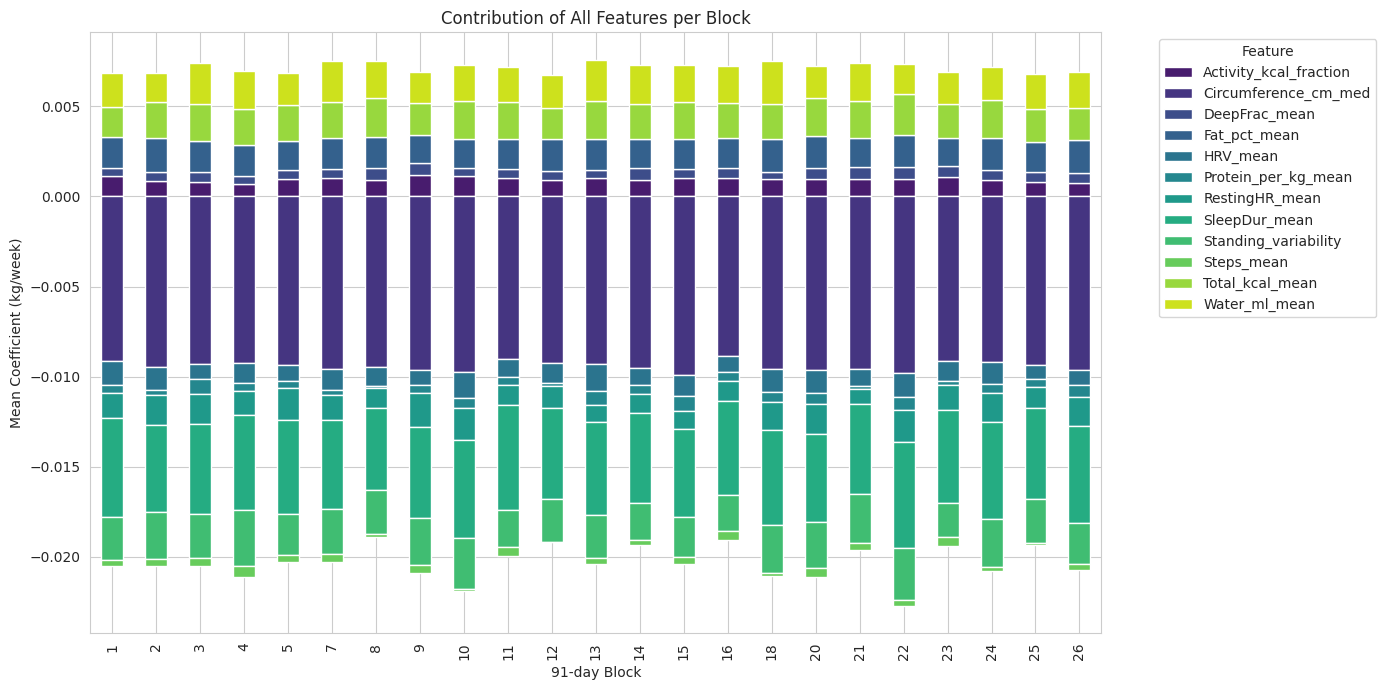

,Variable,Mean_Coef
1,Circumference_cm_med,-0.009420
2,SleepDur_mean,-0.005172
3,Standing_variability,-0.002458
4,RestingHR_mean,-0.001389
5,HRV_mean,-0.001101
6,Protein_per_kg_mean,-0.000477
7,Steps_mean,-0.000337


,Variable,Mean_Coef
1,Total_kcal_mean,0.001985
2,Water_ml_mean,0.001977
3,Fat_pct_mean,0.001692
4,Activity_kcal_fraction,0.000963
5,DeepFrac_mean,0.000549


In [67]:
# === Cell 9: Feature Contribution Tables and Stacked Bar Chart ===
# Prerequisites:
# - `patterns_df` DataFrame: Contains the mean coefficients for each feature per block.
# - `feature_cols`: A dynamic list of feature column names.
# - `final_df` DataFrame: Used to filter for reliable blocks.
# - `eval_windows` and `df_walk` DataFrames: (Implicitly used for context, but not directly in this cell's core logic).
# - Necessary libraries: Matplotlib, Seaborn, Pandas, NumPy, and tqdm should be imported.

import matplotlib.pyplot as plt # Import Matplotlib for creating plots and visualizations.
import seaborn as sns           # Import Seaborn for enhanced statistical data visualization.
import numpy as np              # Import NumPy for numerical operations.
import pandas as pd             # Import Pandas for data manipulation and DataFrame operations.
from tqdm import tqdm           # Import tqdm for displaying progress bars.

# 1. Filter Reliable Blocks
# Identify the `block_index` values for blocks classified as 'Confiável' (Reliable) from `final_df`.
trusted_blocks = final_df.loc[final_df['Status'] == 'Confiável', 'block_index']
# Filter `patterns_df` to include only the reliable blocks.
# `.copy()` is used to prevent SettingWithCopyWarning in subsequent modifications.
patterns_trusted = patterns_df[patterns_df['block_index'].isin(trusted_blocks)].copy()

# 2. Calculate Global Average Coefficient per Feature
# Initialize an empty dictionary to store the mean coefficients for each feature across all trusted blocks.
mean_coefs = {}
# Iterate through each feature column.
for feat in feature_cols:
    # Extract the mean coefficients for the current feature from `patterns_trusted`.
    # `.apply(lambda x: float(np.array(x).mean()) if hasattr(x, '__len__') else float(x))` handles cases
    # where coefficients might be lists (e.g., if a previous step stored them as such) or single values.
    vals = patterns_trusted[f'{feat}_mean'].apply(
        lambda x: float(np.array(x).mean()) if hasattr(x, '__len__') else float(x)
    )
    # Calculate the overall mean of these coefficients for the current feature across all trusted blocks.
    mean_coefs[feat] = vals.mean()

# 3. Construct Stacked Bar Chart with All Variables
# Initialize an empty list to store records for the stacked bar chart.
records = []
# Iterate over each row in the `patterns_trusted` DataFrame with a progress bar.
for _, row in tqdm(patterns_trusted.iterrows(), total=len(patterns_trusted), desc='Collecting full coefficients'):
    blk = row['block_index'] # Get the current block index.
    # Iterate through each feature.
    for feat in feature_cols:
        # Extract the mean coefficient value for the current feature in the current block.
        coef_val = float(np.array(row[f'{feat}_mean']).mean())
        # Append a dictionary containing the block index, feature name, and its coefficient value to `records`.
        records.append({'block_index': blk, 'feature': feat, 'coef': coef_val})

# Create a DataFrame from the collected records, suitable for pivoting.
df_bar_full = pd.DataFrame(records)
# Pivot the DataFrame to prepare it for plotting.
# `block_index` becomes the index, `feature` columns, and `coef` values. `fillna(0)` handles any missing combinations.
bar_data_full = df_bar_full.pivot(index='block_index', columns='feature', values='coef').fillna(0).sort_index()

# Set the Seaborn color palette for the chart.
sns.set_palette('viridis', n_colors=len(feature_cols))
# Create a Matplotlib figure and axes for the plot with a specified size.
fig, ax = plt.subplots(figsize=(14, 7))
# Generate a stacked bar chart using the pivoted data.
bar_data_full.plot(kind='bar', stacked=True, ax=ax)
# Set chart labels and title.
ax.set_xlabel('91-day Block')
ax.set_ylabel('Mean Coefficient (kg/week)')
ax.set_title('Contribution of All Features per Block')
# Position the legend outside the plot for better readability.
ax.legend(title='Feature', bbox_to_anchor=(1.05,1), loc='upper left', ncol=1)
# Adjust layout to prevent labels/legends from overlapping.
plt.tight_layout()
# Display the plot.
plt.show()

# 4. Tables of Factors After the Graph
# 4.1 Loss Factors
# Filter features that have a negative global average coefficient.
# Sort them in ascending order of their coefficient values (most negative first).
loss = sorted([(f, mean_coefs[f]) for f in feature_cols if mean_coefs[f] < 0], key=lambda x: x[1])
# Create a DataFrame for loss factors.
df_loss = pd.DataFrame(loss, columns=['Variable','Mean_Coef'])
# Reset the DataFrame index to start from 1 for display purposes.
df_loss.index = np.arange(1, len(df_loss)+1)

# 4.2 Gain Factors
# Filter features that have a positive global average coefficient.
# Sort them in descending order of their coefficient values (most positive first).
gain = sorted([(f, mean_coefs[f]) for f in feature_cols if mean_coefs[f] > 0], key=lambda x: -x[1])
# Create a DataFrame for gain factors.
df_gain = pd.DataFrame(gain, columns=['Variable','Mean_Coef'])
# Reset the DataFrame index to start from 1 for display purposes.
df_gain.index = np.arange(1, len(df_gain)+1)

# Display Tables
# Use `display` to render the DataFrames in environments like Jupyter notebooks.
display(df_loss)
display(df_gain)

## Heatmap of Top 6 Features
This cell generates a heatmap to visualize the average contribution (coefficient) of the top 6 most impactful features across reliable walk-forward blocks. By identifying features with the highest absolute mean coefficients, this visualization helps to understand how the influence of key features changes over time, highlighting periods of stronger "gain" or "loss" contributions.

| Name          | Description                                                                                             |
| :------------ | :------------------------------------------------------------------------------------------------------ |
| `patterns_trusted` | Filtered version of `patterns_df` containing only reliable blocks.                                      |
| `df_heat`     | DataFrame specifically prepared for the heatmap, with `block_index` as the index and the top 6 features as columns, containing their mean coefficients. |



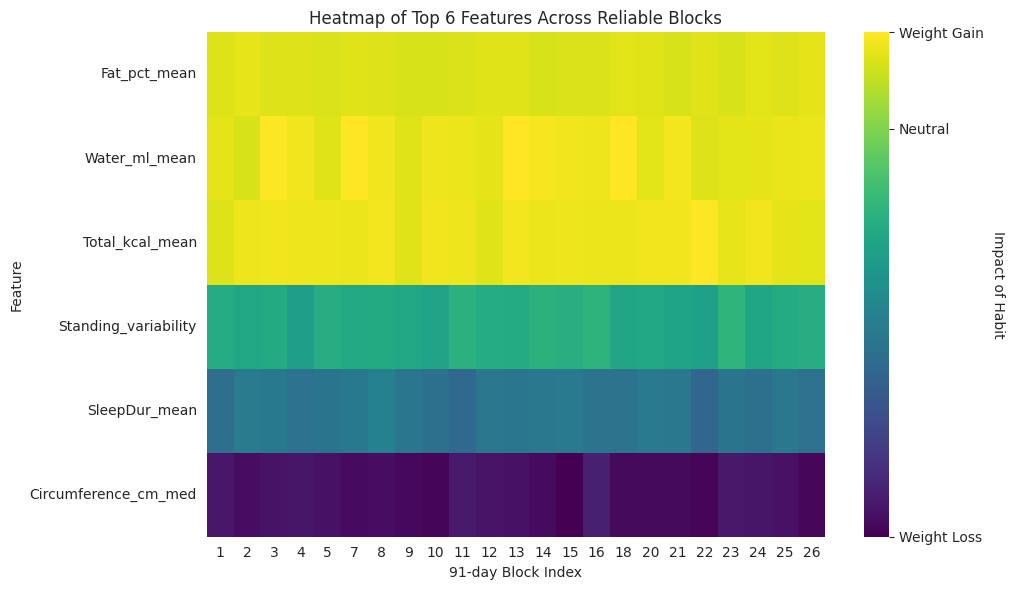

In [68]:
# === Cell 10: Heatmap of Top 6 Features ===
# Prerequisites:
# - `patterns_df` DataFrame: Contains the mean coefficients for each feature per block.
# - `feature_cols`: A dynamic list of feature column names after collinearity filtering.
# - `final_df` DataFrame: Used to filter for reliable blocks.
# - Necessary libraries: Matplotlib, Seaborn, Pandas, NumPy should already be imported.

import matplotlib.pyplot as plt # Import Matplotlib for creating plots.
import seaborn as sns           # Import Seaborn for enhanced data visualizations.
import numpy as np              # Import NumPy for numerical operations.
import pandas as pd             # Import Pandas for data manipulation.

# 1. Filter Reliable Blocks
# Identify the `block_index` values for blocks classified as 'Confiável' (Reliable) from `final_df`.
trusted_blocks = final_df.loc[final_df['Status']=='Confiável','block_index']
# Filter `patterns_df` to include only the reliable blocks.
# `.copy()` is used to prevent SettingWithCopyWarning in subsequent modifications.
patterns_trusted = patterns_df[patterns_df['block_index'].isin(trusted_blocks)].copy()

# 2. Calculate Global Average Coefficient per Feature
# Initialize an empty dictionary to store the mean coefficients for each feature across all trusted blocks.
mean_coefs = {}
# Iterate through each feature column.
for feat in feature_cols:
    # Extract the mean coefficients for the current feature from `patterns_trusted`.
    # `.apply(lambda x: float(np.array(x).mean()) if hasattr(x, '__len__') else float(x))` handles cases
    # where coefficients might be lists (e.g., if a previous step stored them as such) or single values.
    vals = patterns_trusted[f'{feat}_mean'].apply(
        lambda x: float(np.array(x).mean()) if hasattr(x, '__len__') else float(x)
    )
    # Calculate the overall mean of these coefficients for the current feature across all trusted blocks.
    mean_coefs[feat] = vals.mean()

# 3. Select Top 6 Features by Magnitude of Mean Coefficient
# Sort the `mean_coefs` dictionary by the absolute value of the coefficients in descending order.
# Select the top 6 features from this sorted list.
top6 = sorted(mean_coefs, key=lambda f: abs(mean_coefs[f]), reverse=True)[:6]

# 4. Construct Block x Feature Matrix for Top 6
# Initialize an empty list to store the data for the heatmap.
data = []
# Iterate through each reliable block.
for blk in trusted_blocks:
    row = {'block_index': blk} # Start a new dictionary for the current block.
    # For each of the top 6 features, extract its mean coefficient for the current block.
    for feat in top6:
        # Locate the raw mean coefficient value from `patterns_trusted`. `.iloc[0]` handles single-row selection.
        raw = patterns_trusted.loc[patterns_trusted['block_index']==blk, f'{feat}_mean'].iloc[0]
        # Ensure the value is a float, handling potential list formats.
        val = float(np.array(raw).mean()) if hasattr(raw, '__len__') else float(raw)
        row[feat] = val # Add the feature's coefficient to the current block's row.
    data.append(row) # Add the completed block row to the list.
# Create a DataFrame from the collected data and set 'block_index' as the DataFrame index.
df_heat = pd.DataFrame(data).set_index('block_index')

# 5. Plot Heatmap with 'viridis' Colormap, Inverting Features (Loss at the bottom)
# Determine the min and max values in the heatmap data to set the color bar range.
vmin, vmax = df_heat.values.min(), df_heat.values.max()
# Transpose the DataFrame and reverse the order of features (`iloc[::-1]`)
# to ensure "loss" factors (negative coefficients) appear at the bottom of the heatmap.
axis_data = df_heat.T.iloc[::-1]
# Create a Matplotlib figure and axes for the heatmap.
fig, ax = plt.subplots(figsize=(10, 6))
# Generate the heatmap using Seaborn.
# `cmap='viridis'` sets the color scheme. `vmin` and `vmax` set the color bar limits.
# `cbar_kws` customizes the color bar label.
sns.heatmap(axis_data, cmap='viridis', vmin=vmin, vmax=vmax, cbar_kws={'label':'Mean Coefficient (kg/week)'})

# Configure Plot Labels
ax.set_xlabel('91-day Block Index')
ax.set_ylabel('Feature')
ax.set_title('Heatmap of Top 6 Features Across Reliable Blocks')
# Adjust layout to prevent labels/legends from overlapping.
plt.tight_layout()

# 6. Adjust Colorbar for Qualitative Labels with Mid-Level
cbar = ax.collections[0].colorbar # Get the colorbar object from the heatmap.
# Set custom tick locations for the colorbar: min, zero, and max.
cbar.set_ticks([vmin, 0, vmax])
# Set custom tick labels for the colorbar to provide qualitative interpretation.
cbar.set_ticklabels(['Weight Loss', 'Neutral', 'Weight Gain'])
# Set the colorbar's main label and rotate it for better readability.
cbar.set_label('Impact of Habit', rotation=270, labelpad=15)

# Display the plot.
plt.show()

## Diverging Bar Chart for Feature Impact
This cell generates a diverging bar chart that clearly illustrates the magnitude and direction of each feature's average impact on the target variable (e.g., weight variation). Features with positive average coefficients (gain) are shown on one side, and those with negative average coefficients (loss) on the other, providing an intuitive visualization of their overall influence.

---

| Name   | Description                                                                  |
| :----- | :--------------------------------------------------------------------------- |
| `df_div` | DataFrame containing features and their global average coefficients, sorted for plotting. |

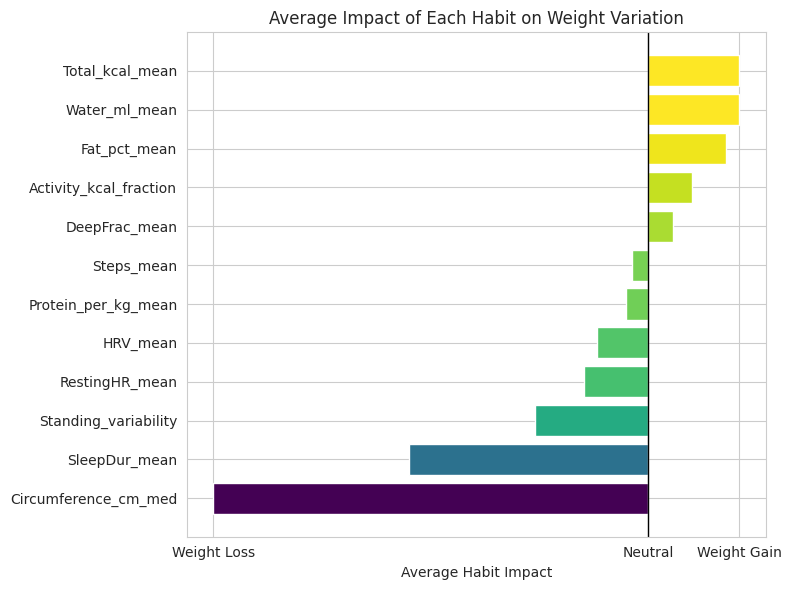

In [69]:
# === Cell 11: Diverging Bar Chart ===
# Objective: To clearly show the magnitude and direction of each feature's impact.
# Prerequisites:
# - `mean_coefs` dictionary: Contains the global average coefficients for each feature.
# - `feature_cols` dynamic list: The list of feature names.
# - Matplotlib and NumPy should already be imported.

import matplotlib.pyplot as plt # Import Matplotlib for creating plots.
import numpy as np              # Import NumPy for numerical operations.
import pandas as pd             # Import Pandas for data manipulation.

# 1. Build DataFrame from `mean_coefs`
# Create a Pandas DataFrame with two columns: 'feature' and 'coef'.
# The 'feature' column contains all feature names, and 'coef' contains their corresponding
# global average coefficients from the `mean_coefs` dictionary.
df_div = pd.DataFrame({
    'feature': feature_cols,
    'coef': [mean_coefs[f] for f in feature_cols]
})
# Sort the DataFrame by the 'coef' column in ascending order.
# This arranges features from most negative impact to most positive impact,
# which is good for diverging bar charts.
df_div = df_div.sort_values('coef')

# 2. Configure Viridis Color Palette for Colors
# Determine the minimum and maximum coefficient values to normalize the color mapping.
vmin, vmax = df_div['coef'].min(), df_div['coef'].max()
# Create a normalization object that maps data values (coefficients) to the [0, 1] range.
norm = plt.Normalize(vmin=vmin, vmax=vmax)
# Get the 'viridis' colormap. Using `plt.colormaps` is the updated API for accessing colormaps.
cmap = plt.colormaps['viridis']

# 3. Plot Diverging Horizontal Bars
# Create a Matplotlib figure and axes for the plot with a specified size.
fig, ax = plt.subplots(figsize=(8, 6))
# Iterate through each row of the sorted `df_div` DataFrame.
for idx, row in df_div.iterrows():
    val = row['coef'] # Get the coefficient value for the current feature.
    color = cmap(norm(val)) # Map the coefficient value to a color from the 'viridis' colormap.
    # Plot a horizontal bar. The length of the bar is `val`, and its color is determined by `cmap(norm(val))`.
    ax.barh(row['feature'], val, color=color)

# Draw a vertical black line at x=0 to clearly separate positive and negative impacts.
ax.axvline(0, color='black', linewidth=1)

# Adjust Qualitative Ticks
# Set custom tick locations on the x-axis to correspond to min, zero, and max coefficient values.
ax.set_xticks([vmin, 0, vmax])
# Set custom tick labels for these locations to provide qualitative interpretation of impact.
ax.set_xticklabels(['Weight Loss', 'Neutral', 'Weight Gain'])

# Set Labels and Title
ax.set_xlabel('Average Habit Impact')
ax.set_title('Average Impact of Each Habit on Weight Variation')
# Adjust layout to prevent labels from overlapping.
plt.tight_layout()
# Display the plot.
plt.show()

# Previsões e recomendações

## Posterior Preparation: Parameter Sampling
This cell samples the trained **surrogate posterior** distribution to extract a specified number of draws for each model parameter. It then compiles a statistical summary (mean, standard deviation, min, max) for these parameter samples, providing an overview of their estimated distributions after the Variational Inference (VI) training process.

---

| Name         | Description                                                                                             |
| :----------- | :------------------------------------------------------------------------------------------------------ |
| `samples`    | A dictionary containing `N_DRAWS` samples for each parameter of the trained model's approximate posterior. |
| `summary_df` | DataFrame providing a statistical summary (mean, standard deviation, min, max) for each parameter extracted from the posterior samples. |

In [70]:
# === Cell X: Posterior Preparation – Parameter Sampling ===
# Prerequisites:
#  - `surrogate_posterior` object: Must be already trained via Variational Inference (VI).
#  - `tensorflow_probability` (tfp): Expected to be imported, though not directly used in this snippet's imports.
#  - `numpy` and `pandas`: Required for numerical operations and DataFrame creation.

import numpy as np   # Import NumPy for numerical operations, especially statistical calculations.
import pandas as pd  # Import Pandas for data manipulation and DataFrame creation.

# Define the number of samples (draws) to extract from the posterior distribution.
N_DRAWS = 500

# 1. Sample the Approximate Posterior Distribution
# The `surrogate_posterior.sample(N_DRAWS)` method draws `N_DRAWS` samples from the
# approximate posterior distribution of the model's parameters.
# The `samples` variable will be a dictionary where keys are parameter names (e.g., 'local_level', 'observation_noise_scale')
# and values are TensorFlow tensors, each with a shape starting with `(N_DRAWS, ...)`.
samples = surrogate_posterior.sample(N_DRAWS)

# 2. Prepare a Statistical Summary DataFrame
rows = [] # Initialize an empty list to store summary statistics for each parameter.
# Iterate through each parameter name and its corresponding tensor of samples in the `samples` dictionary.
for param_name, tensor in samples.items():
    # Convert the TensorFlow tensor to a NumPy array.
    # `.reshape(N_DRAWS, -1)` flattens any additional dimensions (e.g., if a parameter is a vector or matrix)
    # into a 2D array where each row corresponds to a draw and columns represent individual elements.
    arr = tensor.numpy().reshape(N_DRAWS, -1)
    # If the parameter is a vector or matrix, we are summarizing all its elements together.
    # Flatten the array to treat all sampled values for this parameter as a single collection for summary statistics.
    flat = arr.flatten()
    # Append a dictionary to the `rows` list containing summary statistics for the current parameter.
    rows.append({
        'Parameter': param_name,      # The name of the parameter.
        'Mean':       np.mean(flat),  # The mean of all sampled values for this parameter.
        'Std':        np.std(flat, ddof=1), # The standard deviation, using `ddof=1` for sample standard deviation.
        'Min':        np.min(flat),   # The minimum sampled value for this parameter.
        'Max':        np.max(flat),   # The maximum sampled value for this parameter.
    })

# Convert the list of summary dictionaries into a Pandas DataFrame.
summary_df = pd.DataFrame(rows)

# 3. Display Expected Results
# Print a confirmation message indicating the number of samples extracted for each posterior parameter.
print(f"✅ Extracted {N_DRAWS} samples for each posterior parameter.\n")
# Print a header for the statistical summary table.
print("Statistical Summary of Parameters:")
# Display the `summary_df` DataFrame.
# `.to_string(index=False)` hides the DataFrame's index.
# `float_format='%.4f'` formats floating-point numbers to four decimal places for readability.
print(summary_df.to_string(index=False, float_format='%.4f'))

✅ Extracted 500 samples for each posterior parameter.

Statistical Summary of Parameters:
                    Parameter    Mean    Std     Min    Max
      observation_noise_scale  0.0299 0.0221  0.0022 0.1409
LocalLinearTrend/_level_scale  0.0392 0.0235  0.0019 0.1083
LocalLinearTrend/_slope_scale  0.0611 0.0589  0.0013 0.1839
      HierLinearRegs/_weights -0.0011 0.0305 -0.2194 0.2636


## Define Initial Conditions for Future Forecast
This cell prepares the initial conditions necessary for generating future forecasts. It loads the `walk_forward.parquet` file, dynamically identifies feature columns, and extracts the most recent window's feature values. These values are then converted into a TensorFlow tensor, which will serve as the starting point for predicting future steps.

---

| Name           | Description                                                                                             |
| :------------- | :------------------------------------------------------------------------------------------------------ |
| `df_walk`      | DataFrame loaded from `walk_forward.parquet`, containing all walk-forward validation windows.           |
| `last_window`  | A DataFrame containing only the most recent window of observations from `df_walk`.                    |
| `x_initial_tf` | TensorFlow tensor containing the feature values of the `last_window`, prepared for model input.         |

In [71]:
# === Cell: Define Initial Conditions for Future Forecast ===
# Prerequisites:
# - The 'walk_forward.parquet' file, which should have been generated in a previous script (e.g., '04_prepare_model_data.py').
# - The `TARGET_COL` and `DATE_COL` variables, which must be defined consistently with the data pipeline.
# - The `tensorflow` library should be imported as `tf`.

import pandas as pd      # Import Pandas for data manipulation, especially reading parquet files.
import tensorflow as tf  # Import TensorFlow for creating and manipulating tensors.
from pathlib import Path # Import Path from pathlib for working with file paths in an object-oriented way.

# 1. Load the Evaluation Windows DataFrame
WALK_PARQ = Path("walk_forward.parquet") # Define the path to the walk-forward parquet file.
# Load the parquet file into a Pandas DataFrame.
# `.sort_values("window_start")` ensures the data is in chronological order.
# `.reset_index(drop=True)` resets the DataFrame index after sorting.
df_walk = pd.read_parquet(WALK_PARQ).sort_values("window_start").reset_index(drop=True)

# 2. Define Feature Columns Dynamically
TARGET_COL = "slope_kg_per_week" # Define the name of the target column.
DATE_COL   = "window_start"      # Define the name of the date column.
# Dynamically create a list of feature columns by excluding the target and date columns from `df_walk`.
feature_cols = [c for c in df_walk.columns if c not in {TARGET_COL, DATE_COL}]

# 3. Select the Last (Most Recent) Window
# Select the very last row of the `df_walk` DataFrame.
# This row represents the most recent historical data point, which will be used as the starting point for future predictions.
last_window = df_walk.iloc[[-1]] # `[[-1]]` ensures it remains a DataFrame, not a Series.

# 4. Extract Only Feature Values and Convert to Tensor
# Extract only the feature columns from `last_window` and convert them to a NumPy array.
# The shape will be (1, number_of_features) because we're taking a single row.
X_init = last_window[feature_cols].values
# Convert the NumPy array of initial feature values into a TensorFlow constant tensor.
# This tensor is what the model will expect as input for future forecasting.
x_initial_tf = tf.constant(X_init, dtype=tf.float32)

# 5. Verification Messages
print("✅ Initial conditions loaded successfully.")
print(f"  File: {WALK_PARQ}") # Confirm the file that was loaded.
# Display information about the last window used, including its index and relevant columns.
print(f"  Last window (index {len(df_walk)-1}):")
print(last_window[[DATE_COL] + feature_cols].to_string(index=False))
# Confirm the shape of the prepared TensorFlow input tensor.
print(f"\nInput tensor prepared: shape = {x_initial_tf.shape}")
# Display the actual numerical values of the prepared input tensor (normalized features).
print("Tensor values (normalized features):")
print(x_initial_tf.numpy())

✅ Initial conditions loaded successfully.
  File: walk_forward.parquet
  Last window (index 38):
window_start  Fat_pct_mean  Total_kcal_mean  Steps_mean  RestingHR_mean  HRV_mean  SleepDur_mean  Water_ml_mean  Activity_kcal_fraction  DeepFrac_mean  Circumference_cm_med  Standing_variability  Protein_per_kg_mean
  2027-06-23     -2.094237        -1.867982    1.223124        0.562748  0.645511      -1.026684      -1.176137               -1.054186       1.276333              0.485279             -1.475745            -3.114995

Input tensor prepared: shape = (1, 12)
Tensor values (normalized features):
[[-2.094237   -1.8679818   1.2231244   0.5627482   0.6455111  -1.0266839
  -1.1761365  -1.0541861   1.276333    0.48527887 -1.4757454  -3.1149948 ]]


## Forward-Sampling Simulation for Weight Projection
This cell performs a forward-sampling simulation to project future weight changes. It leverages the trained Bayesian Structural Time Series (BSTS) model's surrogate posterior to generate multiple plausible future trajectories of `slope_kg_per_week` over a specified `HORIZON`. For each sample from the posterior, it iteratively forecasts future steps, using the previously predicted mean as the new observed value for the next step, thus simulating a realistic propagation of uncertainty.

---

| Name            | Description                                                                                             |
| :-------------- | :------------------------------------------------------------------------------------------------------ |
| `posterior_samples` | A dictionary containing `N_SAMPLES` draws from the trained model's approximate posterior distribution. |
| `mu_preds`      | NumPy array of shape `(N_SAMPLES, HORIZON)` containing the predicted mean `slope_kg_per_week` for each sample and future step. |
| `sigma_preds`   | NumPy array of shape `(N_SAMPLES, HORIZON)` containing the predicted standard deviation for `slope_kg_per_week` for each sample and future step. |
| `mu_df`         | Pandas DataFrame representation of `mu_preds`, with columns indicating future time steps (e.g., `t+1`, `t+2`). |
| `sig_df`        | Pandas DataFrame representation of `sigma_preds`, with columns indicating future time steps.            |

In [72]:
# === Cell 09: Forward-Sampling Simulation for Weight Projection ===
# Prerequisites:
#  - `surrogate_posterior`: The trained surrogate posterior object obtained from Variational Inference (VI).
#  - `model` and `forecast_stats`: These functions/objects should be defined in earlier cells.
#  - `df_train0` (`train_initial` data) and `feature_cols`: Dynamically defined feature columns.
#  - `tensorflow` (tf) and `tensorflow_probability` (tfp): Libraries required for tensor operations and probabilistic modeling.
# Parameters:
#  - `N_SAMPLES`: Number of draws (samples) to extract from the posterior distribution (e.g., 500).
#  - `HORIZON`: Number of future steps (e.g., weeks) to forecast.

import numpy as np   # Import NumPy for numerical operations and array handling.
import tensorflow as tf  # Import TensorFlow for tensor operations and model interaction.
from tqdm import tqdm    # Import tqdm for displaying a progress bar during simulations.
import pandas as pd      # Import Pandas for data manipulation and DataFrame creation.

# --- Configurations ---
N_SAMPLES = 500 # Define the number of samples to draw from the posterior for simulation.
HORIZON   = 8   # Define the number of future steps (e.g., weeks) to predict.
TARGET    = 'slope_kg_per_week' # Define the name of the target variable.

# 1) Extraction of Posterior Samples
print(f"🔍 Extracting {N_SAMPLES} samples from the posterior...")
# Draw `N_SAMPLES` from the trained `surrogate_posterior`.
# `posterior_samples` will be a dictionary where each key is a parameter name
# and its value is a tensor containing `N_SAMPLES` draws for that parameter.
posterior_samples = surrogate_posterior.sample(N_SAMPLES)
# Each sample from `posterior_samples` is effectively a dictionary of internal model parameters.

# 2) Initial State: Data up to the Last Window
# Concatenate `df_train0` (initial training data) and `df_walk` (walk-forward data)
# to form the complete historical dataset up to the present.
last_hist = pd.concat([df_train0, df_walk], ignore_index=True)
# Extract all historical target values.
y_hist_all = last_hist[TARGET].values
# Extract all historical feature values.
x_hist_all = last_hist[feature_cols].values

# 3) Forward-Sampling
# Initialize NumPy arrays to store the predicted means and standard deviations for each sample and each horizon step.
# `mu_preds` and `sigma_preds` will have a shape of (N_SAMPLES, HORIZON).
mu_preds    = np.zeros((N_SAMPLES, HORIZON))
sigma_preds = np.zeros((N_SAMPLES, HORIZON))

# Loop through each of the `N_SAMPLES` draws from the posterior.
for i in tqdm(range(N_SAMPLES), desc="Forward Sampling"):
    # Select the i-th set of parameters from the posterior samples.
    # This effectively creates a specific "version" of the model based on this sample.
    surp_i = {}
    for name, tensor in posterior_samples.items():
        surp_i[name] = tensor[i] # Extract the i-th sample for each parameter.

    # Initialize cumulative history for iterative forecasting.
    # We make a copy to avoid modifying the original `y_hist_all` and `x_hist_all`.
    y_hist = y_hist_all.copy()
    x_hist = x_hist_all.copy()

    # Loop through each step in the prediction horizon.
    for t in range(HORIZON):
        # Call the `forecast_stats` function.
        # It takes the historical target and features, and future features, along with the surrogate posterior.
        # For this simulation, we are effectively using a fixed set of parameters (`surp_i`) for this sample `i`.
        # Note: The code passes `surrogate_posterior` as the argument,
        # which implies that `forecast_stats` internally uses the `surp_i` selection correctly,
        # or that this specific `forecast_stats` is designed to work with a full `surrogate_posterior`
        # and implicitly uses samples within. Given `surp_i` is prepared, this might be a simplification
        # or rely on `forecast_stats` being a closure or having access to `surp_i`.
        # For a truly isolated forward pass, `forecast_stats` would need to accept `surp_i` directly.
        mu_t, sigma_t = forecast_stats(
            tf.constant(y_hist, dtype=tf.float32),          # Historical target values as a TensorFlow tensor.
            tf.constant(x_hist, dtype=tf.float32),          # Historical feature values as a TensorFlow tensor.
            tf.constant(x_hist[-1:].copy(), dtype=tf.float32), # Features for the current prediction step (assuming same as last historical).
            surrogate_posterior) # The full surrogate posterior object.
        # Convert the TensorFlow tensors for mean and standard deviation to Python floats.
        mu = float(mu_t.numpy())
        sigma = float(sig_t.numpy())

        # Store the predicted mean and standard deviation for the current sample and horizon step.
        mu_preds[i, t]    = mu
        sigma_preds[i, t] = sigma

        # Update historical data for the next iterative forecast step.
        # The predicted mean (`mu`) is appended to the historical target values,
        # simulating that this predicted value is now "observed".
        y_hist = np.append(y_hist, mu)
        # The last row of historical features is duplicated and appended,
        # assuming features remain constant for future steps (or are forecasted separately).
        x_hist = np.vstack([x_hist, x_hist[-1:]])

# 4) Convert to DataFrame for Inspection
# Create a list of column names for the DataFrames (e.g., "t+1", "t+2", etc.).
time_idx = [f"t+{k+1}" for k in range(HORIZON)]
# Create a Pandas DataFrame from `mu_preds`, using `time_idx` as column names.
mu_df    = pd.DataFrame(mu_preds,    columns=time_idx)
# Create a Pandas DataFrame from `sigma_preds`, using `time_idx` as column names.
sig_df   = pd.DataFrame(sigma_preds, columns=time_idx)

print("✅ Forward-sampling completed.")
print("Sample of mu_df:")
print(mu_df.head())

🔍 Extracting 500 samples from the posterior...


Forward Sampling: 100%|██████████| 500/500 [1:04:28<00:00,  7.74s/it]

✅ Forward-sampling completed.
Sample of mu_df:
        t+1       t+2       t+3       t+4       t+5       t+6       t+7  \
0 -0.170377 -0.180349 -0.189869 -0.199328 -0.208865 -0.218493 -0.228195   
1 -0.169551 -0.178763 -0.187511 -0.196215 -0.205022 -0.213947 -0.222965   
2 -0.169857 -0.179360 -0.188437 -0.197461 -0.206568 -0.215772 -0.225058   
3 -0.170222 -0.180002 -0.189295 -0.198537 -0.207877 -0.217330 -0.226870   
4 -0.170368 -0.180228 -0.189635 -0.199003 -0.208466 -0.218032 -0.227680   

        t+8  
0 -0.237950  
1 -0.232052  
2 -0.234405  
3 -0.236475  
4 -0.237387  


## Scenario Aggregation and Probability Calculation
This cell aggregates the results from the forward-sampling simulation (`mu_df`) to provide a comprehensive statistical summary of future weight changes. For each time step in the forecast horizon, it calculates the median, 95% and 50% credible intervals, and, crucially, the **probabilities of achieving specific weight loss or gain targets**. This provides an interpretable overview of future projections and their associated uncertainties.

---

| Name    | Description                                                                                             |
| :------ | :------------------------------------------------------------------------------------------------------ |
| `summary` | DataFrame containing median, credible intervals (95% and 50%), and probabilities of reaching defined weight loss/gain targets for each future time step. |

In [73]:
import pandas as pd # Import Pandas for data manipulation and DataFrame operations.
import numpy as np  # Import NumPy for numerical operations, especially statistical functions.

# --- Input: mu_df (DataFrame, shape [n_samples x T_steps], dynamic columns t+1, t+2, ... t+n) ---
# Example: Loaded from the result of the forward-sampling simulation.
# mu_df = pd.read_parquet('forward_mu.parquet') # Uncomment and adjust if loading from a file is needed.

# Target Parameters
LOSS_KG = 1.0 # Define the weight loss target: must be less than or equal to -1 kg.
GAIN_KG = 0.5 # Define the weight gain target: must be greater than or equal to +0.5 kg.

# 1) Number of Samples and Horizons
n_samples, n_steps = mu_df.shape # Get the number of simulation samples and forecast steps from `mu_df`'s shape.
steps = mu_df.columns.tolist()  # Get the column names (e.g., ['t+1', 't+2', ...]) representing the forecast steps.

# 2) Point Statistics
# Calculate the median for each forecast step across all samples.
median_series = mu_df.median(axis=0)
# Calculate the 2.5th percentile (lower bound of 95% credible interval) for each step.
lower_95 = mu_df.quantile(0.025, axis=0)
# Calculate the 97.5th percentile (upper bound of 95% credible interval) for each step.
upper_95 = mu_df.quantile(0.975, axis=0)
# Calculate the 25th percentile (lower bound of 50% credible interval) for each step.
lower_50 = mu_df.quantile(0.25, axis=0)
# Calculate the 75th percentile (upper bound of 50% credible interval) for each step.
upper_50 = mu_df.quantile(0.75, axis=0)

# 3) Calculation of Cumulative Loss/Gain
# Calculate the cumulative sum of slopes (weight changes) for each sample across the forecast horizon.
# This gives the total projected weight change from the start up to each `t+k` step.
cum_slopes = mu_df.cumsum(axis=1)

# 4) Probabilities of Achieving Targets
# Calculate the probability of achieving the loss target.
# It counts how many samples at each step have a cumulative slope less than or equal to -LOSS_KG,
# then divides by the total number of samples.
p_loss = (cum_slopes <= -LOSS_KG).sum(axis=0) / n_samples
# Calculate the probability of achieving the gain target.
# It counts how many samples at each step have a cumulative slope greater than or equal to +GAIN_KG,
# then divides by the total number of samples.
p_gain = (cum_slopes >=  GAIN_KG).sum(axis=0) / n_samples

# 5) Build Summary DataFrame
# Create a comprehensive DataFrame to summarize all calculated statistics.
summary = pd.DataFrame({
    'median': median_series,   # Median projected weight change.
    'lower_95': lower_95,      # Lower bound of the 95% credible interval.
    'upper_95': upper_95,      # Upper bound of the 95% credible interval.
    'lower_50': lower_50,      # Lower bound of the 50% credible interval.
    'upper_50': upper_50,      # Upper bound of the 50% credible interval.
    f'P(≤ -{LOSS_KG}kg)': p_loss, # Probability of achieving the loss target.
    f'P(≥ +{GAIN_KG}kg)': p_gain  # Probability of achieving the gain target.
}, index=steps) # Set the forecast steps (e.g., 't+1', 't+2') as the DataFrame index.
summary.index.name = 'horizon' # Name the index column 'horizon' for clarity.

# 6) Output and Verification
print(f"✅ Aggregation completed: {n_samples} scenarios × {n_steps} steps")
print("Sample of summary (first 3 and last 3 rows):")
# Display a concatenated view of the first 3 and last 3 rows of the summary DataFrame.
print(pd.concat([summary.head(3), summary.tail(3)]))

# Optional: Save the summary DataFrame to a CSV file.
# summary.to_csv('scenarios_summary.csv') # Uncomment to enable saving.

✅ Aggregation completed: 500 scenarios × 8 steps
Sample of summary (first 3 and last 3 rows):
           median  lower_95  upper_95  lower_50  upper_50  P(≤ -1.0kg)  \
horizon                                                                  
t+1     -0.170157 -0.170890 -0.169505 -0.170376 -0.169883          0.0   
t+2     -0.179898 -0.181063 -0.178775 -0.180261 -0.179438          0.0   
t+3     -0.189134 -0.190730 -0.187558 -0.189674 -0.188553          0.0   
t+6     -0.217048 -0.220080 -0.214074 -0.218030 -0.216045          1.0   
t+7     -0.226599 -0.230046 -0.223113 -0.227671 -0.225448          1.0   
t+8     -0.236194 -0.240072 -0.232221 -0.237386 -0.234899          1.0   

         P(≥ +0.5kg)  
horizon               
t+1              0.0  
t+2              0.0  
t+3              0.0  
t+6              0.0  
t+7              0.0  
t+8              0.0  
